Notebook to implement experiments from [Choi & al. 2024]


In [1]:
#Import
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data as data
import copy
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Neural Nets

In [2]:
class Generator_simple_mnist(nn.Module):
    def __init__(self, nz, ngf = 64):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

class Generator_mnist(nn.Module):
    def __init__(self, nz, ngf=64):
        super().__init__()
        self.nz = nz
        self.project_z = nn.Sequential(
            nn.Linear(nz, 28 * 28),
            nn.Tanh()  # ou autre activation si tu préfères
        )

        # Entrée : (2, 28, 28) — x concaténé à z projeté
        self.main = nn.Sequential(
            nn.Conv2d(2, ngf, 4, 2, 1, bias=False),   # -> (ngf) x 14 x 14
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),  # -> (ngf*2) x 7 x 7
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # -> (ngf) x 14 x 14
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),  # -> (1) x 28 x 28
            nn.Tanh()
        )

    def forward(self, x, z):
        B = x.size(0)
        z_proj = self.project_z(z).view(B, 1, 28, 28)  # (B, 1, 28, 28)
        xz = torch.cat([x, z_proj], dim=1)  # concat along channel: (B, 2, 28, 28)
        return self.main(xz)


class Discriminator_mnist(nn.Module):
    def __init__(self,ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

class Generator_simple_CIFAR(nn.Module):
    def __init__(self, nz, ngf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),  # (ngf*8) x 4 x 4
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # (ngf*4) x 8 x 8
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # (ngf*2) x 16 x 16
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),      # (ngf) x 32 x 32
            nn.ReLU(True),
            nn.Conv2d(ngf, 3, 3, 1, 1, bias=False),                     # 3 x 32 x 32
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator_CIFAR(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),  # 3 → ndf
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),  # 4 → 1 score
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

d=128

T = Generator_mnist(d)
v = Discriminator_mnist()


In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up=False, down=False):
        super().__init__()
        self.up = up
        self.down = down

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.activation = nn.ReLU(inplace=False)

        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        h = self.activation(x)
        if self.up:
            h = F.interpolate(h, scale_factor=2, mode='nearest')
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        h = self.conv1(h)
        h = self.activation(h)
        h = self.conv2(h)

        if self.down:
            h = F.avg_pool2d(h, 2)
            x = F.avg_pool2d(x, 2)

        return h + self.skip(x)

class Generator_CIFAR_Table7(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.fc = nn.Linear(z_dim, 128 * 4 * 4)

        self.res1 = ResBlock(128, 128, up=True)  # 4x4 → 8x8
        self.res2 = ResBlock(128, 128, up=True)  # 8x8 → 16x16
        self.res3 = ResBlock(128, 128, up=True)  # 16x16 → 32x32

        self.conv_out = nn.Conv2d(128, 3, 3, 1, 1)  # 32x32 → 3 channels

    def forward(self, z):
        h = self.fc(z).view(-1, 128, 4, 4)
        h = self.res1(h)
        h = self.res2(h)
        h = self.res3(h)
        out = torch.tanh(self.conv_out(h))
        return out

class Discriminator_CIFAR_Table7(nn.Module):
    def __init__(self):
        super().__init__()
        self.res1 = ResBlock(3, 128, down=True)     # 32x32 → 16x16
        self.res2 = ResBlock(128, 128, down=True)   # 16x16 → 8x8
        self.res3 = ResBlock(128, 128)              # 8x8 → 8x8
        self.res4 = ResBlock(128, 128)              # 8x8 → 8x8

        self.activation = nn.ReLU(inplace=False)
        self.fc_out = nn.Linear(128, 1)

    def forward(self, x):
        h = self.res1(x)
        h = self.res2(h)
        h = self.res3(h)
        h = self.res4(h)

        h = self.activation(h)
        h = h.sum(dim=[2,3])  # Global sum pooling over H and W → (B, C)
        out = self.fc_out(h)
        return out.squeeze(1)

### S-JKO

In [4]:
def cost(x,y,d,h):
    return (1/(2*d*h)) * (torch.norm(x-y,dim=1)) ** 2

def fo(v_y,div_name):
    if div_name == "KL":
        return torch.exp(- v_y - 1)
    if div_name == "Shanon":
        return 0

def w_phi(v_y):
    log_2 = torch.log(torch.tensor(2.0, device=v_y.device))
    exp_term = torch.exp(v_y - log_2)
    exp_term = torch.clamp(exp_term, min=1e-6, max=1-1e-6)
    logit = torch.log(exp_term / (1 - exp_term))
    return logit

def training_sJKO_simple(dim_noise,K,N,train_loader,batch_size,lbda_R1,lr_v,lr_T,h,div_name,dataset):

    data_iter = iter(train_loader)
    d = dim_noise
    n_gen = 20
    gen_img = []

    if dataset == "mnist":
        T = Generator_simple_mnist(d).to(device)
        v = Discriminator_mnist().to(device)
        T_old = lambda x : torch.randn(batch_size,1,28,28).to(device)
        rand_seed_gen = torch.randn(n_gen,d,1,1).to(device)
    elif dataset == "cifar10":
        T = Generator_simple_CIFAR(d).to(device) #CHANGER
        v = Discriminator_CIFAR().to(device)
        T_old = lambda x : torch.randn(batch_size,3,32,32).to(device)
        rand_seed_gen = torch.randn(n_gen,d,1,1).to(device)

    optimizerLv = optim.Adam(v.parameters(), lr=lr_v, betas=(0.5, 0.9))
    optimizerLT = optim.Adam(T.parameters(), lr=lr_T, betas=(0.5, 0.9))

    for k in range(K):

        if k == 1:
            N = N//5

        print(f"Step k={k}:")

        for i in range(N):

            if i % len(train_loader) == 0:
                data_iter = iter(train_loader)

            y = next(data_iter)[0].to(device) # B,1,28,28
            batch_size = y.size(0)
            y.requires_grad_()

            if dataset == "mnist":
                x = torch.randn(batch_size,d,1,1).to(device) # B,d,1,1
            elif dataset == "cifar10":
                x = torch.randn(batch_size,d,1,1).to(device)

            #Compute Reg1
            v_y = v(y) # B
            if lbda_R1 > 0:
                if div_name == "KL":
                    grad_real = torch.autograd.grad(outputs=v_y.sum(), inputs=y, create_graph=True)[0] # B,1,28,28
                elif div_name == "Shanon":
                    grad_real = torch.autograd.grad(outputs=w_phi(v_y).sum(), inputs=y, create_graph=True)[0] # B,1,28,28
                grad_penalty = grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
            else:
                grad_penalty = 0


            #Compute and optimize L_v
            optimizerLv.zero_grad()
            y_hat = T(x) # B,1,28,28

            if div_name == "KL":
                Lv = (v(y_hat) + (torch.exp(- v_y) - 1) + lbda_R1 * grad_penalty).mean()
            elif div_name == "Shanon":
                Lv = (F.softplus(w_phi(v(y_hat))) + F.softplus(-w_phi(v_y)) + lbda_R1 * grad_penalty).mean()
            Lv.backward()
            optimizerLv.step()

            #Compute and optimize L_T
            optimizerLT.zero_grad()
            if dataset == "mnist":
                x = torch.randn(batch_size,d,1,1).to(device) # B,d,1,1
            elif dataset == "cifar10":
                x = torch.randn(batch_size,d,1,1).to(device)
            y_hat = T(x) # B,1,28,28
            y_old = T_old(x) # B,1,28,28

            if div_name == "KL":
                LT = (cost(y_old.view(batch_size,-1),y_hat.view(batch_size,-1),d,h) - v(y_hat)).mean()
            elif div_name == "Shanon":
                LT = (cost(y_old.view(batch_size,-1),y_hat.view(batch_size,-1),d,h) + F.softplus(-w_phi(v(y_hat)))).mean()
            LT.backward()
            optimizerLT.step()

            #Print Info and images
            if i % 10 == 0:
                print(f"iter={i} | lossv={Lv} | lossT={LT}")
                if i % 100 == 0:
                    if dataset == "mnist":
                        x_noise = torch.randn(5,d,1,1).to(device)
                        y_hat = T(x_noise)
                        fig, axs = plt.subplots(1, 5, figsize=(15, 3))
                        for j in range(5):
                            img = y_hat[j].detach().cpu().squeeze()
                            img = img * 0.5 + 0.5
                            axs[j].imshow(img.numpy(), cmap='gray')
                            axs[j].axis('off')
                        plt.show()
                    if dataset == "cifar10":
                        x_noise = torch.randn(5,d,1,1).to(device)
                        y_hat = T(x_noise)
                        fig, axs = plt.subplots(1, 5, figsize=(15, 3))
                        for j in range(5):
                            img = y_hat[j].detach().cpu()
                            img = img * 0.5 + 0.5
                            img = img.permute(1, 2, 0)  # (32, 32, 3)
                            axs[j].imshow(img.numpy())
                            axs[j].axis('off')
                        plt.show()

            if i == N-1 or (i ==0 & k==0):
                imgs = T(rand_seed_gen)
                gen_img.append(imgs)

        T_old = copy.deepcopy(T)

    return T,gen_img

def training_sJKO(dim_noise,K,N,train_loader,batch_size,lbda_R1,lr_v,lr_T,h,div_name,dataset):

    data_iter = iter(train_loader)
    d = dim_noise
    n_gen = 20

    if dataset == "mnist":
        d = dim_noise
        T = Generator_mnist(d).to(device)
        v = Discriminator_mnist().to(device)
        T_old = lambda x,z : x
        rand_seed_gen_z = torch.randn(n_gen,d).to(device)
        rand_seed_gen_x = torch.randn(n_gen,1,28,28).to(device)
    elif dataset == "cifar10":
        d = dim_noise
        T = Generator_CIFAR_Table7(d).to(device) #CHANGER
        v = Discriminator_CIFAR_Table7().to(device)
        T_old = lambda x,z : x
        rand_seed_gen_z = torch.randn(n_gen,d).to(device)
        rand_seed_gen_x = torch.randn(n_gen,1,32,32).to(device)

    gen_img = [rand_seed_gen_x]


    optimizerLv = optim.Adam(v.parameters(), lr=lr_v, betas=(0.5, 0.9))
    optimizerLT = optim.Adam(T.parameters(), lr=lr_T, betas=(0.5, 0.9))

    for k in range(K):

        if k == 1:
            N = N//5

        print(f"Step k={k}:")

        for i in range(N):

            if i % len(train_loader) == 0:
                data_iter = iter(train_loader)

            y = next(data_iter)[0].to(device) # B,1,28,28
            batch_size = y.size(0)
            y.requires_grad_()

            z = torch.randn(batch_size,d).to(device) # B,d
            if dataset == "mnist":
                x = torch.randn(batch_size,1,28,28).to(device)
            elif dataset == "cifar10":
                x = torch.randn(batch_size,1,32,32).to(device)

            #Compute Reg1
            v_y = v(y) # B
            if lbda_R1 > 0:
                if div_name == "KL":
                    grad_real = torch.autograd.grad(outputs=v_y.sum(), inputs=y, create_graph=True)[0] # B,1,28,28
                elif div_name == "Shanon":
                    grad_real = torch.autograd.grad(outputs=w_phi(v_y).sum(), inputs=y, create_graph=True)[0] # B,1,28,28
                grad_penalty = grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
            else:
                grad_penalty = 0


            #Compute and optimize L_v
            optimizerLv.zero_grad()
            y_hat = T(x,z) # B,1,28,28
            Lv = (v(y_hat) + (torch.exp(- v_y) - 1) + lbda_R1 * grad_penalty).mean()
            Lv.backward()
            optimizerLv.step()

            #Compute and optimize L_T
            optimizerLT.zero_grad()
            z1 = torch.randn(batch_size,d).to(device)
            z2 = torch.randn(batch_size,d).to(device)
            if dataset == "mnist":
                x = torch.randn(batch_size,1,28,28).to(device)
            elif dataset == "cifar10":
                x = torch.randn(batch_size,1,32,32).to(device)
            y_hat = T(x,z1) # B,1,28,28
            y_old = T_old(x,z2) # B,1,28,28
            if div_name == "KL":
                LT = (cost(y_old.view(batch_size,-1),y_hat.view(batch_size,-1),d,h) - v(y_hat)).mean()
            elif div_name == "Shanon":
                LT = (cost(y_old.view(batch_size,-1),y_hat.view(batch_size,-1),d,h) + F.softplus(-w_phi(v(y_hat)))).mean()
            LT.backward()
            optimizerLT.step()

            if i % 10 == 0:
                print(f"iter={i} | lossv={Lv} | lossT={LT}")
                if i % 100 == 0:
                    z_noise = torch.randn(5,d).to(device)

                    if dataset == "mnist":
                        x_noise = torch.randn(5,1,28,28).to(device)
                        y_hat = T(x_noise,z_noise)
                        fig, axs = plt.subplots(1, 5, figsize=(15, 3))
                        for j in range(5):
                            img = y_hat[j].detach().cpu().squeeze()
                            img = img * 0.5 + 0.5
                            axs[j].imshow(img.numpy(), cmap='gray')
                            axs[j].axis('off')
                        plt.show()
                    if dataset == "cifar10":
                        x_noise = torch.randn(5,1,32,32).to(device)
                        y_hat = T(x_noise,z_noise)
                        fig, axs = plt.subplots(1, 5, figsize=(15, 3))
                        for j in range(5):
                            img = y_hat[j].detach().cpu()
                            img = img * 0.5 + 0.5
                            img = img.permute(1, 2, 0)  # (32, 32, 3)
                            axs[j].imshow(img.numpy())
                            axs[j].axis('off')
                        plt.show()

            if i == N-1 or (i ==0 & k==0):
                imgs = T(rand_seed_gen_x,rand_seed_gen_z)
                gen_img.append(imgs)

        T_old = copy.deepcopy(T)

    return T,gen_img

### MNIST

In [5]:
batch_size = 256
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
mnist = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
train_loader = data.DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.45MB/s]


#### KL

Step k=0:
iter=0 | lossv=0.007062225602567196 | lossT=30.86750030517578


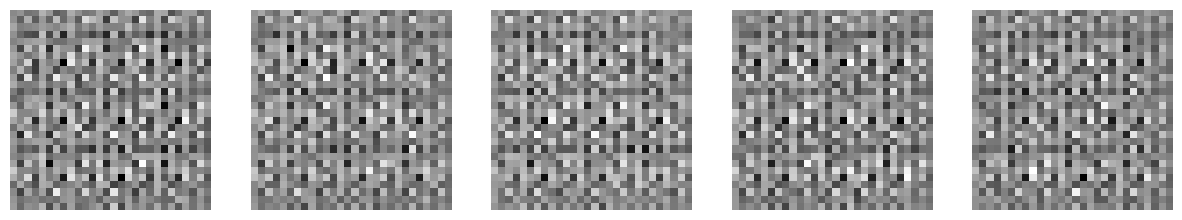

iter=10 | lossv=0.3331577181816101 | lossT=30.811243057250977
iter=20 | lossv=0.21933744847774506 | lossT=31.274948120117188
iter=30 | lossv=-0.28975212574005127 | lossT=31.967876434326172
iter=40 | lossv=-0.4586530327796936 | lossT=32.22563171386719
iter=50 | lossv=-0.5627000331878662 | lossT=31.86191749572754
iter=60 | lossv=-0.5174533724784851 | lossT=31.880298614501953
iter=70 | lossv=-0.702620267868042 | lossT=31.96261978149414
iter=80 | lossv=-1.099071741104126 | lossT=32.53186798095703
iter=90 | lossv=-0.6851646304130554 | lossT=32.499114990234375
iter=100 | lossv=-0.6107535362243652 | lossT=32.4273681640625


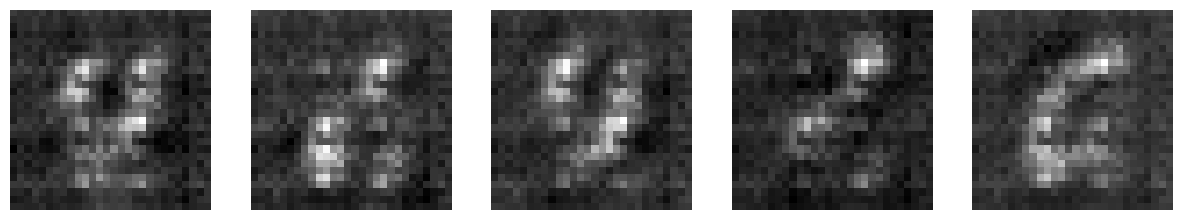

iter=110 | lossv=-0.47070443630218506 | lossT=31.965858459472656
iter=120 | lossv=-0.7629942893981934 | lossT=32.03973388671875
iter=130 | lossv=-1.1727423667907715 | lossT=32.617103576660156
iter=140 | lossv=-1.086493730545044 | lossT=32.506290435791016
iter=150 | lossv=-2.049520492553711 | lossT=33.51387405395508
iter=160 | lossv=-1.922958254814148 | lossT=33.318023681640625
iter=170 | lossv=-1.8043007850646973 | lossT=33.650123596191406
iter=180 | lossv=-2.446868419647217 | lossT=33.86557388305664
iter=190 | lossv=-3.248304843902588 | lossT=34.73369216918945
iter=200 | lossv=-3.7226216793060303 | lossT=35.402400970458984


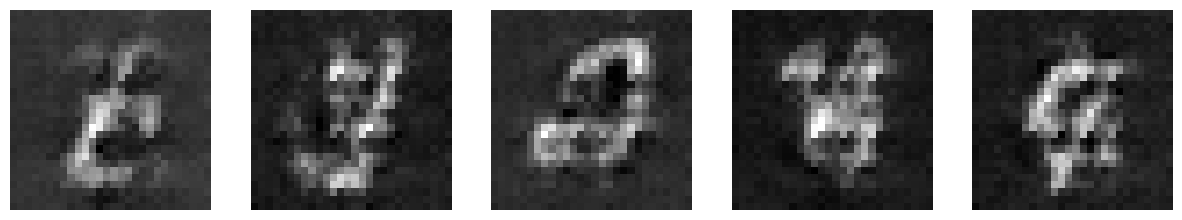

iter=210 | lossv=-4.750885009765625 | lossT=36.51877212524414
iter=220 | lossv=-5.144390106201172 | lossT=37.01966857910156
iter=230 | lossv=-5.344292640686035 | lossT=37.53059387207031
iter=240 | lossv=-5.957586288452148 | lossT=38.70147705078125
iter=250 | lossv=-6.756400108337402 | lossT=39.492637634277344
iter=260 | lossv=-6.854931831359863 | lossT=39.80360412597656
iter=270 | lossv=-6.991588592529297 | lossT=39.1908073425293
iter=280 | lossv=-7.386528968811035 | lossT=41.05316162109375
iter=290 | lossv=-7.342318534851074 | lossT=39.77817153930664
iter=300 | lossv=-8.40371036529541 | lossT=41.315338134765625


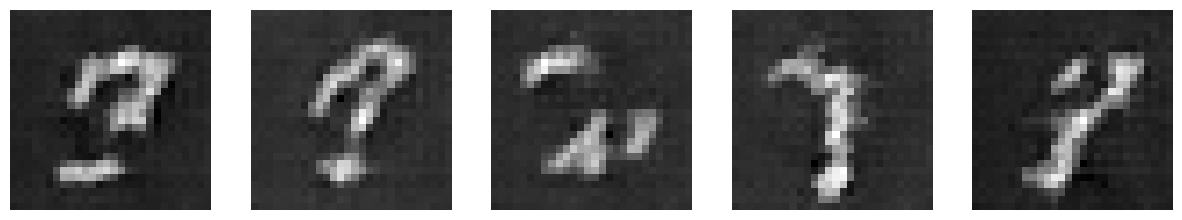

iter=310 | lossv=-7.762853145599365 | lossT=41.993141174316406
iter=320 | lossv=-8.468025207519531 | lossT=41.229366302490234
iter=330 | lossv=-8.14834976196289 | lossT=40.63562774658203
iter=340 | lossv=-8.391960144042969 | lossT=41.05733871459961
iter=350 | lossv=-9.538897514343262 | lossT=41.88408279418945
iter=360 | lossv=-11.335783958435059 | lossT=44.820228576660156
iter=370 | lossv=-7.609173774719238 | lossT=38.245941162109375
iter=380 | lossv=-9.925275802612305 | lossT=45.18930435180664
iter=390 | lossv=-10.74327278137207 | lossT=43.164588928222656
iter=400 | lossv=-8.16533374786377 | lossT=39.80397033691406


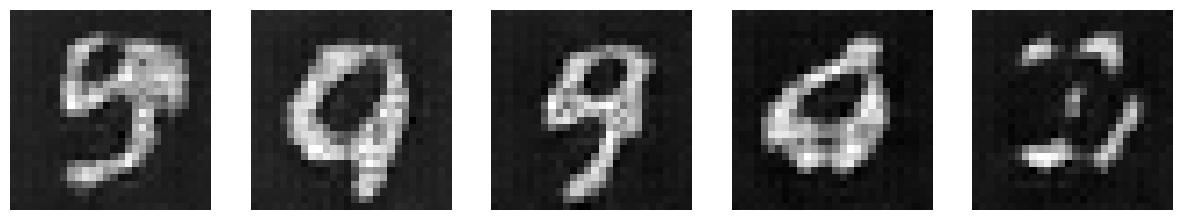

iter=410 | lossv=-11.653005599975586 | lossT=45.436927795410156
iter=420 | lossv=-12.701242446899414 | lossT=46.88199996948242
iter=430 | lossv=-12.175458908081055 | lossT=46.813236236572266
iter=440 | lossv=-12.416186332702637 | lossT=46.49818420410156
iter=450 | lossv=-13.466962814331055 | lossT=46.75785446166992
iter=460 | lossv=-11.607518196105957 | lossT=48.564002990722656
iter=470 | lossv=-14.784093856811523 | lossT=51.70222473144531
iter=480 | lossv=-14.063525199890137 | lossT=46.66949462890625
iter=490 | lossv=-12.792963981628418 | lossT=50.90840148925781
iter=500 | lossv=-15.744251251220703 | lossT=50.35142517089844


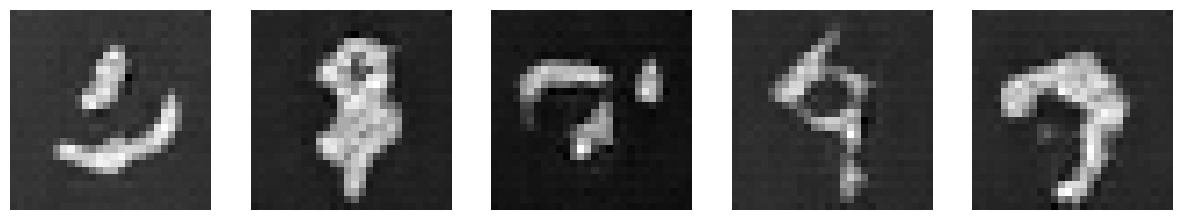

iter=510 | lossv=-16.920394897460938 | lossT=51.59710693359375
iter=520 | lossv=-11.525358200073242 | lossT=38.637420654296875
iter=530 | lossv=-15.772233963012695 | lossT=50.98431396484375
iter=540 | lossv=-18.44287872314453 | lossT=52.027984619140625
iter=550 | lossv=-19.099445343017578 | lossT=56.01062774658203
iter=560 | lossv=-19.011539459228516 | lossT=54.782466888427734
iter=570 | lossv=-18.614763259887695 | lossT=57.036277770996094
iter=580 | lossv=-18.482240676879883 | lossT=53.55962371826172
iter=590 | lossv=-20.34973907470703 | lossT=54.92578125
iter=600 | lossv=-19.637136459350586 | lossT=54.336177825927734


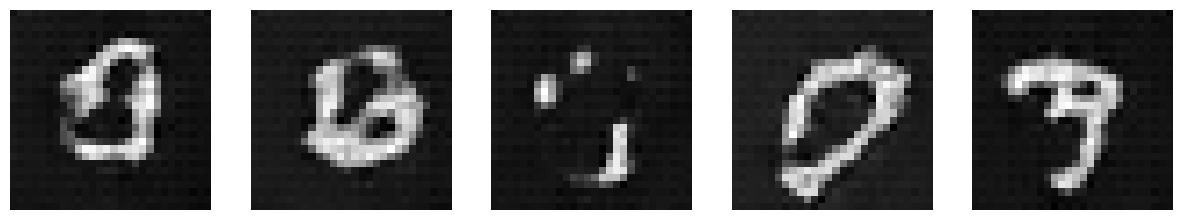

iter=610 | lossv=-20.268836975097656 | lossT=57.23472595214844
iter=620 | lossv=-21.65299415588379 | lossT=55.28593063354492
iter=630 | lossv=-20.983383178710938 | lossT=57.399192810058594
iter=640 | lossv=-25.358537673950195 | lossT=59.84618377685547
iter=650 | lossv=-24.182701110839844 | lossT=63.323936462402344
iter=660 | lossv=-24.72846221923828 | lossT=61.739173889160156
iter=670 | lossv=-27.040863037109375 | lossT=63.91834259033203
iter=680 | lossv=-24.940649032592773 | lossT=61.91584777832031
iter=690 | lossv=-26.550464630126953 | lossT=64.50234985351562
iter=700 | lossv=-22.180376052856445 | lossT=50.643280029296875


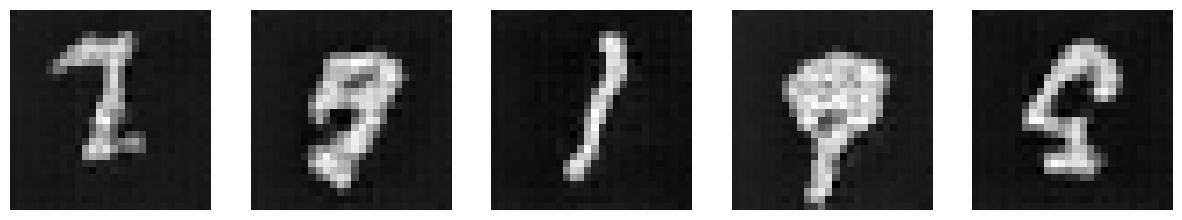

iter=710 | lossv=-28.32900619506836 | lossT=66.66572570800781
iter=720 | lossv=-27.26333999633789 | lossT=63.71307373046875
iter=730 | lossv=-31.976402282714844 | lossT=68.94387817382812
iter=740 | lossv=-32.053428649902344 | lossT=71.65130615234375
iter=750 | lossv=-33.84565734863281 | lossT=71.8639144897461
iter=760 | lossv=-35.08167266845703 | lossT=66.93487548828125
iter=770 | lossv=-33.58395004272461 | lossT=71.13211822509766
iter=780 | lossv=-39.72843551635742 | lossT=75.0988540649414
iter=790 | lossv=-39.0312385559082 | lossT=74.70600891113281
iter=800 | lossv=-40.161712646484375 | lossT=79.20037841796875


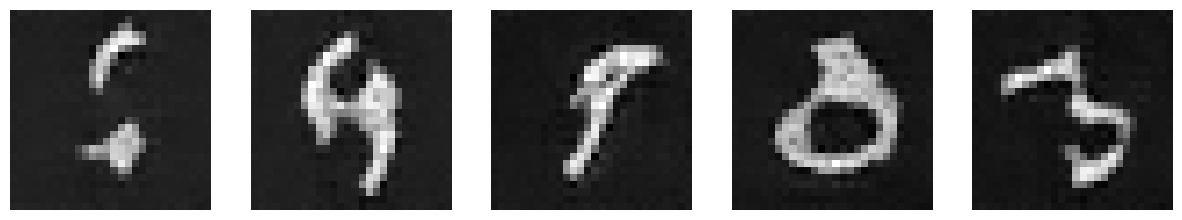

iter=810 | lossv=-41.18920135498047 | lossT=78.49974060058594
iter=820 | lossv=-23.845279693603516 | lossT=59.94816589355469
iter=830 | lossv=-36.6800422668457 | lossT=76.98345947265625
iter=840 | lossv=-43.28105163574219 | lossT=81.96660614013672
iter=850 | lossv=-42.03190612792969 | lossT=77.27323913574219
iter=860 | lossv=-39.2555046081543 | lossT=70.16629028320312
iter=870 | lossv=-45.12224578857422 | lossT=79.69976806640625
iter=880 | lossv=-47.56910705566406 | lossT=85.57646179199219
iter=890 | lossv=-34.640480041503906 | lossT=83.02217102050781
iter=900 | lossv=-42.292869567871094 | lossT=83.14608764648438


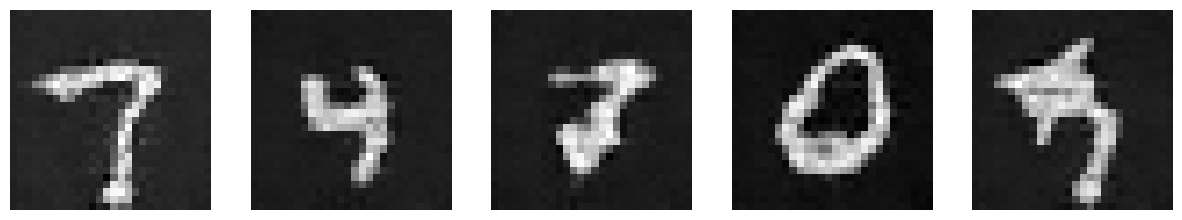

iter=910 | lossv=-50.26384353637695 | lossT=86.68807983398438
iter=920 | lossv=-19.531352996826172 | lossT=56.588661193847656
iter=930 | lossv=-12.458592414855957 | lossT=51.38674545288086
iter=940 | lossv=-17.777175903320312 | lossT=57.56194305419922
iter=950 | lossv=-22.544010162353516 | lossT=72.13526916503906
iter=960 | lossv=-24.18675422668457 | lossT=75.46351623535156
iter=970 | lossv=-3.121420383453369 | lossT=63.565040588378906
iter=980 | lossv=2.4346022605895996 | lossT=57.09619140625
iter=990 | lossv=-2.116352081298828 | lossT=58.705787658691406
Step k=1:
iter=0 | lossv=-0.7474966049194336 | lossT=3.607025146484375


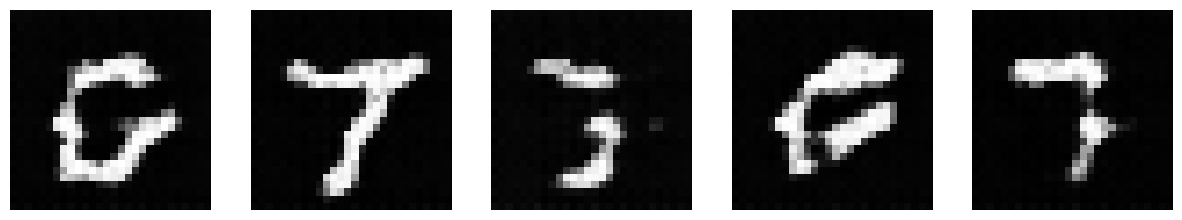

iter=10 | lossv=-0.9789117574691772 | lossT=3.580702304840088
iter=20 | lossv=-1.1035170555114746 | lossT=5.240415573120117
iter=30 | lossv=-0.8932977914810181 | lossT=3.749626874923706
iter=40 | lossv=-2.0714755058288574 | lossT=5.313032150268555
iter=50 | lossv=-0.8777927756309509 | lossT=5.854783058166504
iter=60 | lossv=-2.0483181476593018 | lossT=6.612975120544434
iter=70 | lossv=-1.760096549987793 | lossT=6.796604156494141
iter=80 | lossv=0.2807924747467041 | lossT=5.283822059631348
iter=90 | lossv=-0.27339014410972595 | lossT=2.950834274291992
iter=100 | lossv=-1.0099693536758423 | lossT=5.622017860412598


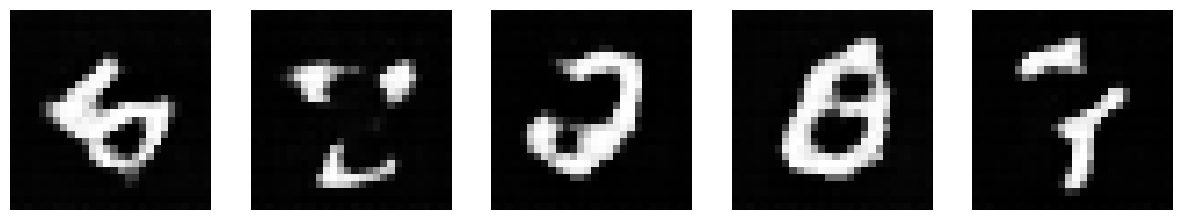

iter=110 | lossv=-0.6128458976745605 | lossT=3.9976792335510254
iter=120 | lossv=-1.5918587446212769 | lossT=6.292318344116211
iter=130 | lossv=-1.3635993003845215 | lossT=8.140775680541992
iter=140 | lossv=-1.4962894916534424 | lossT=6.711335182189941
iter=150 | lossv=2.9412131309509277 | lossT=0.360107421875
iter=160 | lossv=-1.8470796346664429 | lossT=6.429085731506348
iter=170 | lossv=-0.910028338432312 | lossT=5.646751880645752
iter=180 | lossv=-0.7694915533065796 | lossT=6.627017974853516
iter=190 | lossv=-0.6312094926834106 | lossT=7.028946399688721
Step k=2:
iter=0 | lossv=-0.644672691822052 | lossT=2.6938681602478027


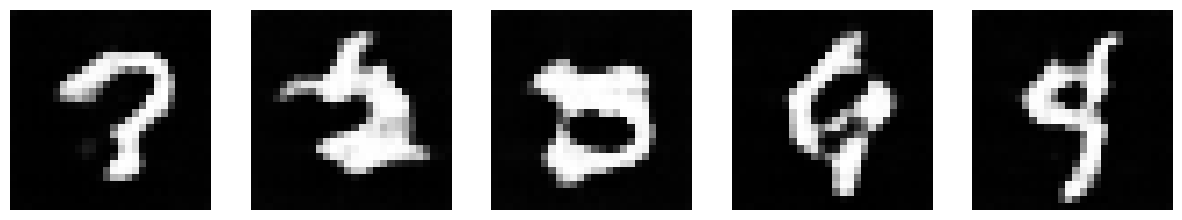

iter=10 | lossv=-0.5413600206375122 | lossT=2.273103713989258
iter=20 | lossv=0.14345413446426392 | lossT=0.012585312128067017
iter=30 | lossv=-1.0082916021347046 | lossT=2.9969964027404785
iter=40 | lossv=-0.989841103553772 | lossT=2.127739429473877
iter=50 | lossv=0.6503554582595825 | lossT=-0.4840846657752991
iter=60 | lossv=-0.7522947788238525 | lossT=1.6376831531524658
iter=70 | lossv=-0.7360243797302246 | lossT=0.1044817641377449
iter=80 | lossv=-0.8598659038543701 | lossT=1.851605772972107
iter=90 | lossv=-0.662353515625 | lossT=2.478384494781494
iter=100 | lossv=-0.022141527384519577 | lossT=0.20760789513587952


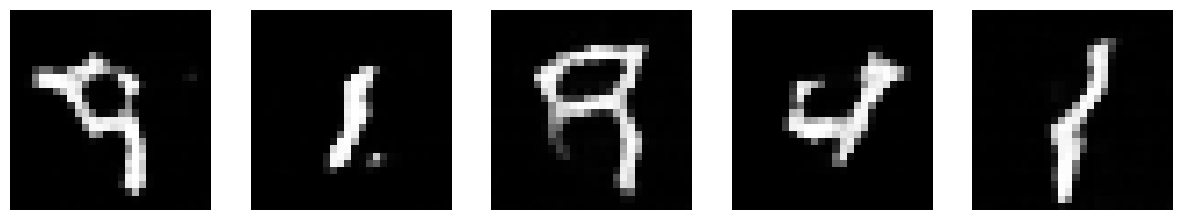

iter=110 | lossv=-1.1743837594985962 | lossT=2.5832996368408203
iter=120 | lossv=-0.8252913355827332 | lossT=1.7248618602752686
iter=130 | lossv=-1.4325523376464844 | lossT=1.7948071956634521
iter=140 | lossv=-1.428054928779602 | lossT=2.832587242126465
iter=150 | lossv=-1.0845825672149658 | lossT=2.495368480682373
iter=160 | lossv=-1.0571752786636353 | lossT=1.8277738094329834
iter=170 | lossv=-0.9291477203369141 | lossT=0.6086148023605347
iter=180 | lossv=-1.0507102012634277 | lossT=2.648493528366089
iter=190 | lossv=-1.537203311920166 | lossT=2.913963556289673
Step k=3:
iter=0 | lossv=-0.09024293720722198 | lossT=-0.4114786982536316


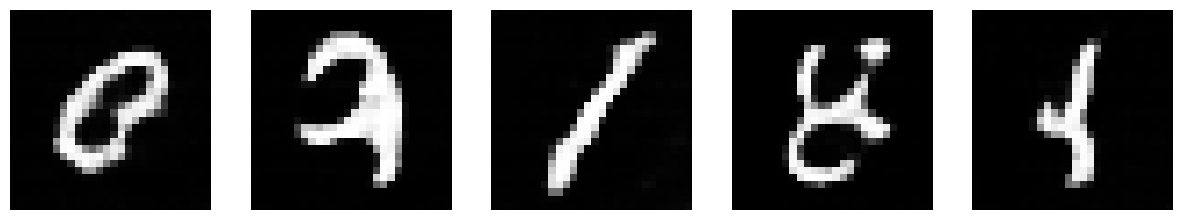

iter=10 | lossv=-1.044111728668213 | lossT=2.033773422241211
iter=20 | lossv=-0.9372628331184387 | lossT=2.4531502723693848
iter=30 | lossv=-0.2627307176589966 | lossT=1.3060073852539062
iter=40 | lossv=-0.9217969179153442 | lossT=1.3958922624588013
iter=50 | lossv=-0.9135153889656067 | lossT=1.273098111152649
iter=60 | lossv=-1.2937986850738525 | lossT=2.1383447647094727
iter=70 | lossv=-0.7488489151000977 | lossT=0.8939290046691895
iter=80 | lossv=-1.008710265159607 | lossT=1.8199741840362549
iter=90 | lossv=-0.28787553310394287 | lossT=1.4122607707977295
iter=100 | lossv=-0.9839010238647461 | lossT=2.027994155883789


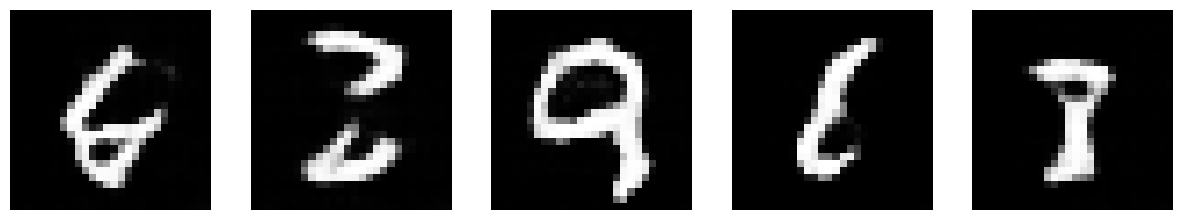

iter=110 | lossv=-1.3647195100784302 | lossT=2.718587875366211
iter=120 | lossv=-1.0722395181655884 | lossT=1.4374139308929443
iter=130 | lossv=-0.9373005628585815 | lossT=2.2691221237182617
iter=140 | lossv=-1.3398358821868896 | lossT=2.4611968994140625
iter=150 | lossv=-1.0175154209136963 | lossT=1.4514158964157104
iter=160 | lossv=0.37390953302383423 | lossT=1.0864988565444946
iter=170 | lossv=-1.1907323598861694 | lossT=2.2336549758911133
iter=180 | lossv=-1.1427497863769531 | lossT=1.8671889305114746
iter=190 | lossv=-1.3188624382019043 | lossT=2.786327838897705
Step k=4:
iter=0 | lossv=-1.3513314723968506 | lossT=2.0910568237304688


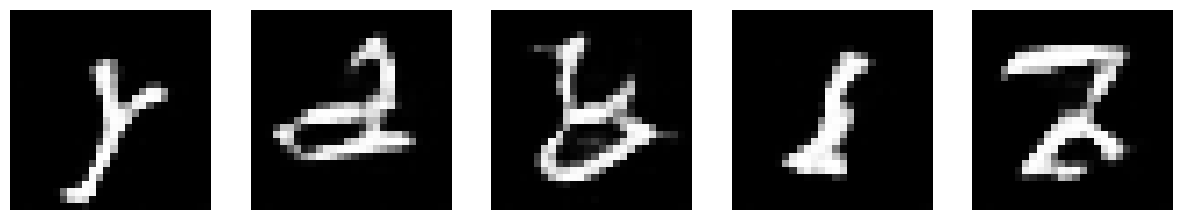

iter=10 | lossv=-1.0844365358352661 | lossT=1.7486664056777954
iter=20 | lossv=-0.6337347030639648 | lossT=2.0788660049438477
iter=30 | lossv=-1.1321560144424438 | lossT=1.6591782569885254
iter=40 | lossv=-0.9368795156478882 | lossT=1.9511839151382446
iter=50 | lossv=-0.8273534774780273 | lossT=1.9510815143585205
iter=60 | lossv=-0.7279825806617737 | lossT=1.962357521057129
iter=70 | lossv=-0.5282903909683228 | lossT=2.874485969543457
iter=80 | lossv=-0.7859667539596558 | lossT=1.6643292903900146
iter=90 | lossv=-1.0524208545684814 | lossT=1.7084234952926636
iter=100 | lossv=-0.8537093997001648 | lossT=1.6349780559539795


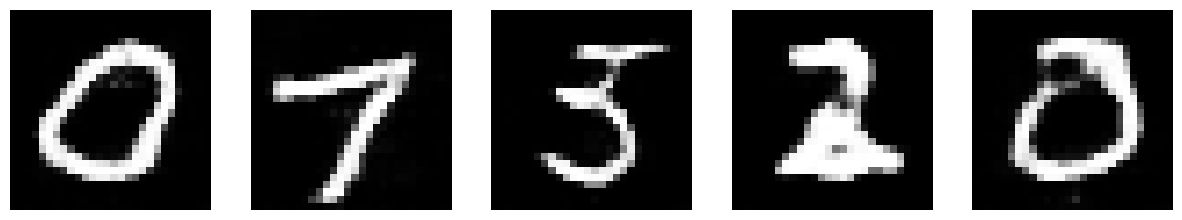

iter=110 | lossv=-1.2874729633331299 | lossT=2.676144599914551
iter=120 | lossv=-0.7527655959129333 | lossT=1.5251517295837402
iter=130 | lossv=-0.8906672596931458 | lossT=2.129040241241455
iter=140 | lossv=-0.9802478551864624 | lossT=2.2909042835235596
iter=150 | lossv=0.3652467727661133 | lossT=0.5480153560638428
iter=160 | lossv=-0.5098137855529785 | lossT=0.8505333662033081
iter=170 | lossv=-1.1907730102539062 | lossT=1.9246174097061157
iter=180 | lossv=-0.8786861300468445 | lossT=3.160799026489258
iter=190 | lossv=-0.7196125984191895 | lossT=1.6693370342254639
Step k=5:
iter=0 | lossv=-1.0165631771087646 | lossT=1.7263590097427368


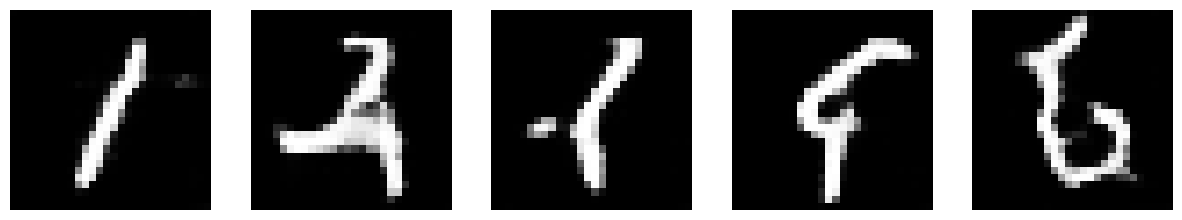

iter=10 | lossv=-0.4406534433364868 | lossT=0.4362982213497162
iter=20 | lossv=-0.6858608722686768 | lossT=1.3299179077148438
iter=30 | lossv=-1.0096404552459717 | lossT=2.077498435974121
iter=40 | lossv=-0.7473851442337036 | lossT=1.6744065284729004
iter=50 | lossv=-0.8524653911590576 | lossT=1.5077933073043823
iter=60 | lossv=-0.7539951205253601 | lossT=2.0462002754211426
iter=70 | lossv=-0.6685280799865723 | lossT=0.7455495595932007
iter=80 | lossv=-0.6455353498458862 | lossT=1.0665773153305054
iter=90 | lossv=-0.8617938756942749 | lossT=1.05259108543396
iter=100 | lossv=-0.9438967704772949 | lossT=1.5109710693359375


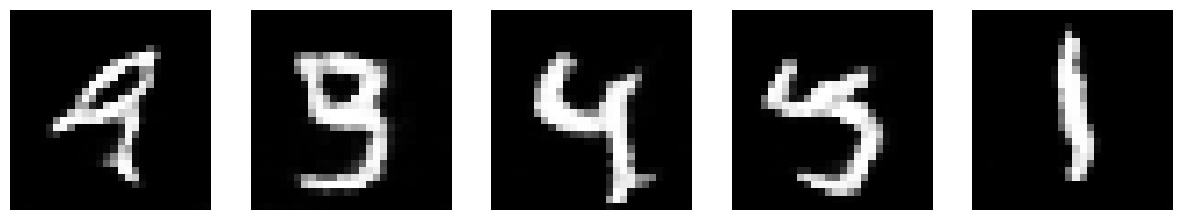

iter=110 | lossv=-0.21851469576358795 | lossT=-0.33668720722198486
iter=120 | lossv=-0.7561919689178467 | lossT=1.6584113836288452
iter=130 | lossv=-0.8281726241111755 | lossT=0.4812212288379669
iter=140 | lossv=-0.941700279712677 | lossT=1.5791525840759277
iter=150 | lossv=-0.14529266953468323 | lossT=-0.4318787753582001
iter=160 | lossv=-0.7972658276557922 | lossT=1.3053637742996216
iter=170 | lossv=-0.4767006039619446 | lossT=1.6089890003204346
iter=180 | lossv=-0.764919638633728 | lossT=1.6195404529571533
iter=190 | lossv=-0.7730214595794678 | lossT=1.8564523458480835
Step k=6:
iter=0 | lossv=-0.578742504119873 | lossT=0.051987577229738235


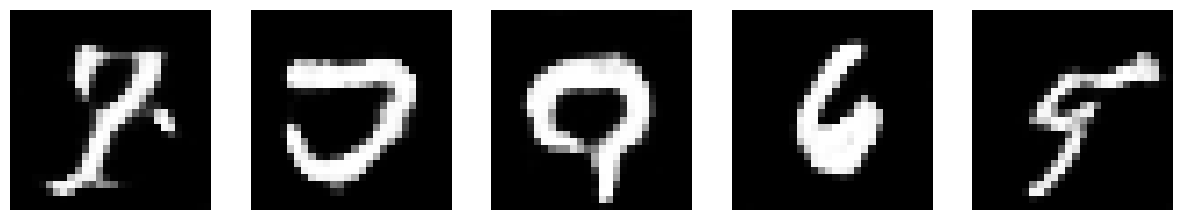

iter=10 | lossv=-0.8497996926307678 | lossT=1.0743001699447632
iter=20 | lossv=-0.84202641248703 | lossT=1.3789654970169067
iter=30 | lossv=-0.8439699411392212 | lossT=1.6742733716964722
iter=40 | lossv=-1.0014352798461914 | lossT=1.0330907106399536
iter=50 | lossv=-0.7143160104751587 | lossT=1.3521451950073242
iter=60 | lossv=-0.7193176746368408 | lossT=1.539886474609375
iter=70 | lossv=1.4538679122924805 | lossT=-0.6859248280525208
iter=80 | lossv=-0.6378347873687744 | lossT=1.4174810647964478
iter=90 | lossv=-1.0232229232788086 | lossT=1.6062664985656738
iter=100 | lossv=-0.5849683284759521 | lossT=1.4839646816253662


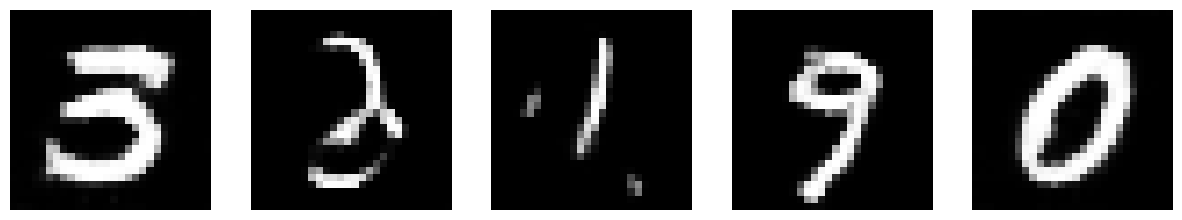

iter=110 | lossv=-0.6481682062149048 | lossT=1.4342713356018066
iter=120 | lossv=-0.581334114074707 | lossT=1.2429707050323486
iter=130 | lossv=-0.9330766797065735 | lossT=1.474729061126709
iter=140 | lossv=-0.6614620685577393 | lossT=0.821405827999115
iter=150 | lossv=-0.5657039284706116 | lossT=1.0312488079071045
iter=160 | lossv=-0.06568063795566559 | lossT=0.2879413664340973
iter=170 | lossv=-0.5326130390167236 | lossT=1.5016249418258667
iter=180 | lossv=-1.0235166549682617 | lossT=1.7141554355621338
iter=190 | lossv=-0.5310395359992981 | lossT=1.2814550399780273
Step k=7:
iter=0 | lossv=-0.7771483659744263 | lossT=0.6448770761489868


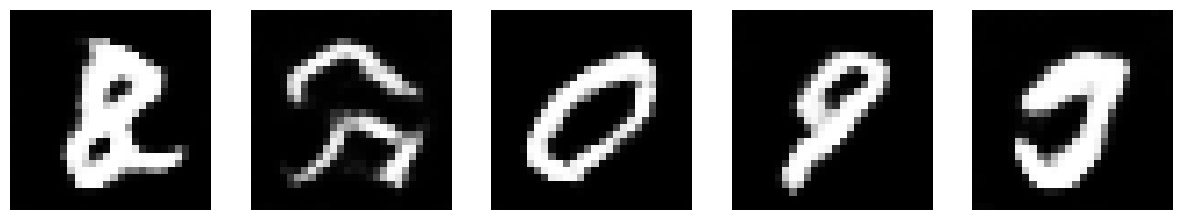

iter=10 | lossv=-0.03062969073653221 | lossT=0.8644342422485352
iter=20 | lossv=-0.6691614389419556 | lossT=1.0268754959106445
iter=30 | lossv=-0.16776016354560852 | lossT=1.044323444366455
iter=40 | lossv=-0.5544483661651611 | lossT=1.4716520309448242
iter=50 | lossv=-0.2970868647098541 | lossT=1.4684686660766602
iter=60 | lossv=-0.6413591504096985 | lossT=0.3686126470565796
iter=70 | lossv=-0.5978749990463257 | lossT=1.1979656219482422
iter=80 | lossv=-0.5437492728233337 | lossT=1.3902041912078857
iter=90 | lossv=-0.7520663738250732 | lossT=1.2819373607635498
iter=100 | lossv=-0.4275384247303009 | lossT=1.5949912071228027


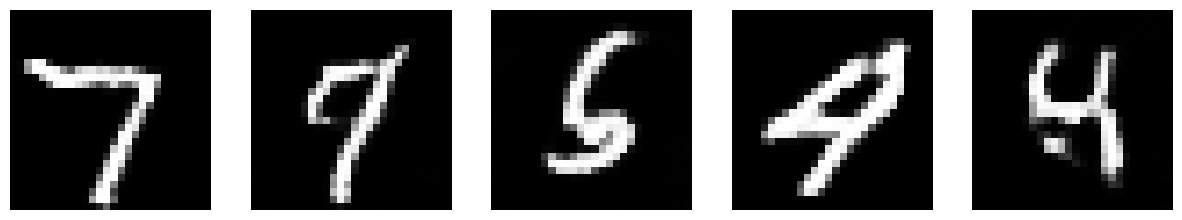

iter=110 | lossv=-0.7247822284698486 | lossT=1.360137701034546
iter=120 | lossv=-0.6113643646240234 | lossT=1.0422389507293701
iter=130 | lossv=-0.37901902198791504 | lossT=1.4042448997497559
iter=140 | lossv=-0.5924081206321716 | lossT=1.1545329093933105
iter=150 | lossv=-0.1705104112625122 | lossT=1.6592214107513428
iter=160 | lossv=-0.8152076005935669 | lossT=1.2709887027740479
iter=170 | lossv=-0.2840401828289032 | lossT=0.20470735430717468
iter=180 | lossv=-0.6193994283676147 | lossT=2.34183406829834
iter=190 | lossv=-0.7520661354064941 | lossT=1.562471628189087
Step k=8:
iter=0 | lossv=-0.8457732200622559 | lossT=0.7368682622909546


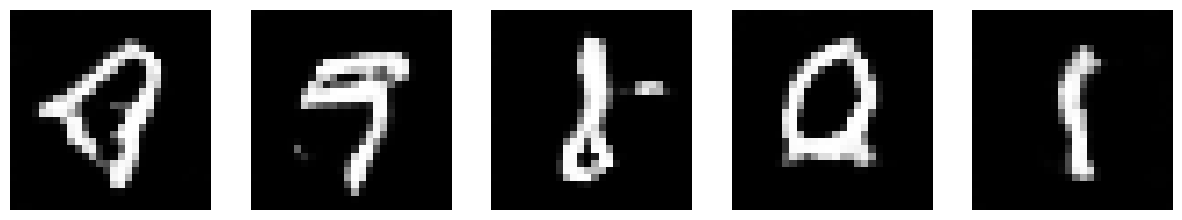

iter=10 | lossv=-0.5509433150291443 | lossT=0.6783775091171265
iter=20 | lossv=-0.7718625068664551 | lossT=0.47650372982025146
iter=30 | lossv=-0.4963860511779785 | lossT=1.385831594467163
iter=40 | lossv=-0.24153459072113037 | lossT=0.5079310536384583
iter=50 | lossv=-0.5807151794433594 | lossT=1.1369571685791016
iter=60 | lossv=-0.7487077713012695 | lossT=1.6704561710357666
iter=70 | lossv=-0.6984840035438538 | lossT=1.351823091506958
iter=80 | lossv=-0.4173414707183838 | lossT=0.8962323665618896
iter=90 | lossv=-0.6130232810974121 | lossT=1.1247529983520508
iter=100 | lossv=-0.3851984739303589 | lossT=0.5900174379348755


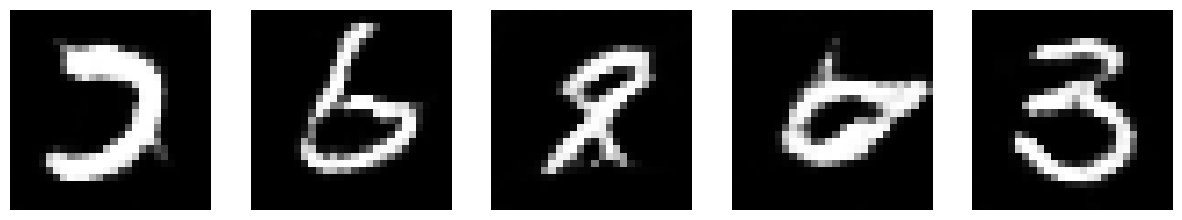

iter=110 | lossv=-0.4422803819179535 | lossT=0.4287685453891754
iter=120 | lossv=-0.44069430232048035 | lossT=1.177032709121704
iter=130 | lossv=-0.7533142566680908 | lossT=0.30433177947998047
iter=140 | lossv=-0.43609529733657837 | lossT=1.9595870971679688
iter=150 | lossv=-0.37558621168136597 | lossT=1.2350001335144043
iter=160 | lossv=-0.21551646292209625 | lossT=1.582778811454773
iter=170 | lossv=-0.6471298336982727 | lossT=1.648871660232544
iter=180 | lossv=-0.7225513458251953 | lossT=1.3263733386993408
iter=190 | lossv=-0.6891713738441467 | lossT=0.2961121201515198
Step k=9:
iter=0 | lossv=-0.7817643880844116 | lossT=1.241020917892456


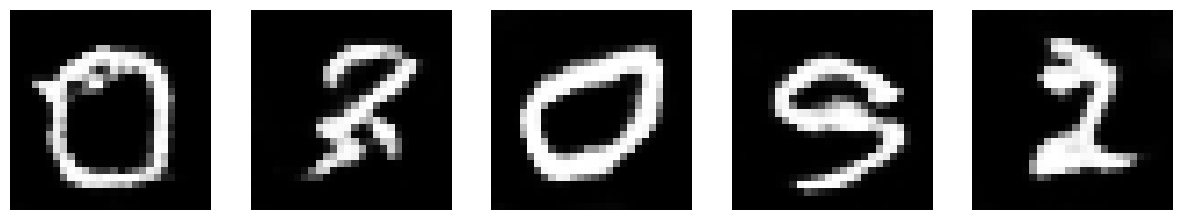

iter=10 | lossv=-0.684766411781311 | lossT=1.2345600128173828
iter=20 | lossv=-0.5188075304031372 | lossT=1.2618796825408936
iter=30 | lossv=-0.44090044498443604 | lossT=1.0937292575836182
iter=40 | lossv=-0.016340328380465508 | lossT=1.4629709720611572
iter=50 | lossv=-0.5162619352340698 | lossT=1.259317398071289
iter=60 | lossv=-0.6484010219573975 | lossT=0.5638617277145386
iter=70 | lossv=-0.45337456464767456 | lossT=0.8873449563980103
iter=80 | lossv=-0.5163393616676331 | lossT=0.4545704424381256
iter=90 | lossv=-0.5462416410446167 | lossT=1.0383158922195435
iter=100 | lossv=-0.6116430759429932 | lossT=0.7528472542762756


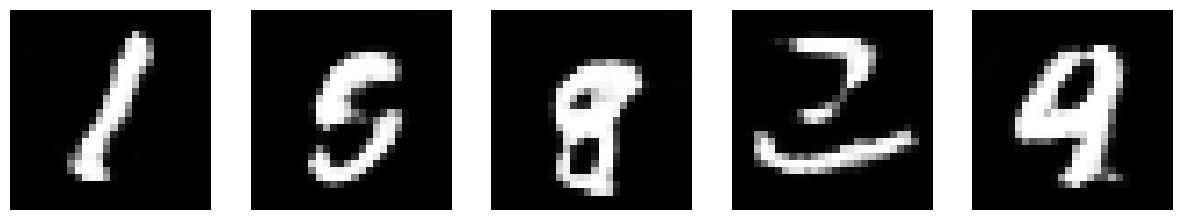

iter=110 | lossv=-0.5230188369750977 | lossT=0.9662789702415466
iter=120 | lossv=-0.3593507409095764 | lossT=1.1439085006713867
iter=130 | lossv=-0.5564093589782715 | lossT=0.24794870615005493
iter=140 | lossv=-0.19625583291053772 | lossT=0.6973421573638916
iter=150 | lossv=-0.6282633543014526 | lossT=1.5188069343566895
iter=160 | lossv=-0.43598657846450806 | lossT=0.7272013425827026
iter=170 | lossv=-0.18087100982666016 | lossT=0.16177776455879211
iter=180 | lossv=-0.4542432427406311 | lossT=0.7694392204284668
iter=190 | lossv=-0.414955735206604 | lossT=0.8169154524803162
Step k=10:
iter=0 | lossv=-0.5407556891441345 | lossT=1.3622466325759888


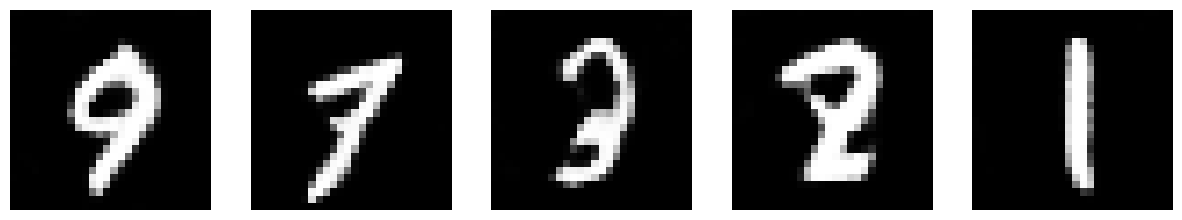

iter=10 | lossv=-0.49356770515441895 | lossT=0.8536748886108398
iter=20 | lossv=-0.43483197689056396 | lossT=0.6937226057052612
iter=30 | lossv=-0.3530551493167877 | lossT=0.16218222677707672
iter=40 | lossv=-0.5749099850654602 | lossT=0.7353289127349854
iter=50 | lossv=-0.5310301184654236 | lossT=1.0658243894577026
iter=60 | lossv=-0.311382532119751 | lossT=0.061687171459198
iter=70 | lossv=-0.5370442867279053 | lossT=1.5534659624099731
iter=80 | lossv=-0.4348487854003906 | lossT=1.669390082359314
iter=90 | lossv=-0.4818287193775177 | lossT=0.7156417369842529
iter=100 | lossv=0.057757750153541565 | lossT=-0.843828022480011


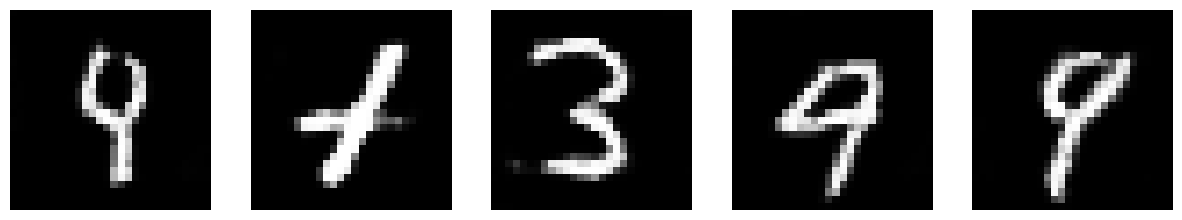

iter=110 | lossv=-0.3872300386428833 | lossT=0.5363619923591614
iter=120 | lossv=-0.4918788969516754 | lossT=1.1790406703948975
iter=130 | lossv=-0.29066866636276245 | lossT=1.3915321826934814
iter=140 | lossv=-0.35915106534957886 | lossT=0.08642005920410156
iter=150 | lossv=-0.1450367271900177 | lossT=0.7921757698059082
iter=160 | lossv=-0.4237368106842041 | lossT=0.7358730435371399
iter=170 | lossv=-0.3938577473163605 | lossT=1.3743308782577515
iter=180 | lossv=-0.4978516697883606 | lossT=1.4454280138015747
iter=190 | lossv=-0.5961490273475647 | lossT=1.4183658361434937
Step k=11:
iter=0 | lossv=-0.6133149266242981 | lossT=0.3533819317817688


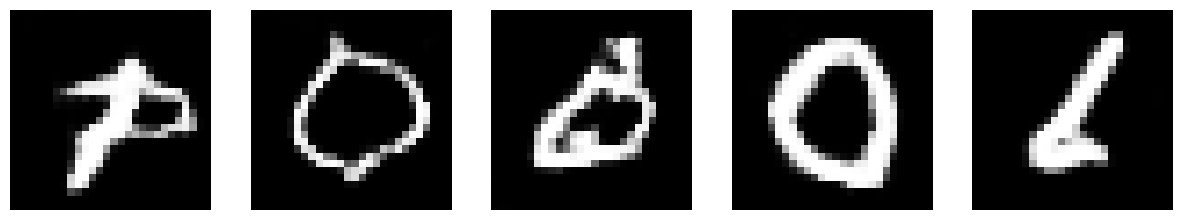

iter=10 | lossv=-0.30673089623451233 | lossT=1.2881262302398682
iter=20 | lossv=-0.49352699518203735 | lossT=1.0177130699157715
iter=30 | lossv=-0.3779028356075287 | lossT=0.5373807549476624
iter=40 | lossv=-0.4319256842136383 | lossT=0.9151450395584106
iter=50 | lossv=-0.3671031892299652 | lossT=1.299592137336731
iter=60 | lossv=-0.4701908230781555 | lossT=0.7187062501907349
iter=70 | lossv=0.1347406804561615 | lossT=-0.11280593276023865
iter=80 | lossv=-0.2903214693069458 | lossT=0.8034683465957642
iter=90 | lossv=-0.4162040054798126 | lossT=1.229478120803833
iter=100 | lossv=-0.08986742049455643 | lossT=0.9657255411148071


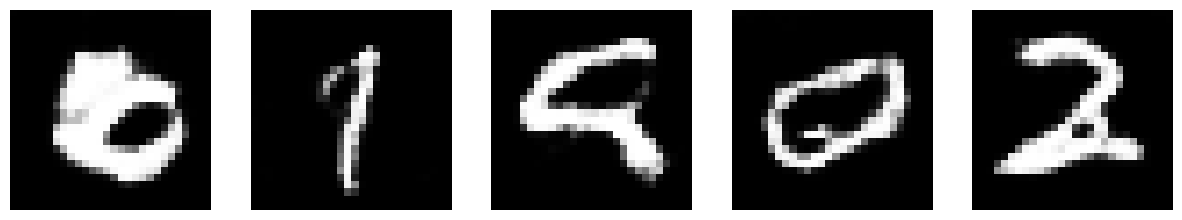

iter=110 | lossv=-0.37412893772125244 | lossT=0.7374631762504578
iter=120 | lossv=-0.23530936241149902 | lossT=0.5742812752723694
iter=130 | lossv=-0.16364608705043793 | lossT=-0.3145063519477844
iter=140 | lossv=-0.35789501667022705 | lossT=0.6731606721878052
iter=150 | lossv=-0.36163562536239624 | lossT=1.4345780611038208
iter=160 | lossv=-0.5587408542633057 | lossT=1.0683715343475342
iter=170 | lossv=-0.34247320890426636 | lossT=1.0430669784545898
iter=180 | lossv=-0.3488806486129761 | lossT=0.5334981679916382
iter=190 | lossv=-0.3977610170841217 | lossT=1.1304547786712646


In [8]:
dim_noise = 128
K = 12
N = 2000 #10_000
lbda_R1 = 0.2
lr_T = 2*1e-4
lr_v = 1e-4
h = 0.1

T_train,gen_img = training_sJKO_simple(dim_noise,K,N,train_loader,batch_size,lbda_R1,lr_v,lr_T,h,"KL","mnist")

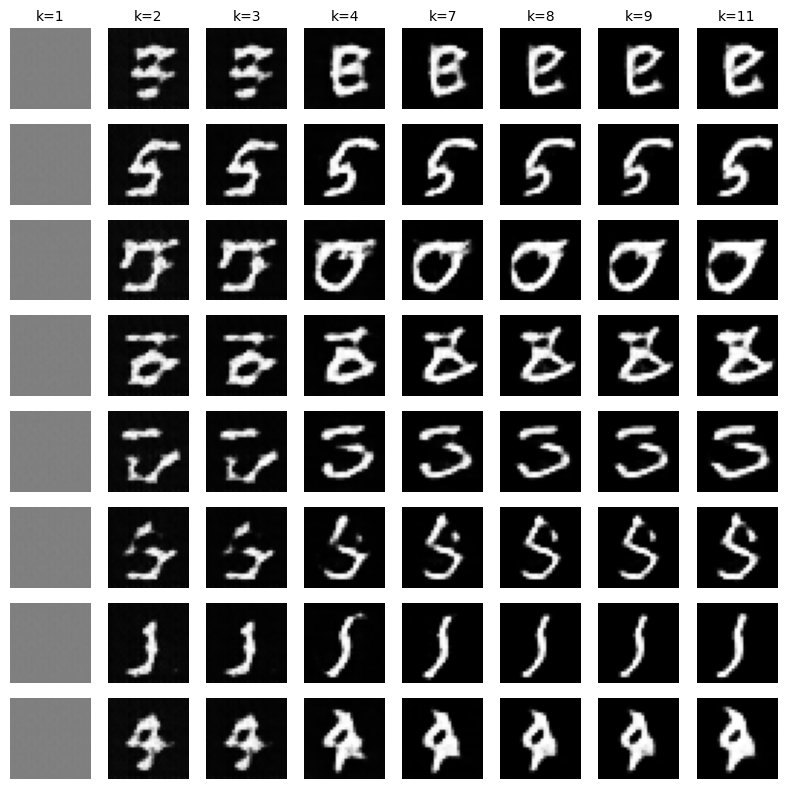

In [17]:
iters = [1,2,3,4,7,8,9,11]
n_rows = 8
n_cols = len(iters)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))




for i in range(n_rows):
    for j, it in enumerate(iters):
        img = gen_img[it][i]
        img = img.reshape((28,28))
        img = img*0.5 + 0.5
        axs[i, j].imshow(img.detach().cpu(), cmap='gray', vmin=0, vmax=1)
        axs[i, j].axis('off')



for j, it in enumerate(iters):
    axs[0, j].set_title(f"k={it}", fontsize=10)


#espacement
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

Step k=0:
iter=0 | lossv=0.05590209364891052 | lossT=10242.064453125


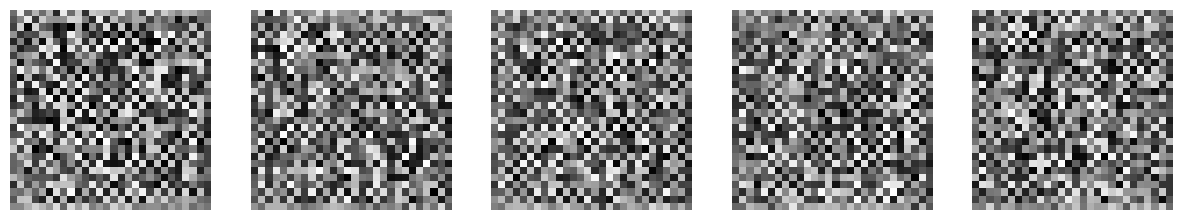

iter=10 | lossv=-5.286489009857178 | lossT=7598.69189453125


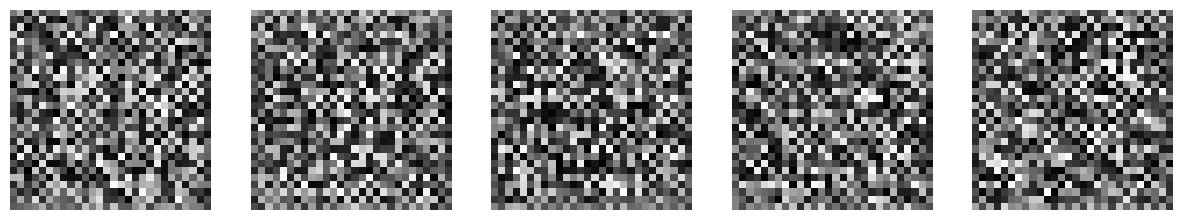

iter=20 | lossv=-9.017709732055664 | lossT=6558.7841796875


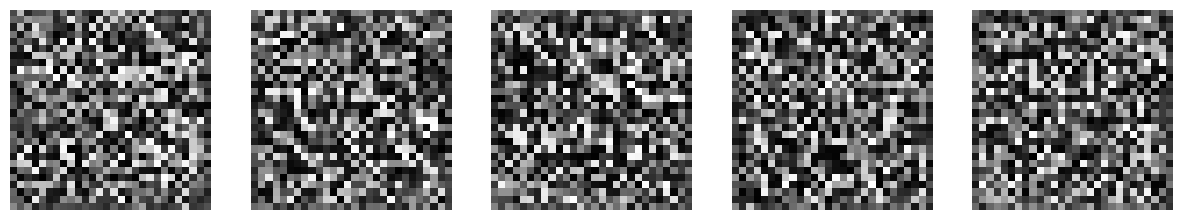

iter=30 | lossv=-11.757160186767578 | lossT=5999.4169921875


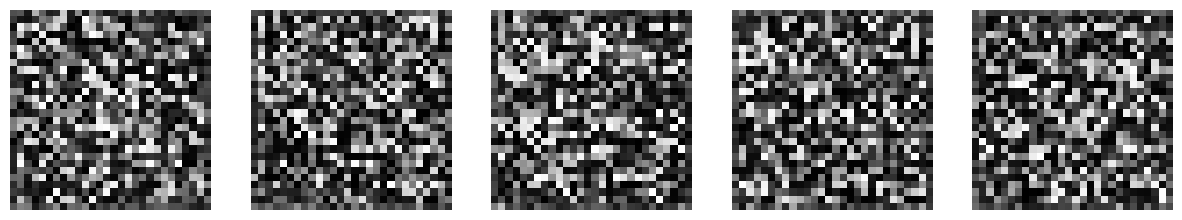

iter=40 | lossv=-13.92042064666748 | lossT=5669.46875


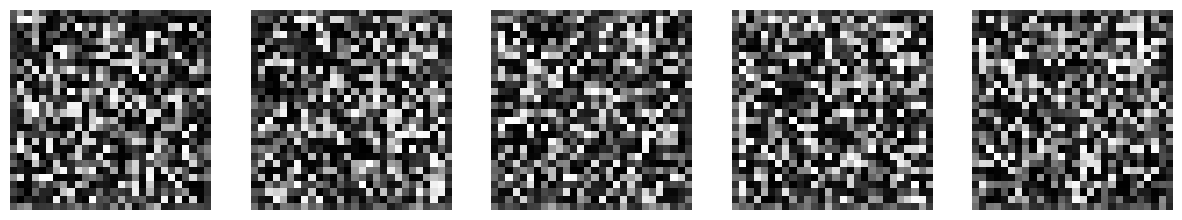

iter=50 | lossv=-15.846628189086914 | lossT=5482.02587890625


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11e2960c0>
Traceback (most recent call last):
  File "/Users/paulcaucheteux/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/paulcaucheteux/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/paulcaucheteux/anaconda3/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulcaucheteux/anaconda3/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulcaucheteux/anaconda3/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
dim_noise = 128
K = 10
N = 10_000 #10_000
lbda_R1 = 0.2
lr_T = 2*1e-4
lr_v = 1e-4
h = 0.1

T_train, gen_img = training_sJKO(dim_noise,K,N,train_loader,batch_size,lbda_R1,lr_v,lr_T,h,"KL","mnist")

In [ ]:
iters = [1,2,3,4,7,8,9,11]
n_rows = 8
n_cols = len(iters)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))




for i in range(n_rows):
    for j, it in enumerate(iters):
        img = gen_img[it][i]
        img = img.reshape((28,28))
        img = img*0.5 + 0.5
        axs[i, j].imshow(img.detach().cpu(), cmap='gray', vmin=0, vmax=1)
        axs[i, j].axis('off')



for j, it in enumerate(iters):
    axs[0, j].set_title(f"k={it}", fontsize=10)


#espacement
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

#### Jensen-Shanon

Step k=0:
iter=0 | lossv=1.8466811180114746 | lossT=7.199847221374512


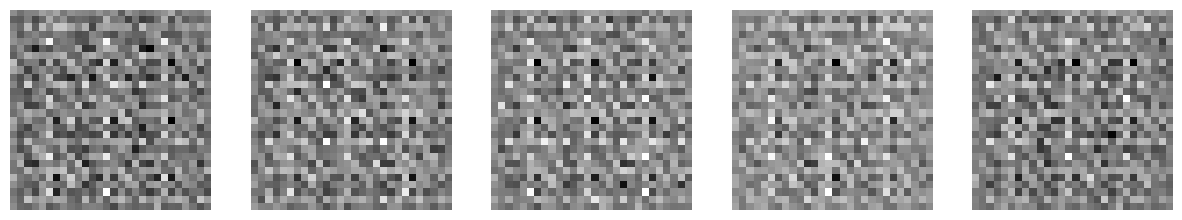

iter=10 | lossv=2.3823742866516113 | lossT=7.432894706726074
iter=20 | lossv=1.995406985282898 | lossT=7.630699157714844
iter=30 | lossv=5.433249473571777 | lossT=7.070874214172363
iter=40 | lossv=3.6752283573150635 | lossT=7.175892353057861
iter=50 | lossv=5.233534812927246 | lossT=7.020697593688965
iter=60 | lossv=3.6373088359832764 | lossT=6.928022384643555
iter=70 | lossv=3.1297030448913574 | lossT=7.23050594329834
iter=80 | lossv=3.0071210861206055 | lossT=7.197338104248047
iter=90 | lossv=2.3551666736602783 | lossT=7.416948318481445
iter=100 | lossv=2.267068862915039 | lossT=7.582709312438965


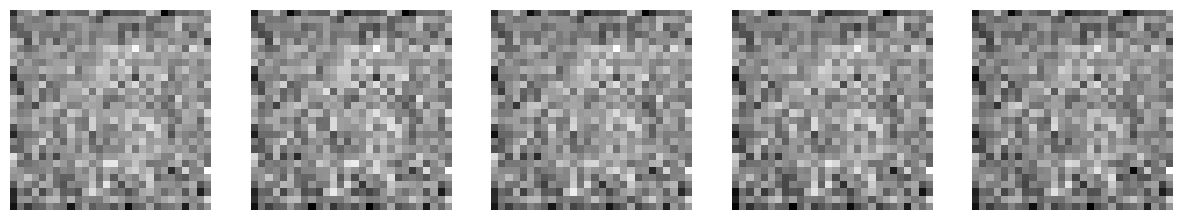

iter=110 | lossv=2.2900028228759766 | lossT=7.725224494934082
iter=120 | lossv=2.137214183807373 | lossT=7.786516189575195
iter=130 | lossv=1.6828246116638184 | lossT=7.831934928894043
iter=140 | lossv=1.4747227430343628 | lossT=7.9303412437438965
iter=150 | lossv=1.5024131536483765 | lossT=8.023841857910156
iter=160 | lossv=1.2832443714141846 | lossT=8.137460708618164
iter=170 | lossv=1.779008388519287 | lossT=7.736250877380371
iter=180 | lossv=1.597404956817627 | lossT=8.010520935058594
iter=190 | lossv=1.5858526229858398 | lossT=7.659085273742676
iter=200 | lossv=1.2999464273452759 | lossT=7.801309585571289


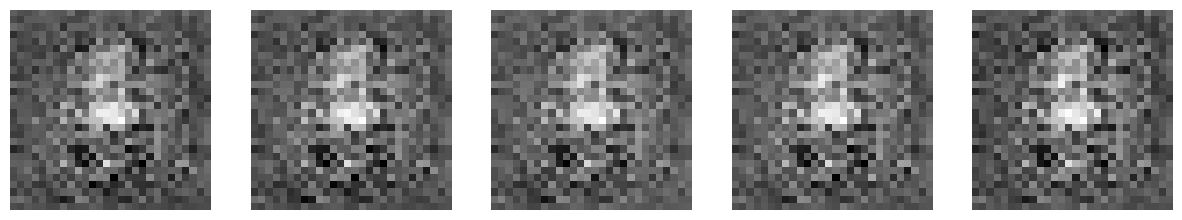

iter=210 | lossv=1.3470160961151123 | lossT=7.720685005187988
iter=220 | lossv=1.4302148818969727 | lossT=7.768004894256592
iter=230 | lossv=1.324713945388794 | lossT=7.630724906921387
iter=240 | lossv=1.231416940689087 | lossT=7.618708610534668
iter=250 | lossv=1.6192543506622314 | lossT=7.40614652633667
iter=260 | lossv=1.344446063041687 | lossT=7.529977321624756
iter=270 | lossv=15.529318809509277 | lossT=6.15306282043457
iter=280 | lossv=15.682575225830078 | lossT=6.140902042388916
iter=290 | lossv=15.679158210754395 | lossT=6.13637638092041
iter=300 | lossv=15.6759672164917 | lossT=6.138351917266846


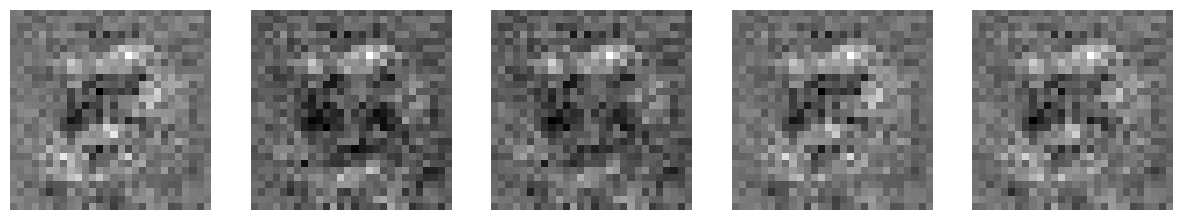

iter=310 | lossv=15.64842414855957 | lossT=6.105438232421875
iter=320 | lossv=15.674966812133789 | lossT=6.064781188964844
iter=330 | lossv=15.70821762084961 | lossT=6.16190242767334
iter=340 | lossv=15.725838661193848 | lossT=6.134922981262207
iter=350 | lossv=15.671353340148926 | lossT=6.135619640350342
iter=360 | lossv=15.629234313964844 | lossT=6.144512176513672
iter=370 | lossv=15.638847351074219 | lossT=6.123008728027344
iter=380 | lossv=15.632149696350098 | lossT=6.131826400756836
iter=390 | lossv=15.56689739227295 | lossT=6.093629837036133
iter=400 | lossv=15.566076278686523 | lossT=6.135451793670654


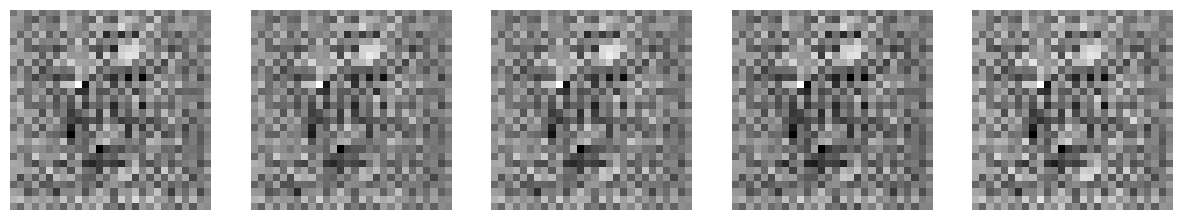

iter=410 | lossv=15.462160110473633 | lossT=6.128868103027344
iter=420 | lossv=15.307226181030273 | lossT=6.114249229431152
iter=430 | lossv=15.113388061523438 | lossT=6.12446928024292
iter=440 | lossv=14.793733596801758 | lossT=6.122162818908691
iter=450 | lossv=15.077462196350098 | lossT=6.11574649810791
iter=460 | lossv=14.744390487670898 | lossT=6.128701210021973
iter=470 | lossv=14.555438995361328 | lossT=6.121859073638916
iter=480 | lossv=14.56352424621582 | lossT=6.13129997253418
iter=490 | lossv=15.280858993530273 | lossT=6.1217498779296875
iter=500 | lossv=15.41845989227295 | lossT=6.154564380645752


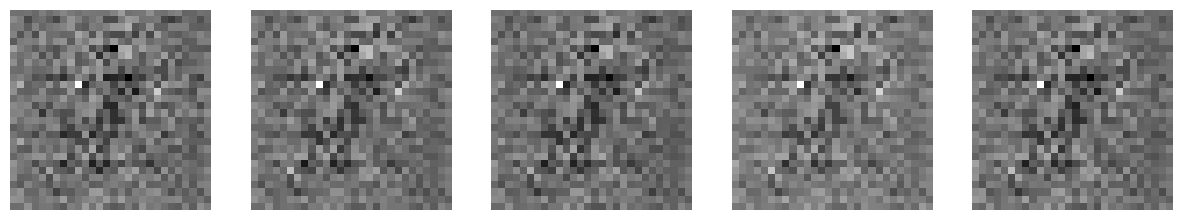

iter=510 | lossv=15.315824508666992 | lossT=6.137333869934082
iter=520 | lossv=15.179132461547852 | lossT=6.132168769836426
iter=530 | lossv=14.918357849121094 | lossT=6.141327857971191
iter=540 | lossv=14.891708374023438 | lossT=6.1233625411987305
iter=550 | lossv=14.52406120300293 | lossT=6.137202262878418
iter=560 | lossv=2.417043924331665 | lossT=7.05759859085083
iter=570 | lossv=1.9822267293930054 | lossT=7.242709159851074
iter=580 | lossv=1.4810492992401123 | lossT=7.471184730529785
iter=590 | lossv=1.1701196432113647 | lossT=7.45203161239624
iter=600 | lossv=1.3823049068450928 | lossT=7.34648323059082


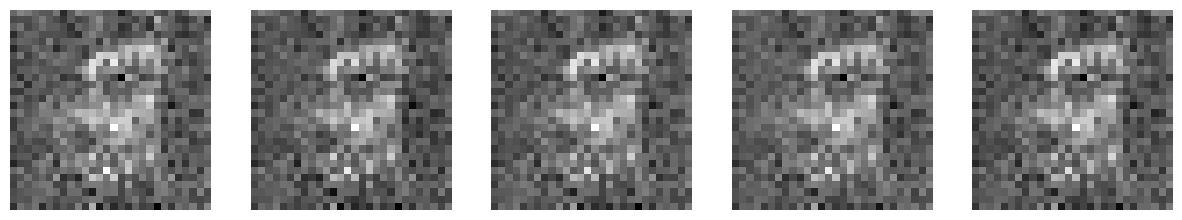

iter=610 | lossv=1.303438425064087 | lossT=7.641936779022217
iter=620 | lossv=1.1852858066558838 | lossT=7.620020389556885
iter=630 | lossv=7.573552131652832 | lossT=6.323809623718262
iter=640 | lossv=15.455126762390137 | lossT=6.1808624267578125
iter=650 | lossv=15.64242172241211 | lossT=6.138494491577148
iter=660 | lossv=15.567611694335938 | lossT=6.118529319763184
iter=670 | lossv=15.629486083984375 | lossT=6.11313533782959
iter=680 | lossv=15.56195068359375 | lossT=6.105708122253418
iter=690 | lossv=13.249860763549805 | lossT=6.217197895050049
iter=700 | lossv=15.609024047851562 | lossT=6.096238136291504


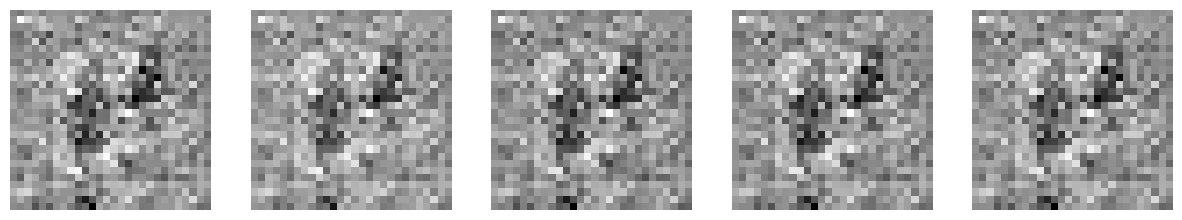

iter=710 | lossv=15.5372314453125 | lossT=6.133388042449951
iter=720 | lossv=15.428863525390625 | lossT=6.135157108306885
iter=730 | lossv=15.327804565429688 | lossT=6.121349811553955
iter=740 | lossv=15.115060806274414 | lossT=6.138161659240723
iter=750 | lossv=14.895550727844238 | lossT=6.1132330894470215
iter=760 | lossv=14.653329849243164 | lossT=6.153473377227783
iter=770 | lossv=2.027062177658081 | lossT=7.075803756713867
iter=780 | lossv=1.6580843925476074 | lossT=7.208457946777344
iter=790 | lossv=1.4088261127471924 | lossT=7.286190032958984
iter=800 | lossv=1.5774493217468262 | lossT=7.441459655761719


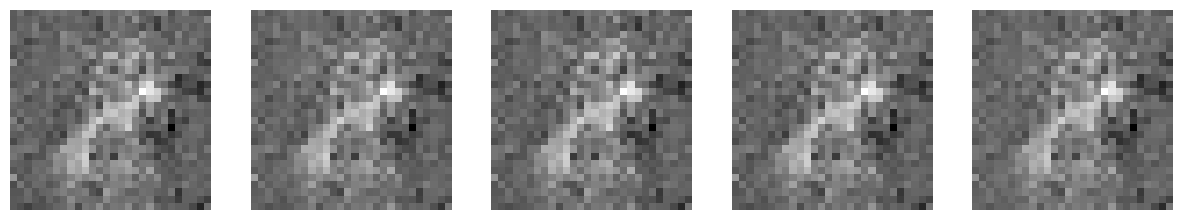

iter=810 | lossv=1.3397080898284912 | lossT=7.313106536865234
iter=820 | lossv=1.3003026247024536 | lossT=7.357954025268555
iter=830 | lossv=1.2823486328125 | lossT=7.518134117126465
iter=840 | lossv=1.1403543949127197 | lossT=7.330710411071777
iter=850 | lossv=7.019683837890625 | lossT=6.317349433898926
iter=860 | lossv=15.150945663452148 | lossT=6.117976188659668
iter=870 | lossv=15.168383598327637 | lossT=6.127363204956055
iter=880 | lossv=15.077072143554688 | lossT=6.138900279998779
iter=890 | lossv=3.1355857849121094 | lossT=6.556987285614014
iter=900 | lossv=3.2472927570343018 | lossT=6.56227970123291


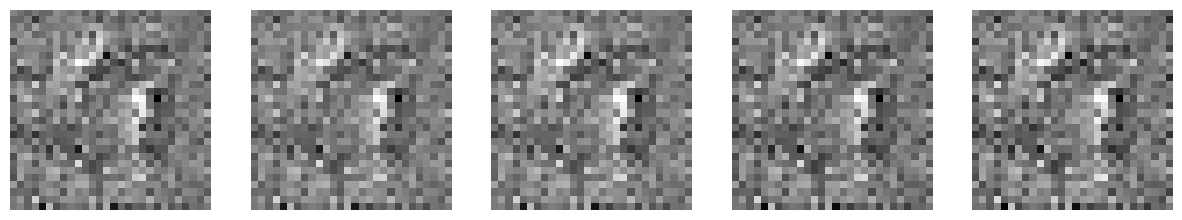

iter=910 | lossv=2.6939258575439453 | lossT=6.792800426483154
iter=920 | lossv=2.3952131271362305 | lossT=7.060515880584717
iter=930 | lossv=1.9243687391281128 | lossT=7.494138240814209
iter=940 | lossv=1.5297260284423828 | lossT=7.614371299743652
iter=950 | lossv=1.3031525611877441 | lossT=7.424943923950195
iter=960 | lossv=1.2128382921218872 | lossT=7.39537239074707
iter=970 | lossv=1.6170713901519775 | lossT=7.1987690925598145
iter=980 | lossv=1.311917781829834 | lossT=7.266963005065918
iter=990 | lossv=1.2443418502807617 | lossT=7.382758617401123
iter=1000 | lossv=1.061458706855774 | lossT=7.517457008361816


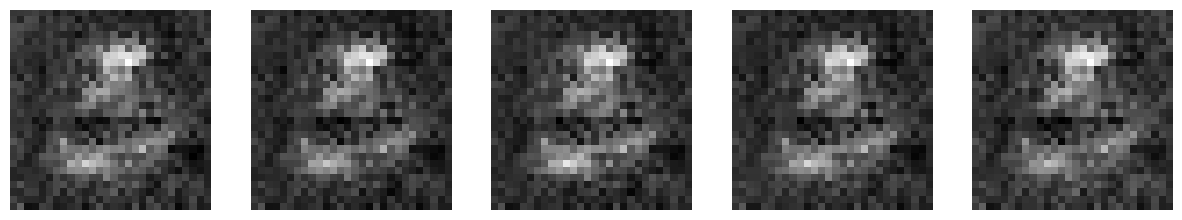

iter=1010 | lossv=1.1215598583221436 | lossT=7.490774154663086
iter=1020 | lossv=2.171603202819824 | lossT=7.132672309875488
iter=1030 | lossv=1.7170438766479492 | lossT=7.298278331756592
iter=1040 | lossv=1.4308903217315674 | lossT=7.224861145019531
iter=1050 | lossv=1.2699029445648193 | lossT=7.148704528808594
iter=1060 | lossv=1.2919760942459106 | lossT=7.411415100097656
iter=1070 | lossv=1.3395335674285889 | lossT=7.439620018005371
iter=1080 | lossv=1.3557000160217285 | lossT=7.154444694519043
iter=1090 | lossv=1.5327398777008057 | lossT=7.304800987243652
iter=1100 | lossv=1.2927985191345215 | lossT=7.234138011932373


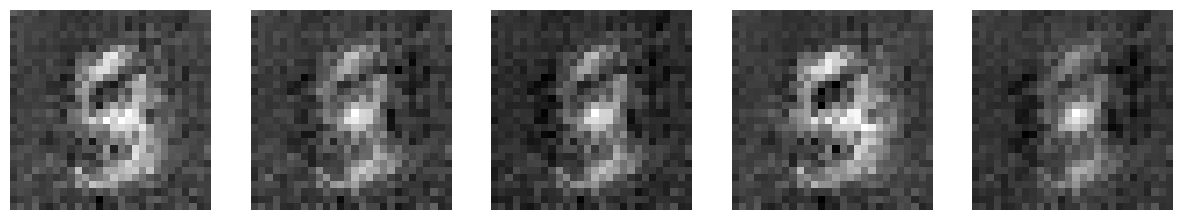

iter=1110 | lossv=1.2949641942977905 | lossT=7.121012210845947
iter=1120 | lossv=1.103838324546814 | lossT=7.273728370666504
iter=1130 | lossv=1.1835658550262451 | lossT=7.6087727546691895
iter=1140 | lossv=1.5044598579406738 | lossT=7.263955116271973
iter=1150 | lossv=1.3588975667953491 | lossT=7.402054786682129
iter=1160 | lossv=1.2647262811660767 | lossT=7.612851142883301
iter=1170 | lossv=1.0850253105163574 | lossT=7.280943870544434
iter=1180 | lossv=1.0454010963439941 | lossT=7.294299125671387
iter=1190 | lossv=1.2325003147125244 | lossT=7.185834884643555
iter=1200 | lossv=1.5081846714019775 | lossT=7.276268482208252


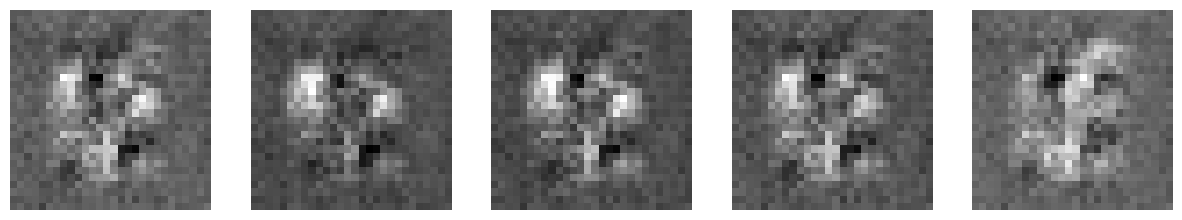

iter=1210 | lossv=1.083676815032959 | lossT=7.273446083068848
iter=1220 | lossv=0.9999014139175415 | lossT=7.4073286056518555
iter=1230 | lossv=1.4372680187225342 | lossT=7.276128768920898
iter=1240 | lossv=1.354671835899353 | lossT=7.143510818481445
iter=1250 | lossv=1.6535898447036743 | lossT=7.514279365539551
iter=1260 | lossv=1.5336077213287354 | lossT=7.253918647766113
iter=1270 | lossv=1.2105547189712524 | lossT=7.149074077606201
iter=1280 | lossv=1.6929179430007935 | lossT=7.713508605957031
iter=1290 | lossv=1.7363470792770386 | lossT=7.1680192947387695
iter=1300 | lossv=1.357642412185669 | lossT=7.196701526641846


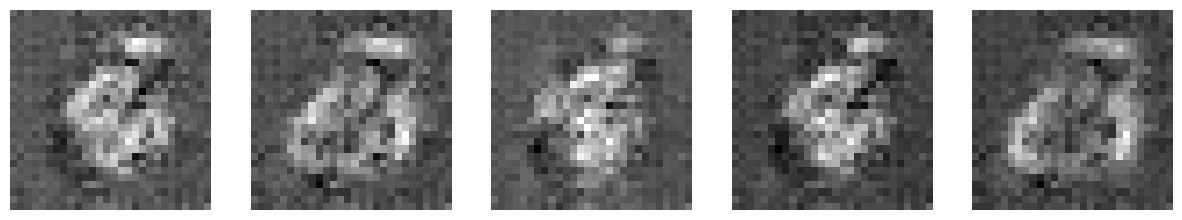

iter=1310 | lossv=2.0930752754211426 | lossT=7.2658586502075195
iter=1320 | lossv=2.87688946723938 | lossT=6.502895355224609
iter=1330 | lossv=2.385910987854004 | lossT=7.195038795471191
iter=1340 | lossv=2.1566061973571777 | lossT=7.444626808166504
iter=1350 | lossv=2.467386245727539 | lossT=6.87940788269043
iter=1360 | lossv=3.2966949939727783 | lossT=6.460175514221191
iter=1370 | lossv=2.6812586784362793 | lossT=6.684412956237793
iter=1380 | lossv=2.4976067543029785 | lossT=6.814964294433594
iter=1390 | lossv=2.1491401195526123 | lossT=7.038875579833984
iter=1400 | lossv=1.758359670639038 | lossT=7.387514114379883


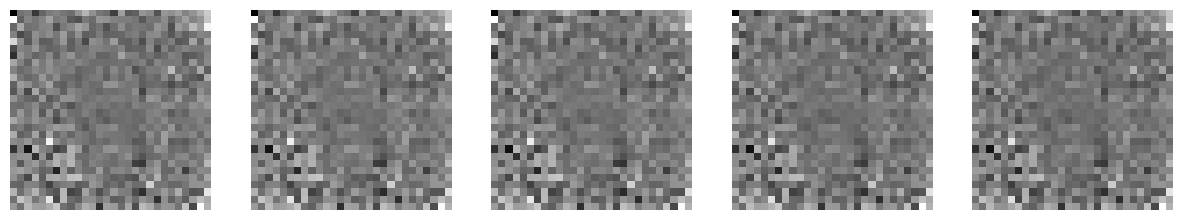

iter=1410 | lossv=1.4555320739746094 | lossT=7.60518217086792
iter=1420 | lossv=1.0272287130355835 | lossT=7.833946704864502
iter=1430 | lossv=1.2918829917907715 | lossT=7.815739154815674
iter=1440 | lossv=0.8506865501403809 | lossT=7.930509567260742
iter=1450 | lossv=1.2090319395065308 | lossT=7.838380813598633
iter=1460 | lossv=0.8144291639328003 | lossT=7.934970378875732
iter=1470 | lossv=0.8211413621902466 | lossT=7.511483192443848
iter=1480 | lossv=1.5774638652801514 | lossT=7.554533958435059
iter=1490 | lossv=1.3572540283203125 | lossT=7.438380241394043
Step k=1:
iter=0 | lossv=1.0821316242218018 | lossT=1.2101469039916992


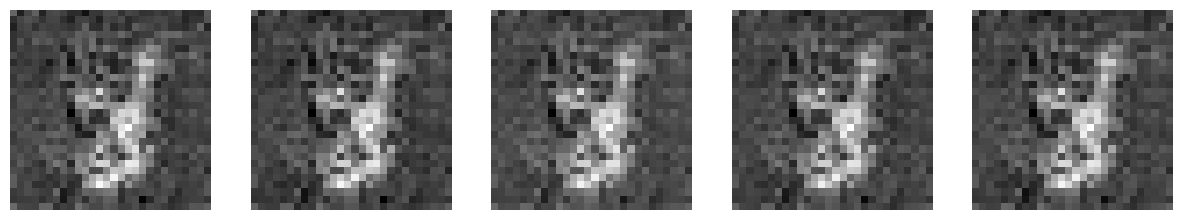

iter=10 | lossv=0.9442315101623535 | lossT=1.3550078868865967
iter=20 | lossv=1.1933116912841797 | lossT=1.5992307662963867
iter=30 | lossv=1.2228126525878906 | lossT=1.2051446437835693
iter=40 | lossv=1.6123888492584229 | lossT=1.756274938583374
iter=50 | lossv=1.8455389738082886 | lossT=1.0846946239471436
iter=60 | lossv=1.770777702331543 | lossT=1.1645077466964722
iter=70 | lossv=1.4900217056274414 | lossT=1.318162202835083
iter=80 | lossv=1.2135474681854248 | lossT=1.376450777053833
iter=90 | lossv=1.0466110706329346 | lossT=1.348637580871582
iter=100 | lossv=1.0807849168777466 | lossT=1.1711803674697876


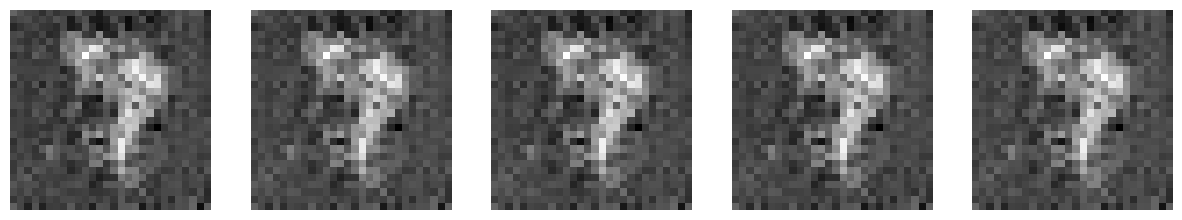

iter=110 | lossv=1.3746659755706787 | lossT=1.6101449728012085
iter=120 | lossv=0.9883210062980652 | lossT=1.219190001487732
iter=130 | lossv=1.222691535949707 | lossT=1.493646502494812
iter=140 | lossv=1.029935359954834 | lossT=1.2959003448486328
iter=150 | lossv=1.5997029542922974 | lossT=1.459686517715454
iter=160 | lossv=1.2117030620574951 | lossT=1.235753059387207
iter=170 | lossv=1.459362506866455 | lossT=1.6183897256851196
iter=180 | lossv=1.5807526111602783 | lossT=1.1799139976501465
iter=190 | lossv=1.1177470684051514 | lossT=1.2500463724136353
iter=200 | lossv=1.1034765243530273 | lossT=1.3447999954223633


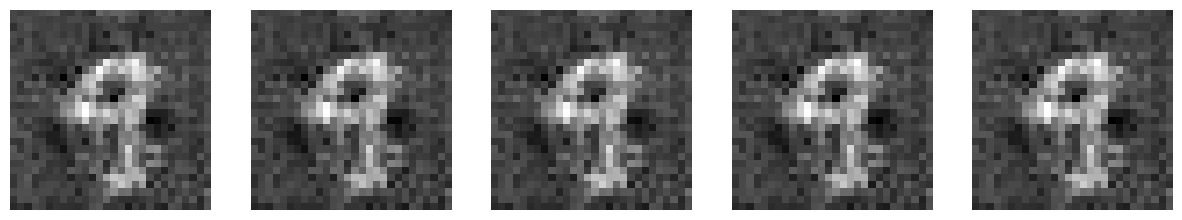

iter=210 | lossv=0.9585965275764465 | lossT=1.2333775758743286
iter=220 | lossv=0.9531151652336121 | lossT=1.5344791412353516
iter=230 | lossv=1.026108980178833 | lossT=1.6897389888763428
iter=240 | lossv=1.161745309829712 | lossT=1.130811095237732
iter=250 | lossv=0.9803830981254578 | lossT=1.1580629348754883
iter=260 | lossv=0.8418819904327393 | lossT=1.620133638381958
iter=270 | lossv=1.2914338111877441 | lossT=1.5472848415374756
iter=280 | lossv=1.549957036972046 | lossT=1.065184473991394
iter=290 | lossv=1.3042569160461426 | lossT=1.1211309432983398
Step k=2:
iter=0 | lossv=1.0455025434494019 | lossT=1.1591876745224


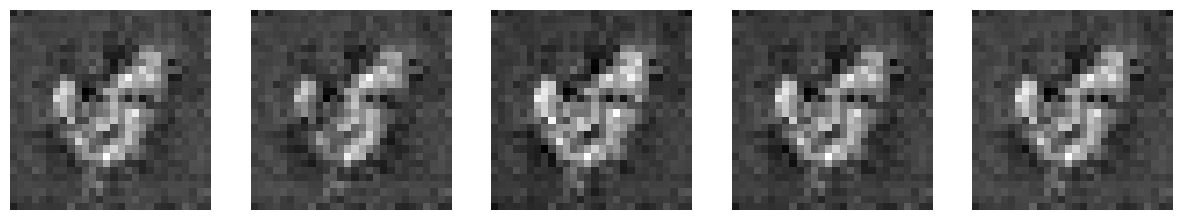

iter=10 | lossv=1.0444746017456055 | lossT=1.0922632217407227
iter=20 | lossv=1.1444274187088013 | lossT=1.1868598461151123
iter=30 | lossv=1.1025422811508179 | lossT=1.478698492050171
iter=40 | lossv=0.8986431360244751 | lossT=1.2951269149780273
iter=50 | lossv=1.0429115295410156 | lossT=1.235253930091858
iter=60 | lossv=1.0246751308441162 | lossT=1.4478788375854492
iter=70 | lossv=1.7258856296539307 | lossT=1.6987345218658447
iter=80 | lossv=1.9229378700256348 | lossT=1.0996142625808716
iter=90 | lossv=2.105466842651367 | lossT=0.8401193022727966
iter=100 | lossv=1.9145896434783936 | lossT=1.0309486389160156


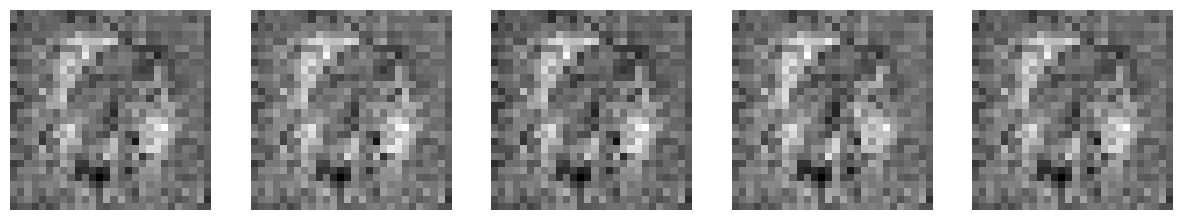

iter=110 | lossv=1.5565521717071533 | lossT=1.2435154914855957
iter=120 | lossv=1.652793288230896 | lossT=1.4954559803009033
iter=130 | lossv=2.912348985671997 | lossT=0.5801620483398438
iter=140 | lossv=3.6348490715026855 | lossT=0.3653091490268707
iter=150 | lossv=3.0933611392974854 | lossT=0.5455257892608643
iter=160 | lossv=2.831611156463623 | lossT=0.6918784379959106
iter=170 | lossv=2.5893893241882324 | lossT=0.8256428837776184
iter=180 | lossv=2.312748432159424 | lossT=1.0543806552886963
iter=190 | lossv=1.9587641954421997 | lossT=1.338834285736084
iter=200 | lossv=1.6175217628479004 | lossT=1.5916110277175903


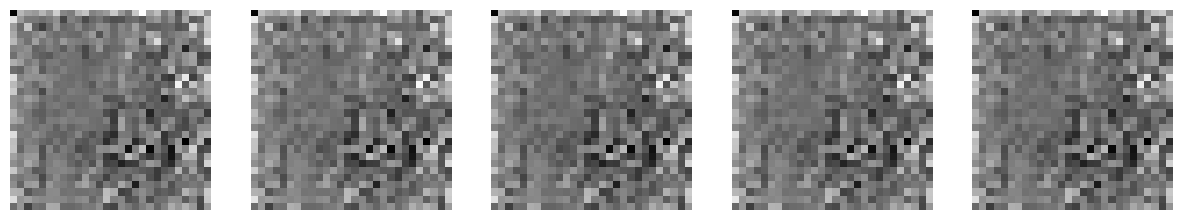

iter=210 | lossv=1.212320327758789 | lossT=1.8853758573532104
iter=220 | lossv=0.8483286499977112 | lossT=2.2307608127593994
iter=230 | lossv=0.9492667317390442 | lossT=2.209764003753662
iter=240 | lossv=1.0607393980026245 | lossT=1.467465877532959
iter=250 | lossv=0.9026489853858948 | lossT=1.2844698429107666
iter=260 | lossv=1.3400602340698242 | lossT=1.2198448181152344
iter=270 | lossv=0.9065756797790527 | lossT=1.297816514968872
iter=280 | lossv=1.3230799436569214 | lossT=1.0306237936019897
iter=290 | lossv=1.0668294429779053 | lossT=1.110518455505371
Step k=3:
iter=0 | lossv=0.991581916809082 | lossT=1.1993893384933472


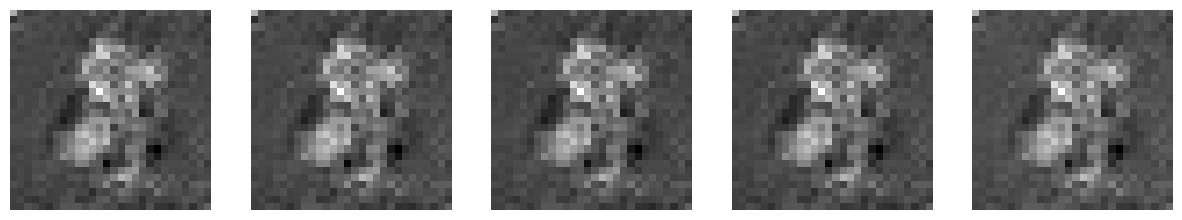

iter=10 | lossv=1.0023386478424072 | lossT=1.4435181617736816
iter=20 | lossv=1.2262344360351562 | lossT=1.8182827234268188
iter=30 | lossv=1.3374314308166504 | lossT=1.0843044519424438
iter=40 | lossv=1.14383864402771 | lossT=1.229998230934143
iter=50 | lossv=1.2190349102020264 | lossT=1.6168742179870605
iter=60 | lossv=0.912245512008667 | lossT=1.4696784019470215
iter=70 | lossv=0.7882602214813232 | lossT=1.4165204763412476
iter=80 | lossv=16.047134399414062 | lossT=1.5039019584655762
iter=90 | lossv=1.687570333480835 | lossT=0.930862307548523
iter=100 | lossv=2.0230932235717773 | lossT=0.6167992949485779


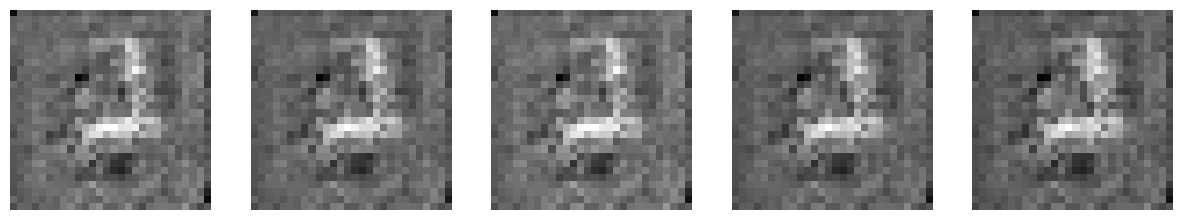

iter=110 | lossv=2.3515138626098633 | lossT=0.4321131706237793
iter=120 | lossv=2.4009788036346436 | lossT=0.45865142345428467
iter=130 | lossv=2.3750216960906982 | lossT=0.5251582264900208
iter=140 | lossv=2.0385971069335938 | lossT=0.6987259387969971
iter=150 | lossv=1.80204439163208 | lossT=0.8719630241394043
iter=160 | lossv=1.71451997756958 | lossT=1.072360634803772
iter=170 | lossv=1.504239559173584 | lossT=1.1911816596984863
iter=180 | lossv=1.3094658851623535 | lossT=1.2604246139526367
iter=190 | lossv=1.076921820640564 | lossT=1.3234273195266724
iter=200 | lossv=0.9559152126312256 | lossT=1.3880712985992432


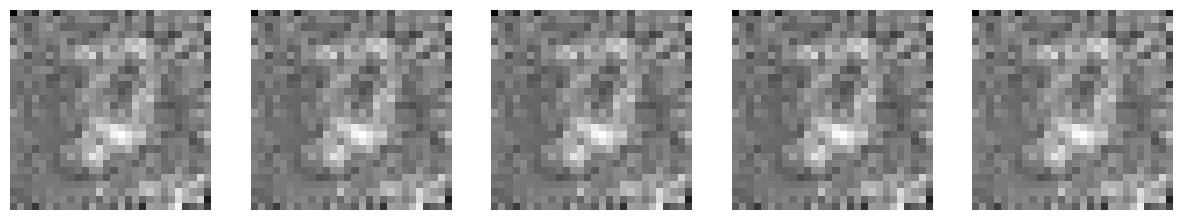

iter=210 | lossv=1.2560174465179443 | lossT=1.4322733879089355
iter=220 | lossv=1.099433183670044 | lossT=1.17891526222229
iter=230 | lossv=1.2862186431884766 | lossT=1.2585937976837158
iter=240 | lossv=0.9581321477890015 | lossT=1.3676774501800537
iter=250 | lossv=0.8197530508041382 | lossT=1.4554359912872314
iter=260 | lossv=1.1404166221618652 | lossT=1.8354523181915283
iter=270 | lossv=1.4134738445281982 | lossT=1.5727756023406982
iter=280 | lossv=1.2568068504333496 | lossT=1.250869870185852
iter=290 | lossv=0.9006983041763306 | lossT=1.4363749027252197
Step k=4:
iter=0 | lossv=0.7581137418746948 | lossT=1.4716726541519165


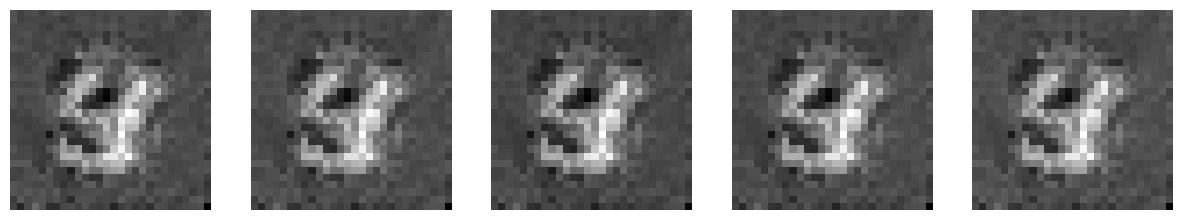

iter=10 | lossv=0.8200852870941162 | lossT=1.4554775953292847
iter=20 | lossv=0.8054308891296387 | lossT=1.620357871055603
iter=30 | lossv=1.242856740951538 | lossT=1.449037790298462
iter=40 | lossv=0.9397081732749939 | lossT=1.4021949768066406
iter=50 | lossv=1.6572649478912354 | lossT=1.4813275337219238
iter=60 | lossv=1.4678778648376465 | lossT=1.232503056526184
iter=70 | lossv=1.032723307609558 | lossT=1.6096925735473633
iter=80 | lossv=1.5874053239822388 | lossT=1.4725874662399292
iter=90 | lossv=2.0222158432006836 | lossT=1.0535333156585693
iter=100 | lossv=1.7080587148666382 | lossT=1.3137059211730957


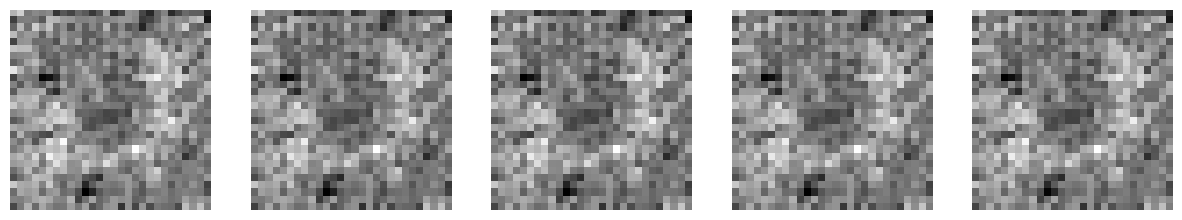

iter=110 | lossv=1.3395636081695557 | lossT=1.5258088111877441
iter=120 | lossv=0.9241606593132019 | lossT=1.6048961877822876
iter=130 | lossv=0.9266385436058044 | lossT=1.5146093368530273
iter=140 | lossv=0.8908026814460754 | lossT=1.3132872581481934
iter=150 | lossv=0.8083490133285522 | lossT=1.5219584703445435
iter=160 | lossv=0.7660430669784546 | lossT=1.6725106239318848
iter=170 | lossv=1.4262685775756836 | lossT=1.9539337158203125
iter=180 | lossv=1.1744873523712158 | lossT=1.4395155906677246
iter=190 | lossv=1.0502641201019287 | lossT=1.35097336769104
iter=200 | lossv=0.9138708114624023 | lossT=1.2988874912261963


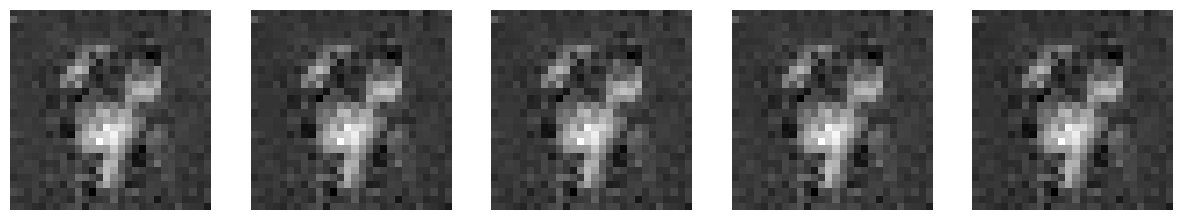

iter=210 | lossv=1.1729360818862915 | lossT=1.663203239440918
iter=220 | lossv=0.8434793949127197 | lossT=1.4296751022338867
iter=230 | lossv=0.9294145107269287 | lossT=1.7844032049179077
iter=240 | lossv=1.5846409797668457 | lossT=1.6968330144882202
iter=250 | lossv=1.7757753133773804 | lossT=1.1631213426589966
iter=260 | lossv=2.255155563354492 | lossT=0.630561113357544
iter=270 | lossv=5.456887245178223 | lossT=0.2716342508792877
iter=280 | lossv=3.151291847229004 | lossT=0.34101343154907227
iter=290 | lossv=3.0109238624572754 | lossT=0.37435176968574524
Step k=5:
iter=0 | lossv=2.7249462604522705 | lossT=0.3696806728839874


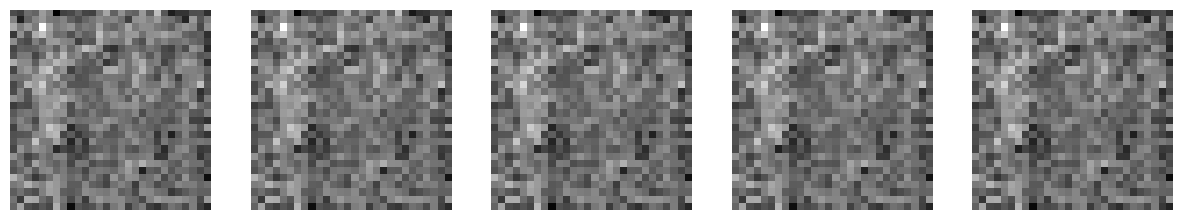

iter=10 | lossv=2.4091477394104004 | lossT=0.48929744958877563
iter=20 | lossv=2.0929183959960938 | lossT=0.6897280812263489
iter=30 | lossv=1.8447229862213135 | lossT=0.9176792502403259
iter=40 | lossv=1.691831350326538 | lossT=1.0810346603393555
iter=50 | lossv=1.400719404220581 | lossT=1.3087152242660522
iter=60 | lossv=1.1450906991958618 | lossT=1.5183154344558716
iter=70 | lossv=1.0779705047607422 | lossT=1.6952553987503052
iter=80 | lossv=3.003497838973999 | lossT=1.8100037574768066
iter=90 | lossv=1.8221793174743652 | lossT=1.347330927848816
iter=100 | lossv=1.8297737836837769 | lossT=1.2548243999481201


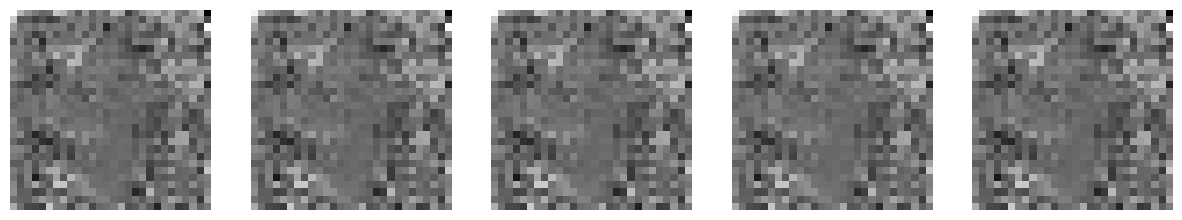

iter=110 | lossv=1.7217060327529907 | lossT=1.380687952041626
iter=120 | lossv=1.510583758354187 | lossT=1.6467784643173218
iter=130 | lossv=1.291609764099121 | lossT=1.903181791305542
iter=140 | lossv=1.1001415252685547 | lossT=2.1136889457702637
iter=150 | lossv=1.010940670967102 | lossT=2.034379482269287
iter=160 | lossv=0.9859228134155273 | lossT=1.8534839153289795
iter=170 | lossv=1.7432732582092285 | lossT=1.585078239440918
iter=180 | lossv=2.118377685546875 | lossT=0.859870195388794
iter=190 | lossv=2.2306761741638184 | lossT=0.7545869946479797
iter=200 | lossv=2.096587896347046 | lossT=0.8756678104400635


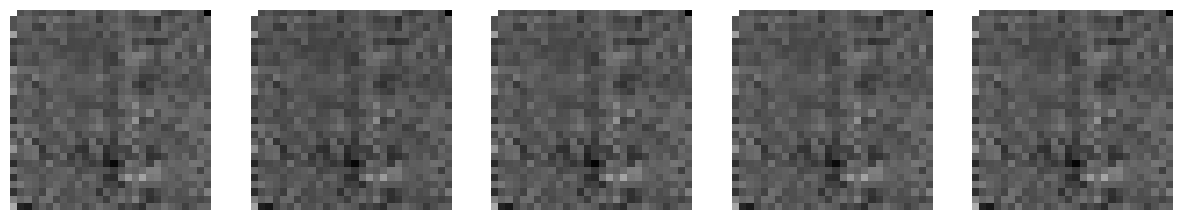

iter=210 | lossv=1.9593114852905273 | lossT=0.9681388735771179
iter=220 | lossv=1.7497444152832031 | lossT=1.103459358215332
iter=230 | lossv=1.4501084089279175 | lossT=1.2881078720092773
iter=240 | lossv=1.0412508249282837 | lossT=1.636237382888794
iter=250 | lossv=0.9652178883552551 | lossT=1.9467997550964355
iter=260 | lossv=0.7098545432090759 | lossT=2.1437184810638428
iter=270 | lossv=0.6148848533630371 | lossT=2.105502128601074
iter=280 | lossv=0.5630171298980713 | lossT=2.0209708213806152
iter=290 | lossv=0.9032666087150574 | lossT=1.2814494371414185
Step k=6:
iter=0 | lossv=0.8188653588294983 | lossT=1.1766583919525146


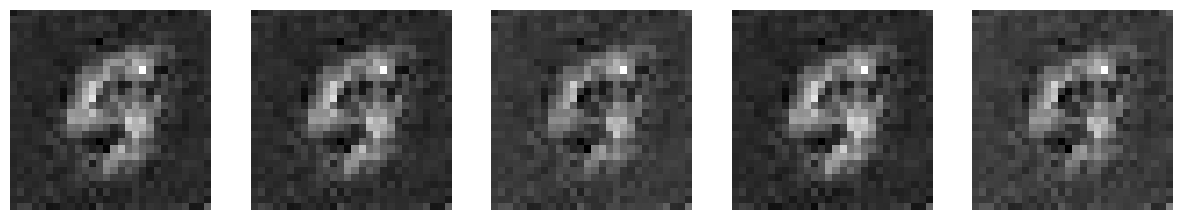

iter=10 | lossv=0.8271977305412292 | lossT=1.5386943817138672
iter=20 | lossv=1.4763543605804443 | lossT=1.7741079330444336
iter=30 | lossv=1.3869085311889648 | lossT=1.1710319519042969
iter=40 | lossv=1.1368643045425415 | lossT=1.2839220762252808
iter=50 | lossv=1.079723596572876 | lossT=1.4746694564819336
iter=60 | lossv=0.8704976439476013 | lossT=1.322482705116272
iter=70 | lossv=0.8556364178657532 | lossT=1.2889683246612549
iter=80 | lossv=0.7681167721748352 | lossT=1.4004266262054443
iter=90 | lossv=1.095162272453308 | lossT=1.7493042945861816
iter=100 | lossv=1.3378766775131226 | lossT=1.8482096195220947


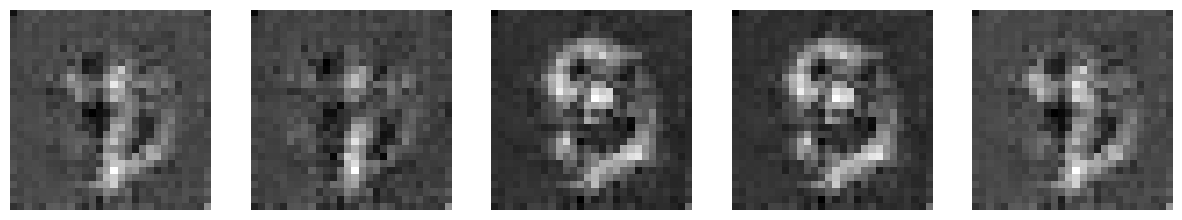

iter=110 | lossv=0.9788621068000793 | lossT=1.55096435546875
iter=120 | lossv=1.4356966018676758 | lossT=1.7081341743469238
iter=130 | lossv=1.103968620300293 | lossT=1.1734602451324463
iter=140 | lossv=0.8439549207687378 | lossT=1.298296332359314
iter=150 | lossv=0.8462890982627869 | lossT=1.3699467182159424
iter=160 | lossv=1.19675874710083 | lossT=1.504321813583374
iter=170 | lossv=0.9572950601577759 | lossT=1.3768301010131836
iter=180 | lossv=0.8625109195709229 | lossT=1.3596813678741455
iter=190 | lossv=1.494248390197754 | lossT=1.6215534210205078
iter=200 | lossv=1.6223067045211792 | lossT=1.2247164249420166


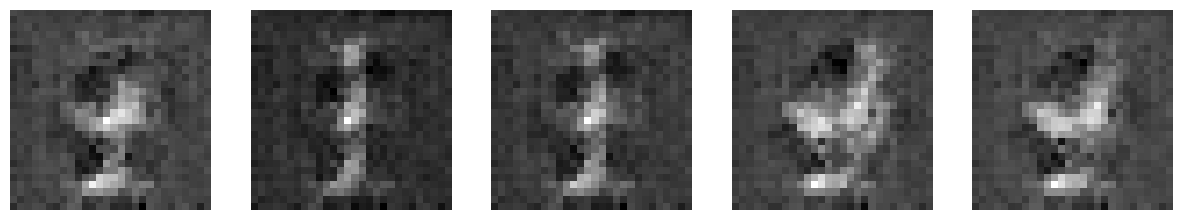

iter=210 | lossv=1.6634488105773926 | lossT=1.1019270420074463
iter=220 | lossv=1.7475436925888062 | lossT=0.9350974559783936
iter=230 | lossv=1.7646183967590332 | lossT=0.884955644607544
iter=240 | lossv=1.7148407697677612 | lossT=0.9605420827865601
iter=250 | lossv=1.507237195968628 | lossT=1.067394495010376
iter=260 | lossv=1.3203692436218262 | lossT=1.223129153251648
iter=270 | lossv=1.1565070152282715 | lossT=1.2026317119598389
iter=280 | lossv=0.9877859354019165 | lossT=1.3328847885131836
iter=290 | lossv=0.906558096408844 | lossT=1.4182296991348267
Step k=7:
iter=0 | lossv=0.8525770902633667 | lossT=1.5832440853118896


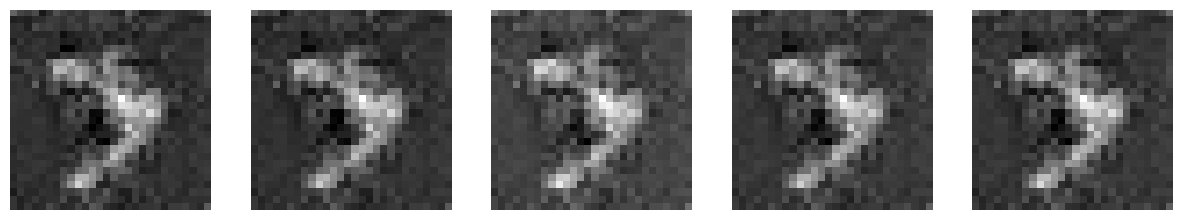

iter=10 | lossv=0.8025448322296143 | lossT=1.4662368297576904
iter=20 | lossv=0.8344606161117554 | lossT=1.4387904405593872
iter=30 | lossv=0.8598049879074097 | lossT=1.436211347579956
iter=40 | lossv=1.3263911008834839 | lossT=1.6232457160949707
iter=50 | lossv=1.0404560565948486 | lossT=1.2958993911743164
iter=60 | lossv=0.8601759076118469 | lossT=1.4777026176452637
iter=70 | lossv=0.7512181997299194 | lossT=1.4531667232513428
iter=80 | lossv=1.3186067342758179 | lossT=1.4948915243148804
iter=90 | lossv=1.3326973915100098 | lossT=1.0811681747436523
iter=100 | lossv=1.4168592691421509 | lossT=1.9688692092895508


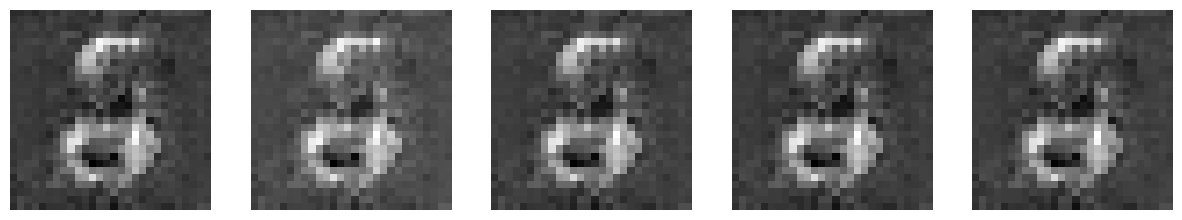

iter=110 | lossv=1.77638840675354 | lossT=1.6734588146209717
iter=120 | lossv=1.5319359302520752 | lossT=1.3956693410873413
iter=130 | lossv=1.2681291103363037 | lossT=1.3508493900299072
iter=140 | lossv=0.9991440176963806 | lossT=1.4091925621032715
iter=150 | lossv=0.9231145977973938 | lossT=1.3541302680969238
iter=160 | lossv=0.9073808193206787 | lossT=1.4919044971466064
iter=170 | lossv=0.8071092367172241 | lossT=1.5239337682724
iter=180 | lossv=0.8073567748069763 | lossT=1.39125394821167
iter=190 | lossv=0.8061502575874329 | lossT=1.576478123664856
iter=200 | lossv=1.1654767990112305 | lossT=1.607548713684082


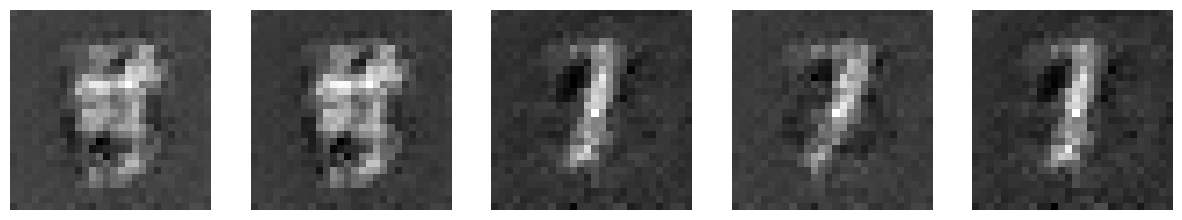

iter=210 | lossv=1.3841043710708618 | lossT=1.43165922164917
iter=220 | lossv=0.8695401549339294 | lossT=1.3813380002975464
iter=230 | lossv=0.8673616051673889 | lossT=1.359646201133728
iter=240 | lossv=0.7874432802200317 | lossT=1.5371001958847046
iter=250 | lossv=0.9129796624183655 | lossT=1.3664379119873047
iter=260 | lossv=1.6371650695800781 | lossT=1.7294496297836304
iter=270 | lossv=1.8172870874404907 | lossT=1.2078747749328613
iter=280 | lossv=2.06327223777771 | lossT=0.8835753202438354
iter=290 | lossv=2.2084779739379883 | lossT=0.7049016952514648
Step k=8:
iter=0 | lossv=2.212177276611328 | lossT=0.6100227236747742


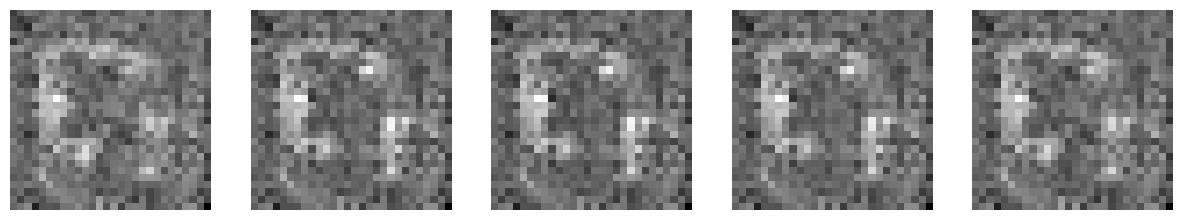

iter=10 | lossv=2.0846192836761475 | lossT=0.7894070148468018
iter=20 | lossv=1.8747479915618896 | lossT=1.0029091835021973
iter=30 | lossv=1.630933165550232 | lossT=1.2311863899230957
iter=40 | lossv=1.410300612449646 | lossT=1.4678175449371338
iter=50 | lossv=1.157278060913086 | lossT=1.6125082969665527
iter=60 | lossv=1.8084830045700073 | lossT=1.827580213546753
iter=70 | lossv=1.963923692703247 | lossT=1.3993582725524902
iter=80 | lossv=1.8060193061828613 | lossT=1.2985175848007202
iter=90 | lossv=1.3100366592407227 | lossT=1.675615906715393
iter=100 | lossv=0.7703886032104492 | lossT=2.049591541290283


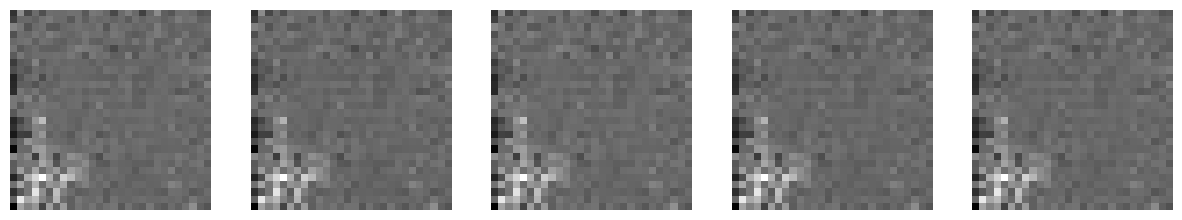

iter=110 | lossv=1.9953011274337769 | lossT=2.2922542095184326
iter=120 | lossv=1.4594213962554932 | lossT=1.8777269124984741
iter=130 | lossv=1.507547378540039 | lossT=1.5172572135925293
iter=140 | lossv=1.5965681076049805 | lossT=1.1129015684127808
iter=150 | lossv=1.6285241842269897 | lossT=1.003231406211853
iter=160 | lossv=1.294586181640625 | lossT=1.2577084302902222
iter=170 | lossv=1.0348414182662964 | lossT=1.4020419120788574
iter=180 | lossv=1.3311450481414795 | lossT=1.485011339187622
iter=190 | lossv=1.1677439212799072 | lossT=1.3373337984085083
iter=200 | lossv=0.84880530834198 | lossT=1.391431212425232


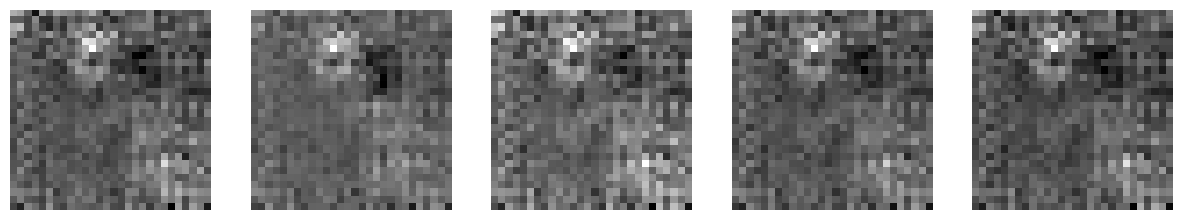

iter=210 | lossv=0.7152173519134521 | lossT=1.4061450958251953
iter=220 | lossv=0.9820491075515747 | lossT=1.36899733543396
iter=230 | lossv=0.7383555173873901 | lossT=1.327140212059021
iter=240 | lossv=0.7291768789291382 | lossT=1.3468477725982666
iter=250 | lossv=1.3739581108093262 | lossT=1.3087303638458252
iter=260 | lossv=1.6845874786376953 | lossT=1.1885287761688232
iter=270 | lossv=1.6934500932693481 | lossT=1.1565940380096436
iter=280 | lossv=1.653381109237671 | lossT=1.1040256023406982
iter=290 | lossv=1.6065785884857178 | lossT=1.1001702547073364
Step k=9:
iter=0 | lossv=1.4763679504394531 | lossT=1.039076328277588


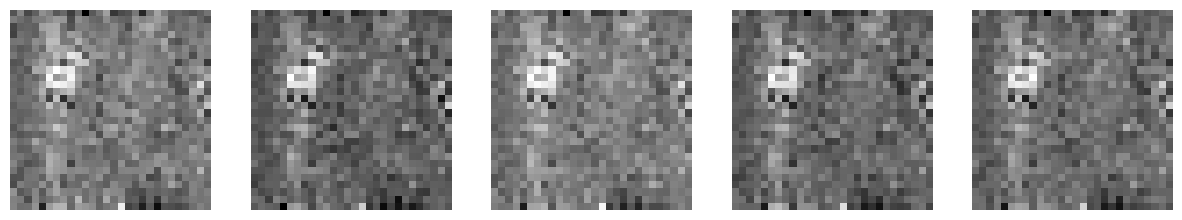

iter=10 | lossv=1.3545640707015991 | lossT=1.0352178812026978
iter=20 | lossv=1.1503578424453735 | lossT=0.9898923635482788
iter=30 | lossv=1.47743558883667 | lossT=1.231689691543579
iter=40 | lossv=1.3830628395080566 | lossT=1.0176188945770264
iter=50 | lossv=1.1393736600875854 | lossT=1.0199518203735352
iter=60 | lossv=0.9902982711791992 | lossT=1.004136323928833
iter=70 | lossv=0.8533350229263306 | lossT=1.035982370376587
iter=80 | lossv=1.2797907590866089 | lossT=1.114243745803833
iter=90 | lossv=1.0260145664215088 | lossT=1.0899989604949951
iter=100 | lossv=0.9292156100273132 | lossT=1.0834779739379883


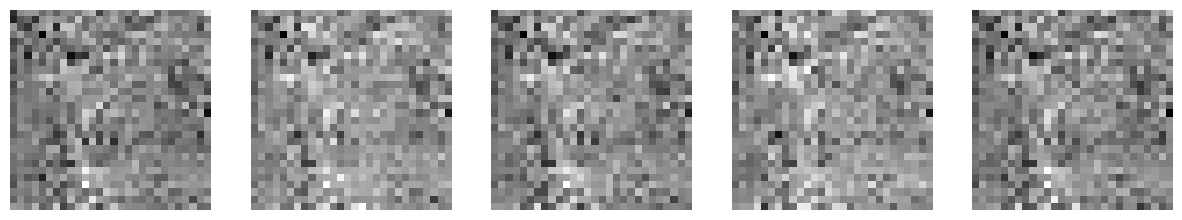

iter=110 | lossv=1.5096120834350586 | lossT=1.3104500770568848
iter=120 | lossv=1.4325445890426636 | lossT=1.1137683391571045
iter=130 | lossv=1.2019027471542358 | lossT=1.0323450565338135
iter=140 | lossv=0.965286135673523 | lossT=1.1729837656021118
iter=150 | lossv=0.9879715442657471 | lossT=1.149181604385376
iter=160 | lossv=0.8272601366043091 | lossT=1.11092209815979
iter=170 | lossv=0.7150559425354004 | lossT=1.1745531558990479
iter=180 | lossv=0.7102695107460022 | lossT=1.993334412574768
iter=190 | lossv=1.3544307947158813 | lossT=1.266791820526123
iter=200 | lossv=1.2035837173461914 | lossT=1.419068455696106


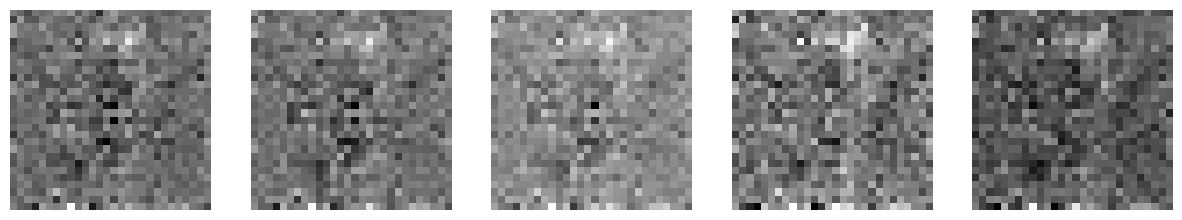

iter=210 | lossv=0.9637293219566345 | lossT=1.1947039365768433
iter=220 | lossv=2.8691558837890625 | lossT=1.2957344055175781
iter=230 | lossv=1.6570861339569092 | lossT=1.2322933673858643
iter=240 | lossv=1.6140499114990234 | lossT=1.1418788433074951
iter=250 | lossv=1.553120732307434 | lossT=1.461946964263916
iter=260 | lossv=1.469553828239441 | lossT=2.544386625289917
iter=270 | lossv=1.3433805704116821 | lossT=1.1282027959823608
iter=280 | lossv=1.082537293434143 | lossT=1.2305089235305786
iter=290 | lossv=1.1744654178619385 | lossT=1.1163530349731445
Step k=10:
iter=0 | lossv=0.9414926767349243 | lossT=1.131996750831604


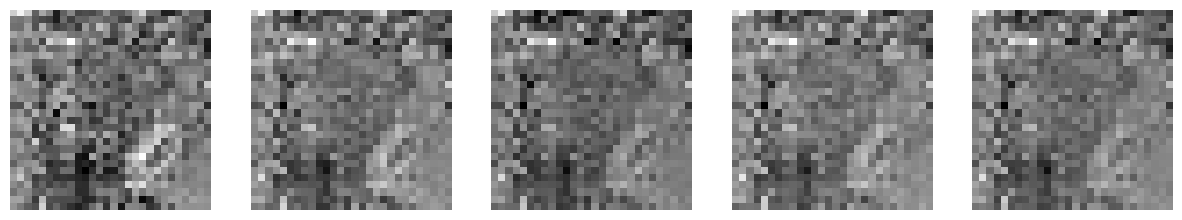

iter=10 | lossv=1.5474827289581299 | lossT=1.112808108329773
iter=20 | lossv=1.3271607160568237 | lossT=1.0895650386810303
iter=30 | lossv=0.8646575212478638 | lossT=1.1816120147705078
iter=40 | lossv=0.959067702293396 | lossT=1.1118321418762207
iter=50 | lossv=1.5909792184829712 | lossT=1.0760900974273682
iter=60 | lossv=1.5877846479415894 | lossT=1.1589231491088867
iter=70 | lossv=1.569848895072937 | lossT=1.0280780792236328
iter=80 | lossv=1.6039140224456787 | lossT=1.0334209203720093
iter=90 | lossv=1.4716575145721436 | lossT=1.2608298063278198
iter=100 | lossv=1.4274470806121826 | lossT=1.1048911809921265


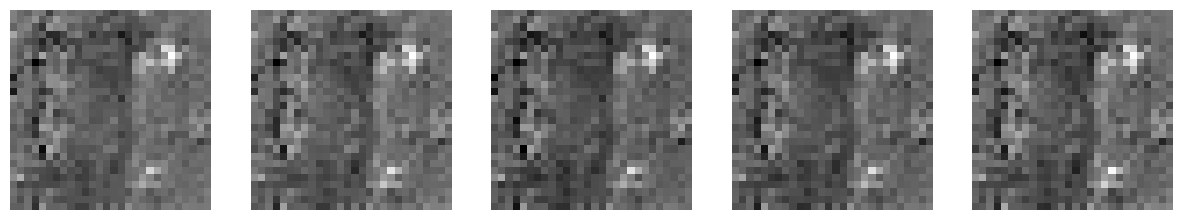

iter=110 | lossv=1.138734221458435 | lossT=1.0346606969833374
iter=120 | lossv=1.1576523780822754 | lossT=1.1113357543945312
iter=130 | lossv=0.9936407804489136 | lossT=1.1161699295043945
iter=140 | lossv=1.4611454010009766 | lossT=1.1429057121276855
iter=150 | lossv=1.256602168083191 | lossT=1.1931524276733398
iter=160 | lossv=0.948887050151825 | lossT=1.24253249168396
iter=170 | lossv=0.7776498794555664 | lossT=1.2252416610717773
iter=180 | lossv=0.642134428024292 | lossT=1.3914222717285156
iter=190 | lossv=0.8690441846847534 | lossT=1.2988156080245972
iter=200 | lossv=1.084609031677246 | lossT=1.7176001071929932


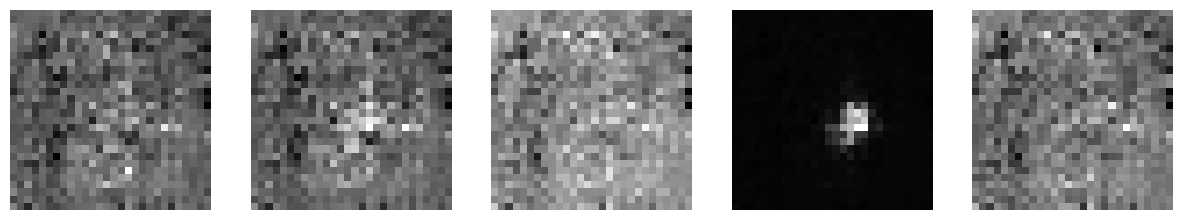

iter=210 | lossv=1.3941540718078613 | lossT=1.2943047285079956
iter=220 | lossv=1.4460620880126953 | lossT=1.2253241539001465
iter=230 | lossv=1.4604671001434326 | lossT=1.1496299505233765
iter=240 | lossv=1.4088605642318726 | lossT=1.128312110900879
iter=250 | lossv=1.4544017314910889 | lossT=1.19319486618042
iter=260 | lossv=1.4569485187530518 | lossT=1.1209303140640259
iter=270 | lossv=1.4318373203277588 | lossT=1.0979138612747192
iter=280 | lossv=1.456632137298584 | lossT=1.0914366245269775
iter=290 | lossv=1.4496839046478271 | lossT=1.127659559249878
Step k=11:
iter=0 | lossv=1.3939659595489502 | lossT=1.1770446300506592


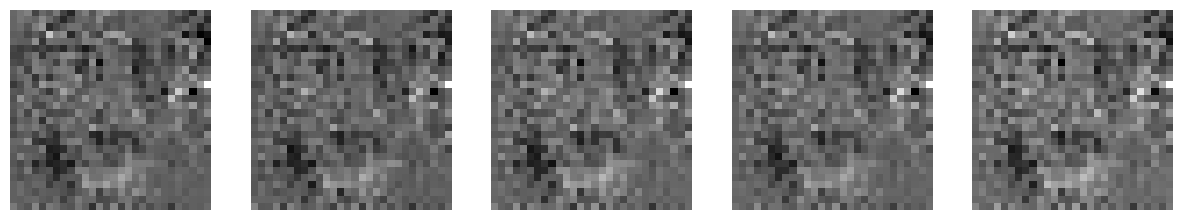

iter=10 | lossv=1.369483232498169 | lossT=1.069272518157959
iter=20 | lossv=1.3207335472106934 | lossT=1.0325002670288086
iter=30 | lossv=1.191788673400879 | lossT=1.1454188823699951
iter=40 | lossv=1.1060194969177246 | lossT=1.062641978263855
iter=50 | lossv=1.0723392963409424 | lossT=1.1279735565185547
iter=60 | lossv=0.9249800443649292 | lossT=1.068366527557373
iter=70 | lossv=0.6997283697128296 | lossT=1.2405858039855957
iter=80 | lossv=1.1379557847976685 | lossT=1.467736005783081
iter=90 | lossv=1.373009204864502 | lossT=1.3883960247039795
iter=100 | lossv=1.3611583709716797 | lossT=1.2766242027282715


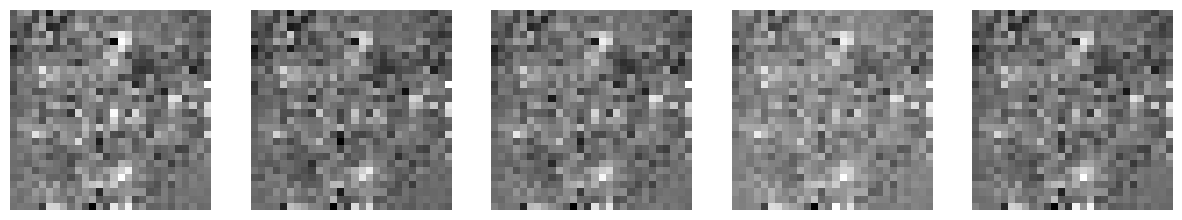

iter=110 | lossv=1.3458545207977295 | lossT=1.4383275508880615
iter=120 | lossv=1.3885740041732788 | lossT=1.3135383129119873
iter=130 | lossv=1.3312346935272217 | lossT=1.2197277545928955
iter=140 | lossv=1.283413290977478 | lossT=1.2696017026901245
iter=150 | lossv=1.2693095207214355 | lossT=1.158276081085205
iter=160 | lossv=1.2071053981781006 | lossT=1.1919300556182861
iter=170 | lossv=1.0701947212219238 | lossT=1.1675834655761719
iter=180 | lossv=0.9586673378944397 | lossT=1.1493995189666748
iter=190 | lossv=0.7940801978111267 | lossT=1.3486260175704956
iter=200 | lossv=1.3216662406921387 | lossT=1.333498477935791


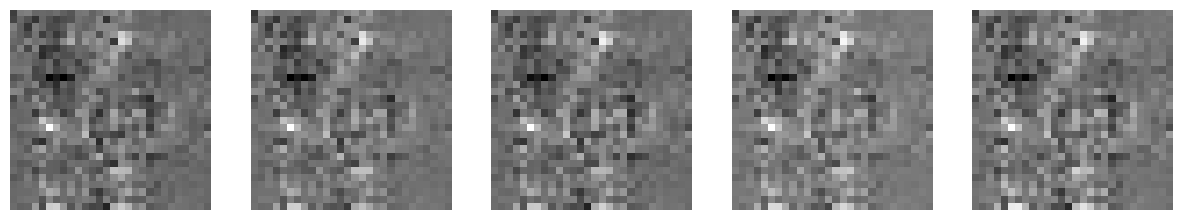

iter=210 | lossv=1.1530377864837646 | lossT=1.3196790218353271
iter=220 | lossv=0.7254244089126587 | lossT=1.3877151012420654
iter=230 | lossv=0.6269385814666748 | lossT=1.353570580482483
iter=240 | lossv=0.5491587519645691 | lossT=1.5525991916656494
iter=250 | lossv=0.6808664798736572 | lossT=1.7407267093658447
iter=260 | lossv=0.7969838976860046 | lossT=1.712500810623169
iter=270 | lossv=0.6797555685043335 | lossT=1.9407209157943726
iter=280 | lossv=0.7247642874717712 | lossT=2.090628147125244
iter=290 | lossv=1.1207048892974854 | lossT=1.967057466506958


In [21]:
dim_noise = 128
K = 12
N = 1500 #10_000
lbda_R1 = 0.2
lr_T = 2*1e-4
lr_v = 1e-4
h = 0.5

T_train,gen_img = training_sJKO_simple(dim_noise,K,N,train_loader,batch_size,lbda_R1,lr_v,lr_T,h,"Shanon","mnist")

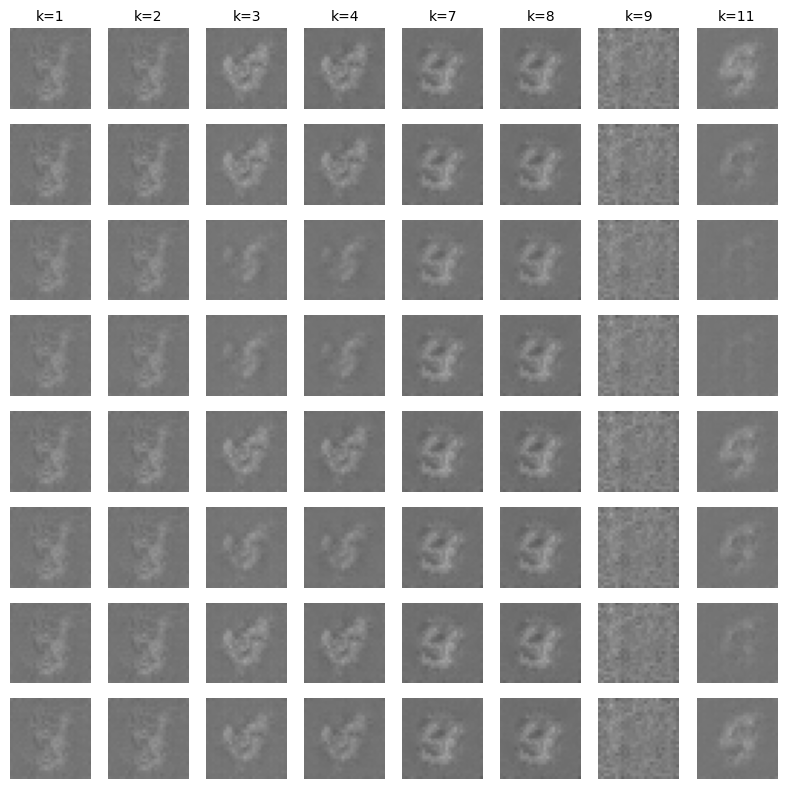

In [23]:
iters = [1,2,3,4,7,8,9,11]
n_rows = 8
n_cols = len(iters)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))




for i in range(n_rows):
    for j, it in enumerate(iters):
        img = gen_img[it][i]
        img = img.reshape((28,28))
        img = img*0.5 + 0.5
        axs[i, j].imshow(img.detach().cpu(), cmap='gray', vmin=0, vmax=1)
        axs[i, j].axis('off')



for j, it in enumerate(iters):
    axs[0, j].set_title(f"k={it}", fontsize=10)


#espacement
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

### CIFAR10

In [5]:
batch_size = 256
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
cifar = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
train_loader_cifar = data.DataLoader(cifar, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


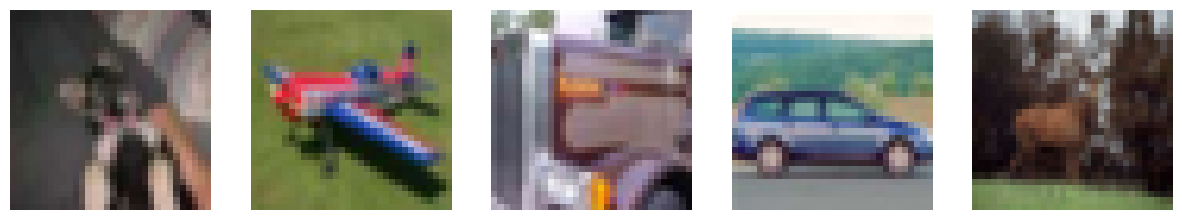

In [6]:
batch = next(iter(train_loader_cifar))[0]
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for j in range(5):
    img = batch[j].detach().cpu()
    img = img.permute(1, 2, 0)  # (32, 32, 3)
    img = img * 0.5 + 0.5
    axs[j].imshow(img.numpy())
    axs[j].axis('off')
plt.show()

In [11]:
128*20*2

5120

Step k=0:
iter=0 | lossv=0.23851612210273743 | lossT=2.4724624156951904


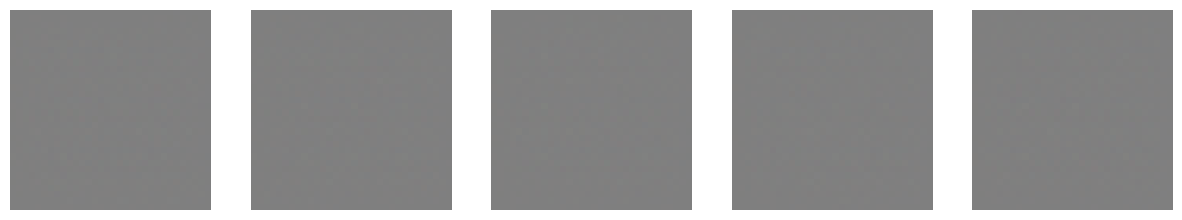

iter=10 | lossv=1.6453218460083008 | lossT=1.480723261833191
iter=20 | lossv=1.866748571395874 | lossT=1.5811598300933838
iter=30 | lossv=0.6074032187461853 | lossT=2.8522186279296875
iter=40 | lossv=-0.5784331560134888 | lossT=3.781055450439453
iter=50 | lossv=-0.6228463053703308 | lossT=4.081245422363281
iter=60 | lossv=0.5541039705276489 | lossT=2.9532856941223145
iter=70 | lossv=-1.1222513914108276 | lossT=4.473694801330566
iter=80 | lossv=-0.6070091724395752 | lossT=3.857387065887451
iter=90 | lossv=-1.1725324392318726 | lossT=4.477665424346924
iter=100 | lossv=-0.8425320386886597 | lossT=3.986781597137451


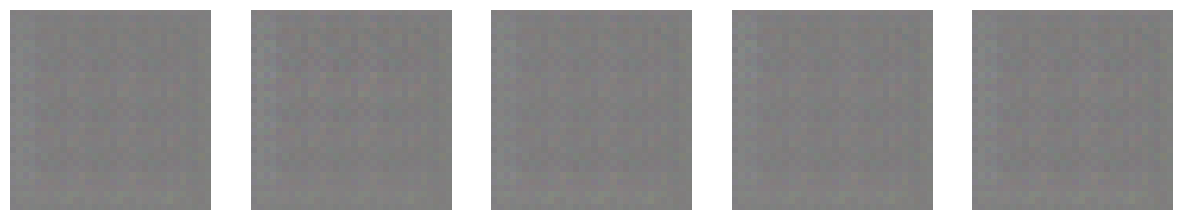

iter=110 | lossv=0.02771584317088127 | lossT=3.1255249977111816
iter=120 | lossv=-1.3161216974258423 | lossT=4.480656623840332
iter=130 | lossv=-1.2648168802261353 | lossT=4.419948577880859
iter=140 | lossv=-3.2158522605895996 | lossT=6.5473222732543945
iter=150 | lossv=-2.956305742263794 | lossT=5.994339942932129
iter=160 | lossv=-3.0921778678894043 | lossT=6.3213372230529785
iter=170 | lossv=-0.2957724332809448 | lossT=2.725040912628174
iter=180 | lossv=0.1710570901632309 | lossT=1.8838355541229248
iter=190 | lossv=-0.14734017848968506 | lossT=2.1700401306152344
iter=200 | lossv=0.33024781942367554 | lossT=1.5837804079055786


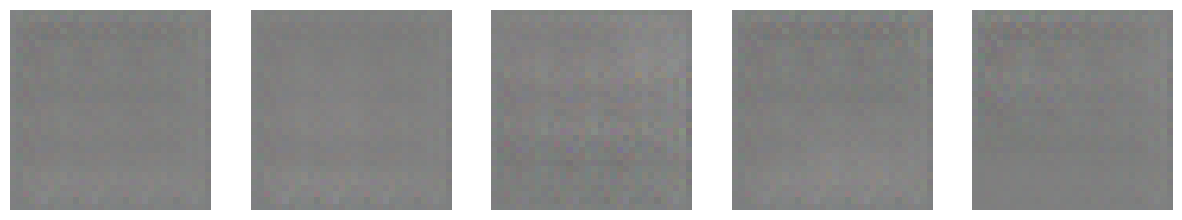

iter=210 | lossv=-0.1174478828907013 | lossT=1.968986988067627
iter=220 | lossv=0.046397507190704346 | lossT=1.9383726119995117
iter=230 | lossv=-0.29426273703575134 | lossT=2.261199474334717
iter=240 | lossv=-0.2663692831993103 | lossT=2.1904072761535645
iter=250 | lossv=-0.28539741039276123 | lossT=2.1112561225891113
iter=260 | lossv=-0.08996342122554779 | lossT=1.8589503765106201
iter=270 | lossv=-0.12638656795024872 | lossT=2.5121755599975586
iter=280 | lossv=0.17393603920936584 | lossT=1.665101408958435
iter=290 | lossv=-0.32754549384117126 | lossT=2.2930150032043457
iter=300 | lossv=-0.1275106519460678 | lossT=2.106841564178467


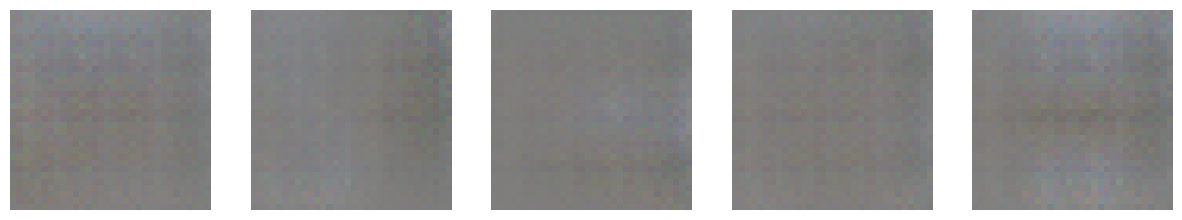

iter=310 | lossv=-0.07803419977426529 | lossT=1.945425033569336
iter=320 | lossv=-0.23362305760383606 | lossT=2.1946425437927246
iter=330 | lossv=-0.15799447894096375 | lossT=2.229342222213745
iter=340 | lossv=-0.6185718774795532 | lossT=2.5869126319885254
iter=350 | lossv=-0.44355690479278564 | lossT=2.594545364379883
iter=360 | lossv=-0.48613613843917847 | lossT=2.6623642444610596
iter=370 | lossv=-0.16771677136421204 | lossT=2.0413291454315186
iter=380 | lossv=-0.7947930097579956 | lossT=2.695941925048828
iter=390 | lossv=-0.7107228636741638 | lossT=2.712778091430664
iter=400 | lossv=-0.7027884721755981 | lossT=2.7325615882873535


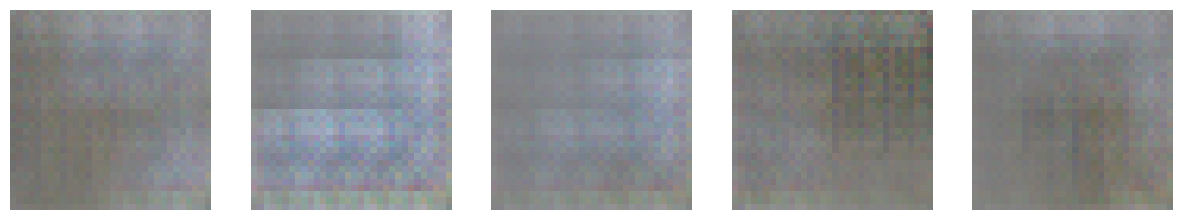

iter=410 | lossv=-0.9250801205635071 | lossT=2.956763744354248
iter=420 | lossv=-0.6407765746116638 | lossT=2.771151065826416
iter=430 | lossv=-0.5140058398246765 | lossT=2.4637668132781982
iter=440 | lossv=-0.2745431661605835 | lossT=2.256600856781006
iter=450 | lossv=-0.314597487449646 | lossT=2.4580633640289307
iter=460 | lossv=-0.42397552728652954 | lossT=2.8070240020751953
iter=470 | lossv=-0.2986990213394165 | lossT=2.3406424522399902
iter=480 | lossv=-0.06751790642738342 | lossT=2.1769914627075195
iter=490 | lossv=-0.5636817216873169 | lossT=2.478560447692871
iter=500 | lossv=-0.3175785541534424 | lossT=2.280085325241089


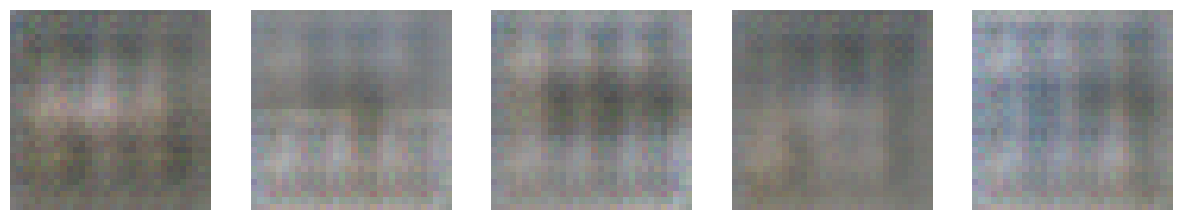

iter=510 | lossv=-0.4070911407470703 | lossT=2.3582098484039307
iter=520 | lossv=-0.19670750200748444 | lossT=1.9556418657302856
iter=530 | lossv=-0.042226873338222504 | lossT=1.8632460832595825
iter=540 | lossv=-0.18398571014404297 | lossT=2.0976555347442627
iter=550 | lossv=0.19888243079185486 | lossT=1.84150230884552
iter=560 | lossv=0.15139976143836975 | lossT=1.6973941326141357
iter=570 | lossv=-0.03838645666837692 | lossT=1.944974422454834
iter=580 | lossv=-0.09596944600343704 | lossT=1.9715380668640137
iter=590 | lossv=-0.08907952159643173 | lossT=1.9185569286346436
iter=600 | lossv=0.11104234308004379 | lossT=1.8170526027679443


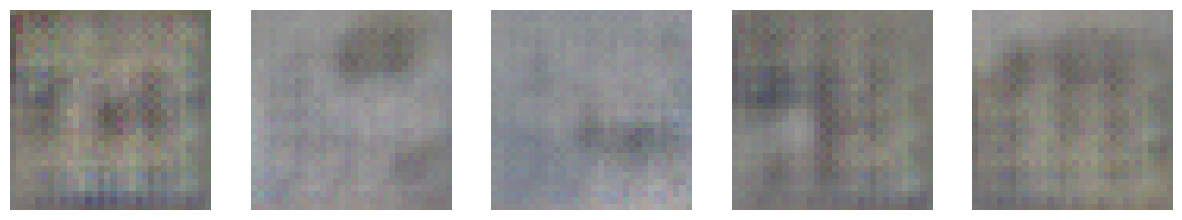

iter=610 | lossv=-0.04224751889705658 | lossT=1.8300917148590088
iter=620 | lossv=-0.2565436363220215 | lossT=2.1410088539123535
iter=630 | lossv=-0.10894648730754852 | lossT=1.9520964622497559
iter=640 | lossv=-0.04504229873418808 | lossT=1.8673326969146729
iter=650 | lossv=-0.0766199380159378 | lossT=1.7795398235321045
iter=660 | lossv=-0.03753452003002167 | lossT=1.9659912586212158
iter=670 | lossv=-0.4617965519428253 | lossT=2.252634048461914
iter=680 | lossv=-0.2900172173976898 | lossT=2.1026840209960938
iter=690 | lossv=-0.42708784341812134 | lossT=2.244619369506836
iter=700 | lossv=-0.4851889908313751 | lossT=2.348827362060547


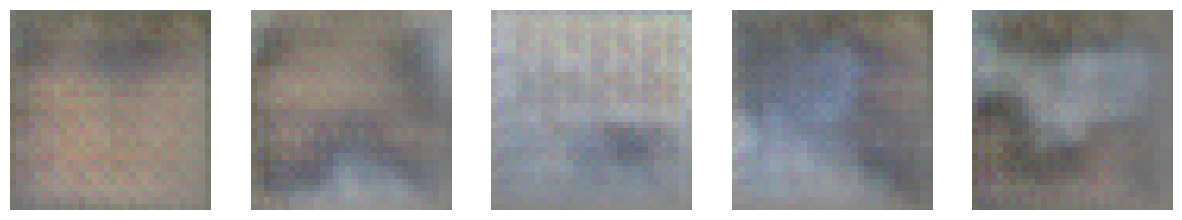

iter=710 | lossv=-0.22322583198547363 | lossT=2.1735215187072754
iter=720 | lossv=-0.3907827138900757 | lossT=2.1471219062805176
iter=730 | lossv=-0.29258978366851807 | lossT=2.060734748840332
iter=740 | lossv=-0.22421565651893616 | lossT=1.9577409029006958
iter=750 | lossv=-0.09087896347045898 | lossT=2.015528917312622
iter=760 | lossv=-0.07753121852874756 | lossT=1.9313721656799316
iter=770 | lossv=-0.12604376673698425 | lossT=1.7775849103927612
iter=780 | lossv=-0.08636386692523956 | lossT=1.7958126068115234
iter=790 | lossv=-0.06327341496944427 | lossT=1.8725028038024902
iter=800 | lossv=-0.029550202190876007 | lossT=1.8571542501449585


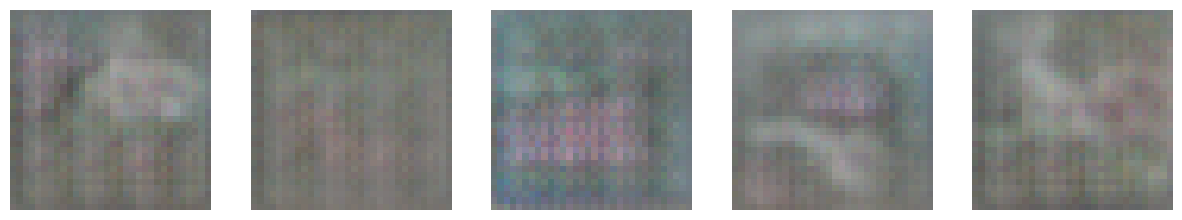

iter=810 | lossv=-0.16997751593589783 | lossT=1.886181116104126
iter=820 | lossv=-0.13973075151443481 | lossT=1.7706847190856934
iter=830 | lossv=-0.009268072433769703 | lossT=1.7737016677856445
iter=840 | lossv=-0.12416921555995941 | lossT=1.791661262512207
iter=850 | lossv=-0.11463525146245956 | lossT=1.8336918354034424
iter=860 | lossv=-0.09332894533872604 | lossT=1.8952115774154663
iter=870 | lossv=-0.1355249434709549 | lossT=2.0440874099731445
iter=880 | lossv=-0.11063942313194275 | lossT=1.8770824670791626
iter=890 | lossv=-0.3272918462753296 | lossT=2.0895071029663086
iter=900 | lossv=0.014371522702276707 | lossT=1.8380987644195557


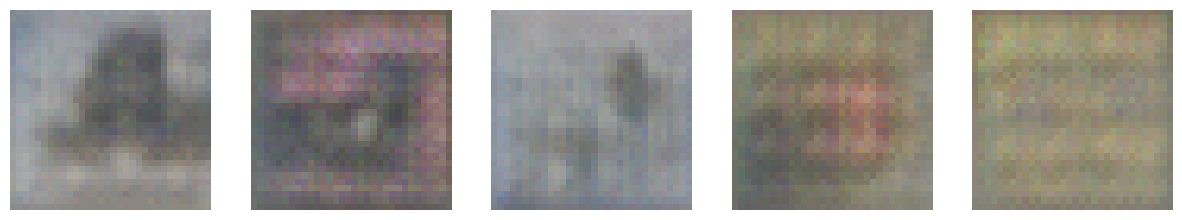

iter=910 | lossv=-0.12155316770076752 | lossT=1.9217451810836792
iter=920 | lossv=-0.28395628929138184 | lossT=2.094670534133911
iter=930 | lossv=-0.14489038288593292 | lossT=1.9270908832550049
iter=940 | lossv=-0.2193440943956375 | lossT=1.8921400308609009
iter=950 | lossv=-0.14259807765483856 | lossT=1.940664529800415
iter=960 | lossv=-0.0742696225643158 | lossT=1.8894543647766113
iter=970 | lossv=-0.19866859912872314 | lossT=1.874387264251709
iter=980 | lossv=-0.1444029062986374 | lossT=1.9921013116836548
iter=990 | lossv=-0.05051036179065704 | lossT=1.8564956188201904
iter=1000 | lossv=-0.14440523087978363 | lossT=1.934821367263794


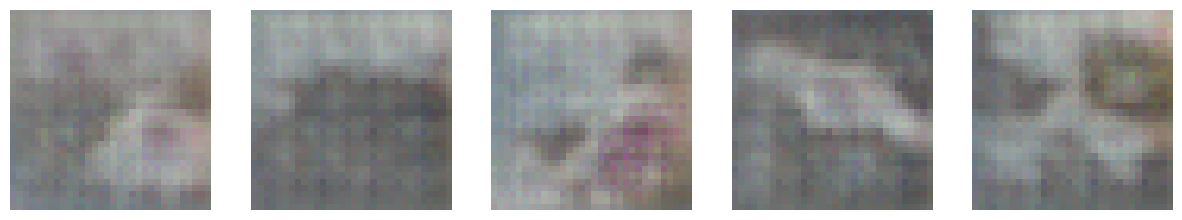

iter=1010 | lossv=-0.17815932631492615 | lossT=1.8672524690628052
iter=1020 | lossv=-0.2890598177909851 | lossT=2.0597946643829346
iter=1030 | lossv=-0.3692918121814728 | lossT=2.046692371368408
iter=1040 | lossv=-0.22529913485050201 | lossT=2.018099308013916
iter=1050 | lossv=-0.25080546736717224 | lossT=2.039351463317871
iter=1060 | lossv=-0.14696164429187775 | lossT=1.8919953107833862
iter=1070 | lossv=-0.11133218556642532 | lossT=1.874632477760315
iter=1080 | lossv=-0.13182106614112854 | lossT=1.935632586479187
iter=1090 | lossv=-0.17465542256832123 | lossT=2.04793381690979
iter=1100 | lossv=-0.09288887679576874 | lossT=1.843686580657959


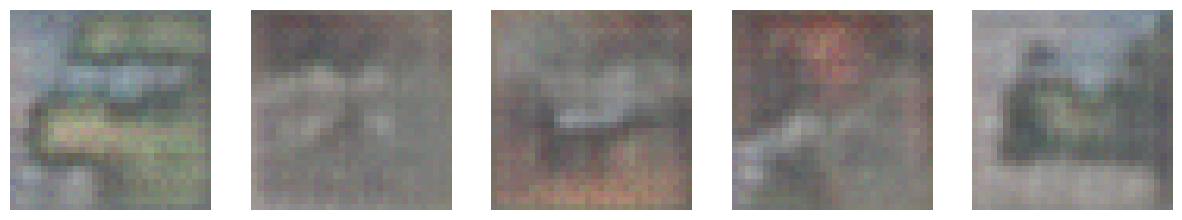

iter=1110 | lossv=-0.3159196674823761 | lossT=2.1101951599121094
iter=1120 | lossv=-0.26185232400894165 | lossT=2.141134023666382
iter=1130 | lossv=-0.1366397738456726 | lossT=1.9295086860656738
iter=1140 | lossv=-0.14979588985443115 | lossT=1.993712306022644
iter=1150 | lossv=-0.24631129205226898 | lossT=1.9774062633514404
iter=1160 | lossv=-0.1509404182434082 | lossT=1.908028483390808
iter=1170 | lossv=-0.1600978672504425 | lossT=1.9643056392669678
iter=1180 | lossv=-0.22229498624801636 | lossT=2.133711814880371
iter=1190 | lossv=-0.3226538598537445 | lossT=2.179103374481201
iter=1200 | lossv=-0.2847638726234436 | lossT=2.071253776550293


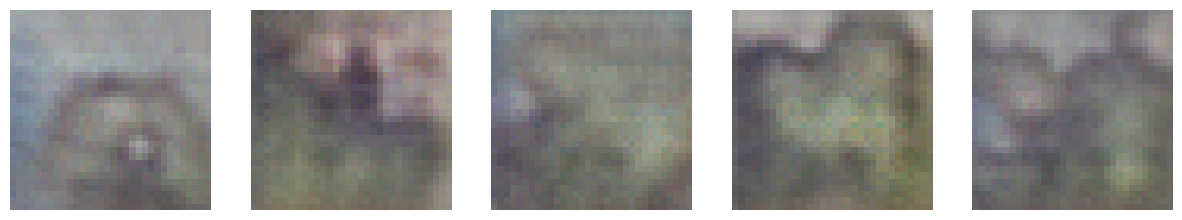

iter=1210 | lossv=-0.1486182063817978 | lossT=1.9991496801376343
iter=1220 | lossv=-0.1868343949317932 | lossT=2.0492167472839355
iter=1230 | lossv=-0.29561036825180054 | lossT=2.0927608013153076
iter=1240 | lossv=-0.08707601577043533 | lossT=1.9332585334777832
iter=1250 | lossv=-0.37426912784576416 | lossT=2.325887680053711
iter=1260 | lossv=-0.1900157630443573 | lossT=2.10077166557312
iter=1270 | lossv=-0.20276257395744324 | lossT=2.2361764907836914
iter=1280 | lossv=-0.008566658943891525 | lossT=1.9074599742889404
iter=1290 | lossv=-0.07662516832351685 | lossT=1.906974196434021
iter=1300 | lossv=-0.20503583550453186 | lossT=1.934179663658142


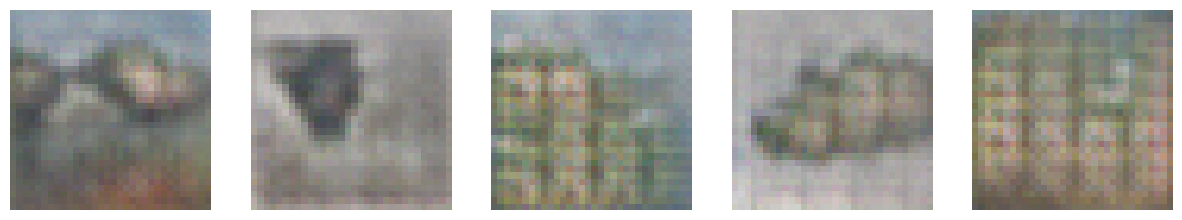

iter=1310 | lossv=-0.2898629307746887 | lossT=2.050119161605835
iter=1320 | lossv=-0.18856137990951538 | lossT=2.0663092136383057
iter=1330 | lossv=-0.22088290750980377 | lossT=1.9372539520263672
iter=1340 | lossv=-0.31198033690452576 | lossT=2.095722198486328
iter=1350 | lossv=-0.27293819189071655 | lossT=2.099923610687256
iter=1360 | lossv=-0.20545746386051178 | lossT=1.9095735549926758
iter=1370 | lossv=-0.21889950335025787 | lossT=1.9765198230743408
iter=1380 | lossv=-0.08257325738668442 | lossT=1.907629370689392
iter=1390 | lossv=-0.14813512563705444 | lossT=2.0536551475524902
iter=1400 | lossv=-0.23838160932064056 | lossT=2.0427143573760986


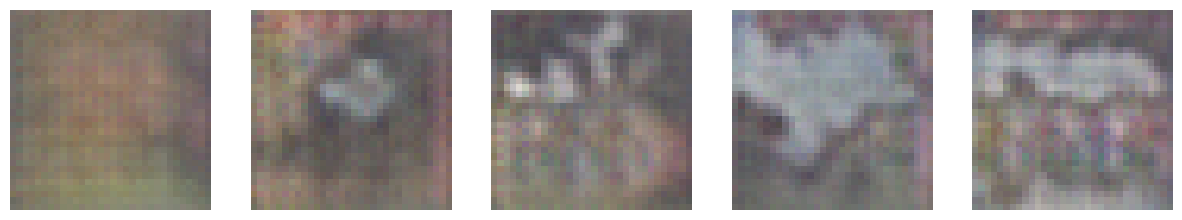

iter=1410 | lossv=-0.16957642138004303 | lossT=1.9075020551681519
iter=1420 | lossv=-0.30832377076148987 | lossT=2.091411828994751
iter=1430 | lossv=-0.23920509219169617 | lossT=2.0181286334991455
iter=1440 | lossv=-0.2021091878414154 | lossT=1.9768257141113281
iter=1450 | lossv=-0.2884519100189209 | lossT=2.050555467605591
iter=1460 | lossv=-0.2216154932975769 | lossT=1.8594961166381836
iter=1470 | lossv=-0.05788237601518631 | lossT=1.8930091857910156
iter=1480 | lossv=-0.3878624439239502 | lossT=2.0882482528686523
iter=1490 | lossv=-0.18687400221824646 | lossT=1.912224531173706
Step k=1:
iter=0 | lossv=-0.3811931908130646 | lossT=0.6191211938858032


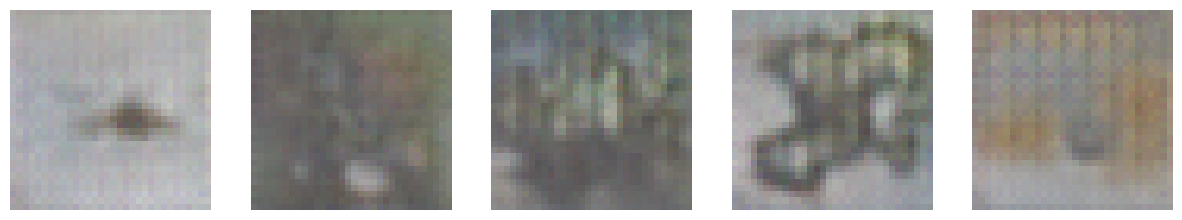

iter=10 | lossv=-0.09914617240428925 | lossT=0.3396737575531006
iter=20 | lossv=-0.09486265480518341 | lossT=0.5579788684844971
iter=30 | lossv=-0.0954199880361557 | lossT=0.4796046316623688
iter=40 | lossv=-0.14159993827342987 | lossT=0.6376361846923828
iter=50 | lossv=-0.1510552316904068 | lossT=0.4046921730041504
iter=60 | lossv=-0.10259740799665451 | lossT=0.4469074606895447
iter=70 | lossv=-0.06488622725009918 | lossT=0.4648074507713318
iter=80 | lossv=-0.17334777116775513 | lossT=0.5769020915031433
iter=90 | lossv=-0.16922414302825928 | lossT=0.5043681859970093
iter=100 | lossv=-0.273701548576355 | lossT=0.48814481496810913


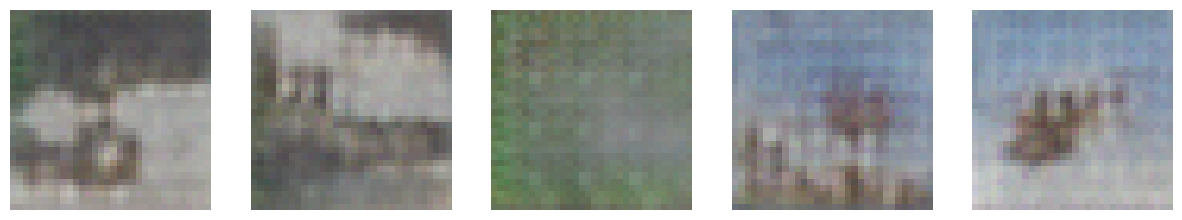

iter=110 | lossv=-0.24666064977645874 | lossT=0.5850446224212646
iter=120 | lossv=-0.09617644548416138 | lossT=0.4104251265525818
iter=130 | lossv=-0.15163256227970123 | lossT=0.3731918931007385
iter=140 | lossv=-0.1280914545059204 | lossT=0.5364307165145874
iter=150 | lossv=-0.1972605288028717 | lossT=0.34354108572006226
iter=160 | lossv=-0.07067788392305374 | lossT=0.3831128478050232
iter=170 | lossv=-0.19347000122070312 | lossT=0.5807594656944275
iter=180 | lossv=-0.18712815642356873 | lossT=0.5418087244033813
iter=190 | lossv=-0.11212107539176941 | lossT=0.4127669930458069
iter=200 | lossv=-0.2930013835430145 | lossT=0.6053495407104492


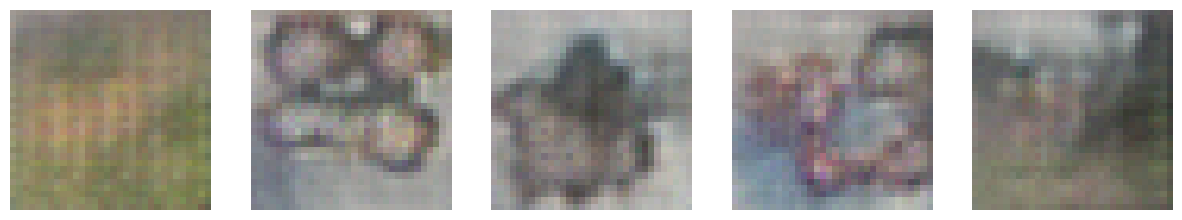

iter=210 | lossv=-0.2327663153409958 | lossT=0.529314398765564
iter=220 | lossv=-0.3698008060455322 | lossT=0.8129434585571289
iter=230 | lossv=-0.01332874409854412 | lossT=0.3979840874671936
iter=240 | lossv=-0.11619053781032562 | lossT=0.4559475779533386
iter=250 | lossv=-0.023866774514317513 | lossT=0.42345285415649414
iter=260 | lossv=-0.1250496506690979 | lossT=0.4192160665988922
iter=270 | lossv=-0.2902841866016388 | lossT=0.5769883394241333
iter=280 | lossv=-0.1585574746131897 | lossT=0.4770486652851105
iter=290 | lossv=-0.3177635073661804 | lossT=0.6333730220794678
Step k=2:
iter=0 | lossv=-0.3144318461418152 | lossT=0.679307222366333


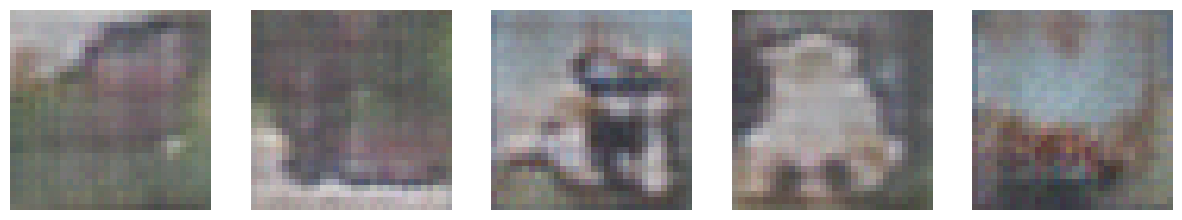

iter=10 | lossv=-0.24151958525180817 | lossT=0.4698708951473236
iter=20 | lossv=-0.1483447253704071 | lossT=0.47745567560195923
iter=30 | lossv=-0.16144528985023499 | lossT=0.3860238492488861
iter=40 | lossv=-0.3572021722793579 | lossT=0.662919282913208
iter=50 | lossv=-0.14614932239055634 | lossT=0.3979807198047638
iter=60 | lossv=-0.06614254415035248 | lossT=0.4297846555709839
iter=70 | lossv=0.0053639160469174385 | lossT=0.402590274810791
iter=80 | lossv=-0.3249428868293762 | lossT=0.6227506995201111
iter=90 | lossv=-0.00568002462387085 | lossT=0.41388583183288574
iter=100 | lossv=-0.12465988099575043 | lossT=0.49068593978881836


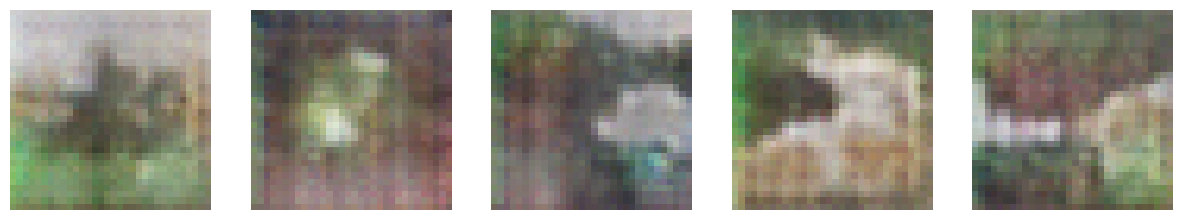

iter=110 | lossv=-0.0794767215847969 | lossT=0.5702681541442871
iter=120 | lossv=-0.022403085604310036 | lossT=0.3438667953014374
iter=130 | lossv=-0.07043434679508209 | lossT=0.3966704308986664
iter=140 | lossv=-0.21167421340942383 | lossT=0.4480445384979248
iter=150 | lossv=-0.0045517925173044205 | lossT=0.45635566115379333
iter=160 | lossv=-0.2931244969367981 | lossT=0.6194682121276855
iter=170 | lossv=0.12783440947532654 | lossT=0.2232467085123062
iter=180 | lossv=-0.3545690178871155 | lossT=0.8050097227096558
iter=190 | lossv=-0.10282602161169052 | lossT=0.5294674634933472
iter=200 | lossv=0.008317012339830399 | lossT=0.3961351811885834


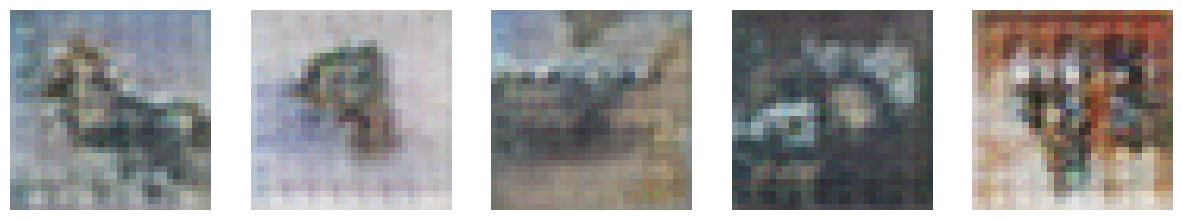

iter=210 | lossv=-0.31449922919273376 | lossT=0.803801417350769
iter=220 | lossv=-0.27164435386657715 | lossT=0.7154491543769836
iter=230 | lossv=-0.15266674757003784 | lossT=0.5201542377471924
iter=240 | lossv=-0.2587851583957672 | lossT=0.6716616153717041
iter=250 | lossv=-0.19473837316036224 | lossT=0.5574058294296265
iter=260 | lossv=-0.027152642607688904 | lossT=0.3659611940383911
iter=270 | lossv=-0.08449111133813858 | lossT=0.452079713344574
iter=280 | lossv=-0.35826733708381653 | lossT=0.6344670653343201
iter=290 | lossv=-0.13742861151695251 | lossT=0.541998565196991
Step k=3:
iter=0 | lossv=-0.08195565640926361 | lossT=0.3218611478805542


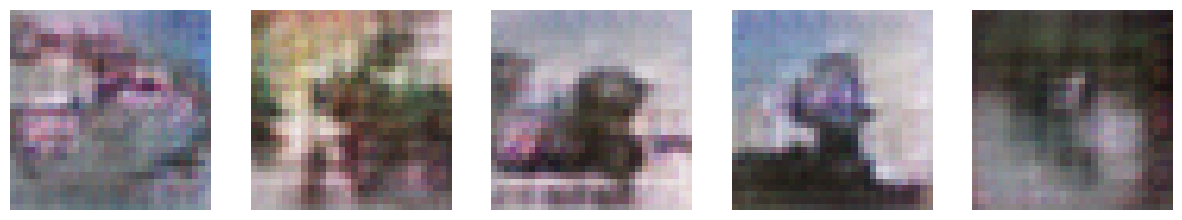

iter=10 | lossv=-0.12004173547029495 | lossT=0.4023177921772003
iter=20 | lossv=-0.08851572126150131 | lossT=0.38797879219055176
iter=30 | lossv=-0.17237426340579987 | lossT=0.4388638138771057
iter=40 | lossv=-0.18095029890537262 | lossT=0.5861000418663025
iter=50 | lossv=-0.28463661670684814 | lossT=0.5493298172950745
iter=60 | lossv=-0.42622461915016174 | lossT=0.7820074558258057
iter=70 | lossv=-0.22125639021396637 | lossT=0.6186147332191467
iter=80 | lossv=-0.11765861511230469 | lossT=0.34489601850509644
iter=90 | lossv=-0.09301498532295227 | lossT=0.35419338941574097
iter=100 | lossv=-0.20248813927173615 | lossT=0.4242934584617615


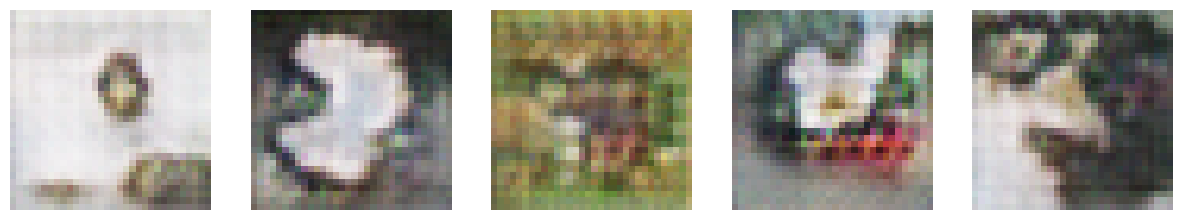

iter=110 | lossv=-0.2101309597492218 | lossT=0.49054020643234253
iter=120 | lossv=-0.2412717044353485 | lossT=0.5387592315673828
iter=130 | lossv=-0.07282362878322601 | lossT=0.4309818148612976
iter=140 | lossv=-0.21575914323329926 | lossT=0.5010874271392822
iter=150 | lossv=-0.2079726606607437 | lossT=0.5518509149551392
iter=160 | lossv=-0.060343921184539795 | lossT=0.3655836582183838
iter=170 | lossv=-0.08561249077320099 | lossT=0.3782195448875427
iter=180 | lossv=-0.12699788808822632 | lossT=0.47975897789001465
iter=190 | lossv=-0.13560904562473297 | lossT=0.5158053040504456
iter=200 | lossv=-0.2659456729888916 | lossT=0.43201637268066406


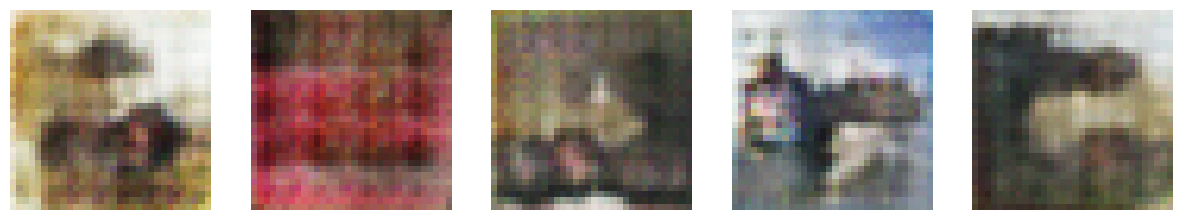

iter=210 | lossv=-0.20718175172805786 | lossT=0.4612811803817749
iter=220 | lossv=-0.1444225311279297 | lossT=0.43794089555740356
iter=230 | lossv=-0.06027713418006897 | lossT=0.3607429563999176
iter=240 | lossv=-0.25447267293930054 | lossT=0.5445206761360168
iter=250 | lossv=-0.2138558328151703 | lossT=0.5713242292404175
iter=260 | lossv=-0.21403253078460693 | lossT=0.6358296871185303
iter=270 | lossv=-0.013240662403404713 | lossT=0.5152374505996704
iter=280 | lossv=-0.19654151797294617 | lossT=0.45376935601234436
iter=290 | lossv=-0.05881895497441292 | lossT=0.39971035718917847
Step k=4:
iter=0 | lossv=-0.1761191189289093 | lossT=0.33689630031585693


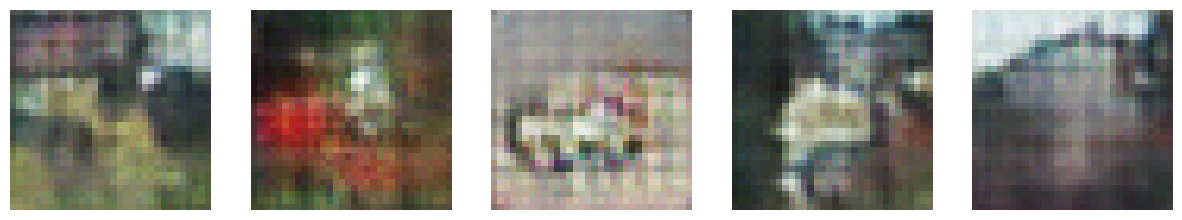

iter=10 | lossv=-0.03576159477233887 | lossT=0.36848539113998413
iter=20 | lossv=-0.028284920379519463 | lossT=0.33458808064460754
iter=30 | lossv=-0.03554024547338486 | lossT=0.3679946959018707
iter=40 | lossv=-0.06998364627361298 | lossT=0.3969206213951111
iter=50 | lossv=-0.0051596444100141525 | lossT=0.3119964003562927
iter=60 | lossv=-0.19103077054023743 | lossT=0.4970755875110626
iter=70 | lossv=-0.34604161977767944 | lossT=0.5374966859817505
iter=80 | lossv=-0.14077289402484894 | lossT=0.4806745648384094
iter=90 | lossv=-0.14411428570747375 | lossT=0.37710005044937134
iter=100 | lossv=-0.16330353915691376 | lossT=0.5056080222129822


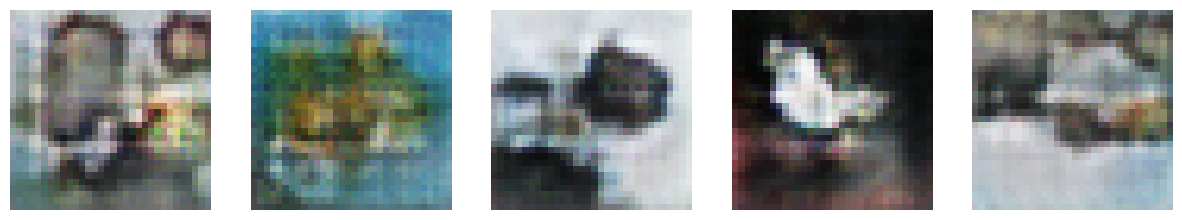

iter=110 | lossv=-0.1025705486536026 | lossT=0.40165984630584717
iter=120 | lossv=0.0012117372825741768 | lossT=0.29310983419418335
iter=130 | lossv=-0.191045343875885 | lossT=0.49837929010391235
iter=140 | lossv=-0.23184850811958313 | lossT=0.58366858959198
iter=150 | lossv=-0.0839889869093895 | lossT=0.3794478476047516
iter=160 | lossv=-0.14785894751548767 | lossT=0.6069295406341553
iter=170 | lossv=-0.33625978231430054 | lossT=0.7694277763366699
iter=180 | lossv=-0.23159673810005188 | lossT=0.44324803352355957
iter=190 | lossv=-0.07944612205028534 | lossT=0.4623589515686035
iter=200 | lossv=-0.08131415396928787 | lossT=0.46370646357536316


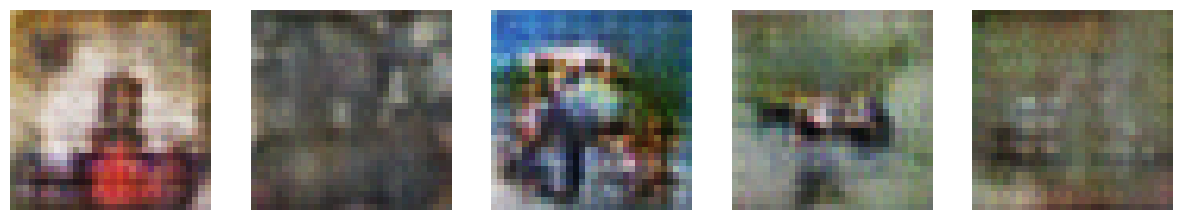

iter=210 | lossv=-0.27414441108703613 | lossT=0.7183544039726257
iter=220 | lossv=-0.2067563384771347 | lossT=0.4653410315513611
iter=230 | lossv=-0.12144443392753601 | lossT=0.49268707633018494
iter=240 | lossv=-0.1898260861635208 | lossT=0.5351346731185913
iter=250 | lossv=-0.2393399178981781 | lossT=0.6179782748222351
iter=260 | lossv=-0.1671948879957199 | lossT=0.5046924948692322
iter=270 | lossv=-0.034562669694423676 | lossT=0.3499455451965332
iter=280 | lossv=-0.03888136148452759 | lossT=0.3893672823905945
iter=290 | lossv=-0.10074897855520248 | lossT=0.4107927083969116


In [12]:
dim_noise = 5_120
K = 5
N = 1500 #10_000
lbda_R1 = 0.2
lr_T = 2*1e-4
lr_v = 1e-4
h = 0.2

T_train,gen_img = training_sJKO_simple(dim_noise,K,N,train_loader_cifar,batch_size,lbda_R1,lr_v,lr_T,h,"KL","cifar10")

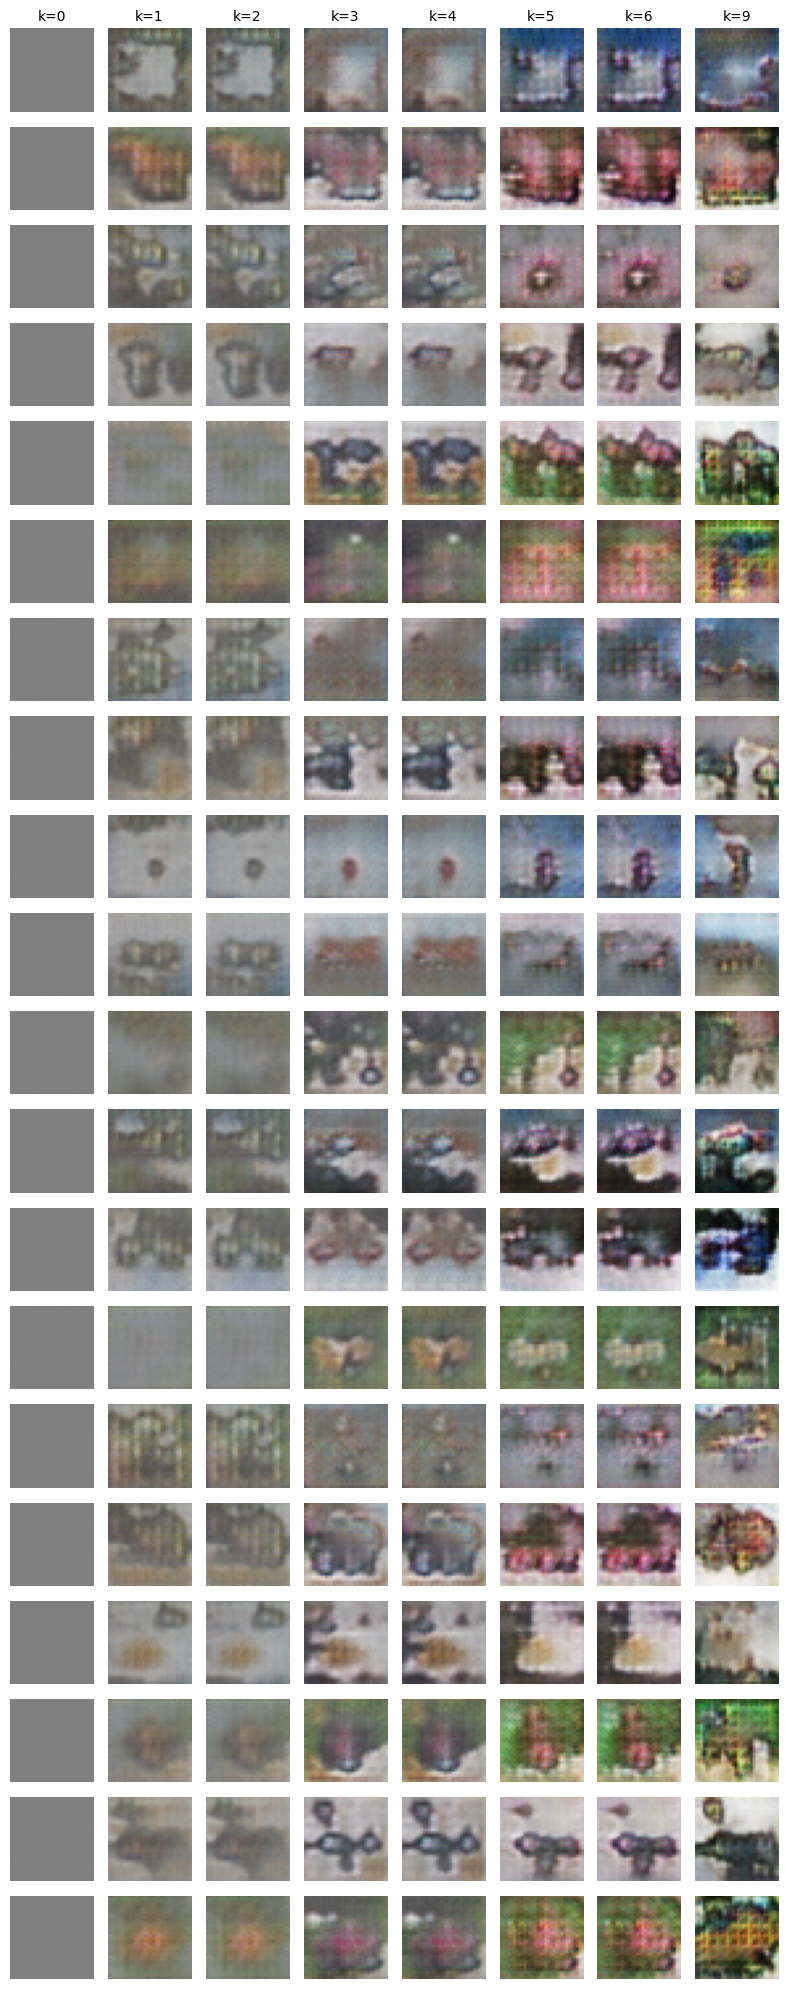

In [34]:
iters = [0,1,2,3,4,5,6,9]
n_rows = 20
n_cols = len(iters)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))




for i in range(n_rows):
    for j, it in enumerate(iters):
        img = gen_img[it][i]
        img = img.permute(1,2,0)

        img = img*0.5 + 0.5
        axs[i, j].imshow(img.detach().cpu())
        axs[i, j].axis('off')



for j, it in enumerate(iters):
    axs[0, j].set_title(f"k={it}", fontsize=10)


#espacement
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

### 2d

In [35]:
class ResidualBlock1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.activation = nn.SiLU()

    def forward(self, x):
        h = self.activation(self.fc1(x))
        h = self.fc2(h)
        return self.activation(x + h)

class Generator_Synthetic(nn.Module):
    def __init__(self, z_dim=2, x_dim=2, hidden_dim=128, out_dim=2):
        super().__init__()
        # z → 128
        self.z_fc = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        # x → 128 via ResBlocks
        self.x_resblocks = nn.Sequential(
            ResidualBlock1D(x_dim),
            ResidualBlock1D(x_dim),
            ResidualBlock1D(x_dim),
            nn.Linear(x_dim, hidden_dim)  # adapt x_dim to hidden_dim
        )
        # Final layers
        self.final_fc = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim),  # output dimension
            nn.Tanh()
        )

    def forward(self, x, z):
        #z_embed = self.z_fc(z)          # (B, hidden_dim)
        x_embed = self.x_resblocks(x)   # (B, hidden_dim)
        h = x_embed #+ z_embed
        return self.final_fc(h) * 10

class Discriminator_Synthetic(nn.Module):
    def __init__(self, x_dim=2, hidden_dim=128):
        super().__init__()
        self.resblocks = nn.Sequential(
            ResidualBlock1D(x_dim),
            ResidualBlock1D(x_dim),
            ResidualBlock1D(x_dim),
            nn.Linear(x_dim, hidden_dim)
        )
        self.final_fc = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        h = self.resblocks(x)
        return self.final_fc(h).squeeze(1)

In [36]:
class Circles:
    def __init__(self, batch_size, centers, radius, sigmas):
        assert len(centers) == len(radius)
        assert  len(radius) == len(sigmas)
        assert batch_size % len(centers) == 0

        self.batch_size = batch_size
        self.num_circles = len(centers)
        self.ind_sample =  self.batch_size // self.num_circles

        self.centers = torch.tensor(centers * self.ind_sample, dtype=torch.float32)
        self.radius = torch.tensor(radius * self.ind_sample, dtype=torch.float32)[:,None]
        self.sigmas = torch.tensor(sigmas * self.ind_sample, dtype=torch.float32)[:,None]

    def sample(self):
        noise = torch.randn(size=(self.batch_size, 2))
        z = torch.randn(size=(self.batch_size, 2))
        z = z/torch.norm(z, dim=1, keepdim=True)
        return self.centers + self.radius* z + self.sigmas * noise

In [38]:
def training_sJKO_simple2d(dim_noise,K,N,sampler,batch_size,lr_v,lr_T,h,div_name):

    d = dim_noise
    n_gen = 1_000
    gen_img = []

    rand_seed_gen_x = torch.randn(n_gen, 2)
    rand_seed_gen_z = torch.randn(n_gen, 2)

    T = Generator_Synthetic()
    v = Discriminator_Synthetic()
    T_old = lambda x,z : x

    optimizerLv = optim.Adam(v.parameters(), lr=lr_v, betas=(0.5, 0.9))
    optimizerLT = optim.Adam(T.parameters(), lr=lr_T, betas=(0.5, 0.9))

    for k in range(K):

        print(f"Step k={k}:")

        for i in range(N):

            y = sampler.sample()
            y.requires_grad_()

            x = torch.randn(batch_size, 2)  # Batch de points 2D
            z = torch.randn(batch_size, 2)

            v_y = v(y) # B

            #Compute and optimize L_v
            optimizerLv.zero_grad()
            y_hat = T(x,z) # B,2

            if div_name == "KL":
                Lv = (v(y_hat) + (torch.exp(- v_y) - 1)).mean()
            elif div_name == "Shanon":
                Lv = (F.softplus(w_phi(v(y_hat))) + F.softplus(-w_phi(v_y))).mean()
            Lv.backward()
            optimizerLv.step()

            #Compute and optimize L_T
            optimizerLT.zero_grad()
            x = torch.randn(batch_size, 2)  # Batch de points 2D
            z1 = torch.randn(batch_size, 2)
            z2 = torch.randn(batch_size, 2)
            y_hat = T(x,z1) # B,2
            y_old = T_old(x,z2) # B,2

            if div_name == "KL":
                LT = (cost(y_old,y_hat,d,h) - v(y_hat)).mean()
            elif div_name == "Shanon":
                LT = (cost(y_old,y_hat,d,h) + F.softplus(-w_phi(v(y_hat)))).mean()
            LT.backward()
            optimizerLT.step()

            #Print Info and images
            if i % 500 == 0:
                print(f"iter={i} | lossv={Lv} | lossT={LT}")
                if i % 2_000 == 0:
                    x = torch.randn(n_gen, 2)  # Batch de points 2D
                    z1 = torch.randn(n_gen, 2)
                    y_hat = T(x,z1)
                    real = sampler.sample()
                    #print(y_hat.shape,y_hat[:,0].shape,y_hat[:,1].shape)
                    plt.scatter(real[:,0].detach(),real[:,1].detach())
                    plt.scatter(y_hat[:,0].detach(),y_hat[:,1].detach())
                    plt.show()


            if i == N-1 or (i ==0 & k==0):
                imgs = T(rand_seed_gen_x,rand_seed_gen_z)
                gen_img.append(imgs)

        T_old = copy.deepcopy(T)

    return T,gen_img


Step k=0:
iter=0 | lossv=0.18319743871688843 | lossT=0.28114548325538635


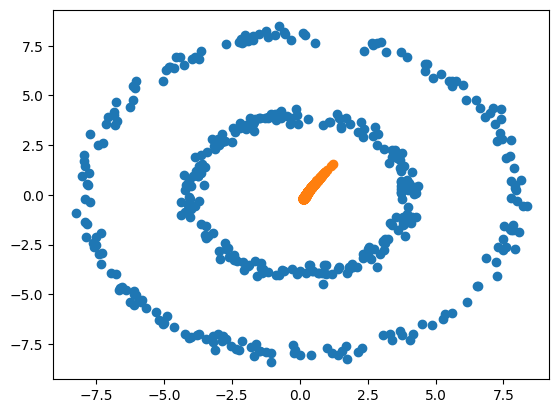

iter=500 | lossv=-0.3234785199165344 | lossT=0.5120083689689636
iter=1000 | lossv=-0.2957424819469452 | lossT=0.550162672996521
iter=1500 | lossv=-0.3321015536785126 | lossT=0.5276150703430176
iter=2000 | lossv=-0.33003029227256775 | lossT=0.5726845264434814


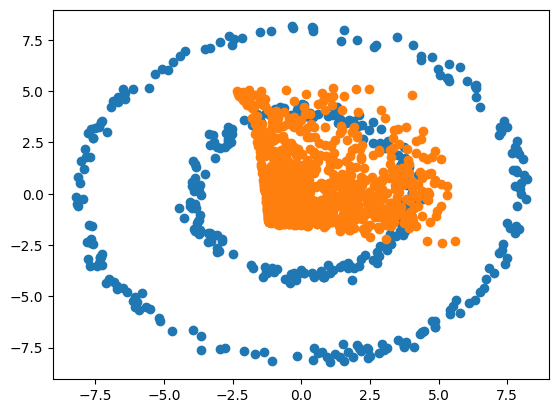

iter=2500 | lossv=-0.38519516587257385 | lossT=0.5800918340682983
iter=3000 | lossv=-0.26569634675979614 | lossT=0.5761470794677734
iter=3500 | lossv=-0.3659266531467438 | lossT=0.5878506898880005
iter=4000 | lossv=-0.3543175160884857 | lossT=0.5825598835945129


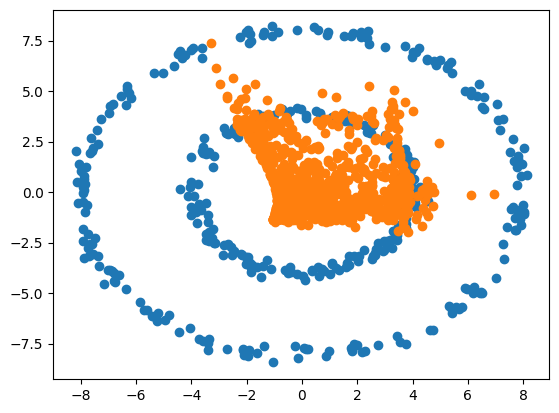

iter=4500 | lossv=-0.3269856572151184 | lossT=0.6231718063354492
iter=5000 | lossv=-0.40449297428131104 | lossT=0.6227803230285645
iter=5500 | lossv=-0.3923220932483673 | lossT=0.6354148983955383
iter=6000 | lossv=-0.3598330616950989 | lossT=0.6052765846252441


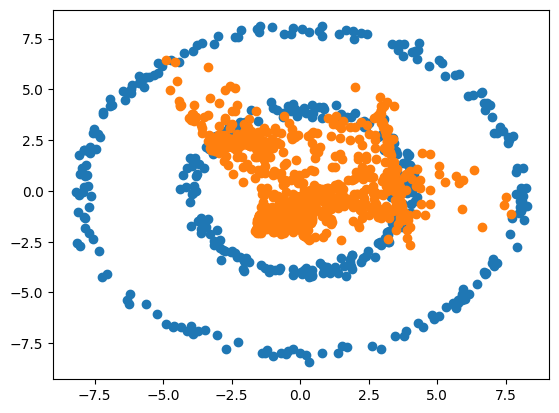

iter=6500 | lossv=-0.41552025079727173 | lossT=0.6381622552871704
iter=7000 | lossv=-0.4022085964679718 | lossT=0.6586387753486633
iter=7500 | lossv=-0.46710386872291565 | lossT=0.6795580983161926
Step k=1:
iter=0 | lossv=-0.37635451555252075 | lossT=0.39512142539024353


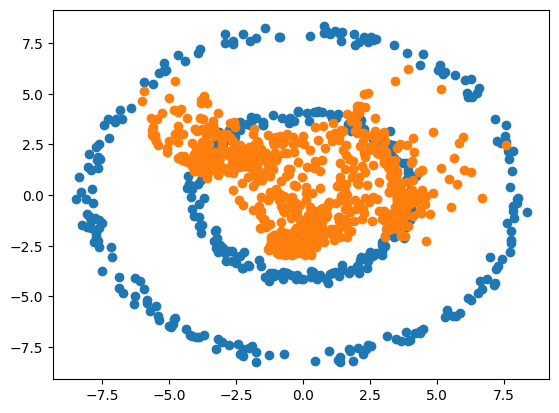

iter=500 | lossv=-0.1837603747844696 | lossT=0.2583536207675934
iter=1000 | lossv=-0.1972883641719818 | lossT=0.3059592843055725
iter=1500 | lossv=-0.24576766788959503 | lossT=0.35387009382247925
iter=2000 | lossv=-0.19075748324394226 | lossT=0.44369637966156006


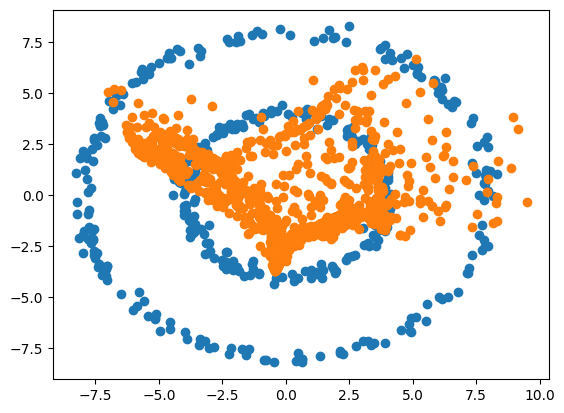

iter=2500 | lossv=-0.18218940496444702 | lossT=0.43909627199172974
iter=3000 | lossv=-0.27272212505340576 | lossT=0.5373364090919495
iter=3500 | lossv=-0.25487959384918213 | lossT=0.5640261769294739
iter=4000 | lossv=-0.36170974373817444 | lossT=0.6384353041648865


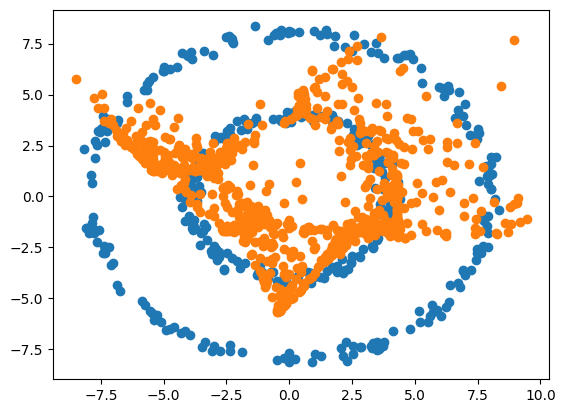

iter=4500 | lossv=-0.2450588345527649 | lossT=0.6599103808403015
iter=5000 | lossv=-0.2372005432844162 | lossT=0.7302510142326355
iter=5500 | lossv=-0.3447352647781372 | lossT=0.756268322467804
iter=6000 | lossv=-0.33927422761917114 | lossT=0.758676290512085


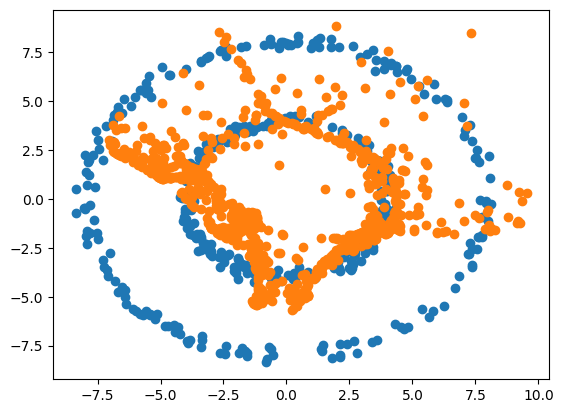

iter=6500 | lossv=-0.24810171127319336 | lossT=0.7774296402931213
iter=7000 | lossv=-0.30350208282470703 | lossT=0.8339473009109497
iter=7500 | lossv=-0.280291885137558 | lossT=0.8045819997787476
Step k=2:
iter=0 | lossv=-0.28188395500183105 | lossT=0.30967944860458374


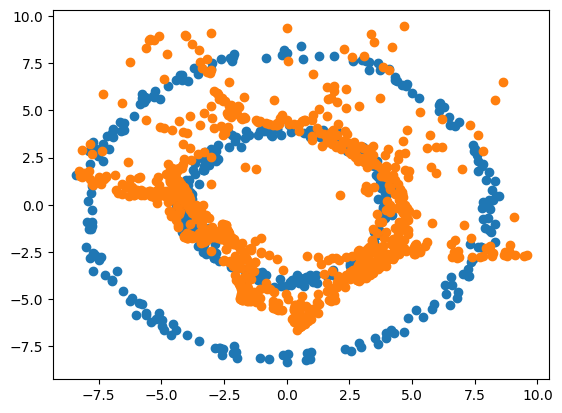

iter=500 | lossv=-0.08273714035749435 | lossT=0.20588678121566772
iter=1000 | lossv=-0.18765683472156525 | lossT=0.2396230846643448
iter=1500 | lossv=-0.09396518021821976 | lossT=0.2380639910697937
iter=2000 | lossv=-0.14810340106487274 | lossT=0.19618387520313263


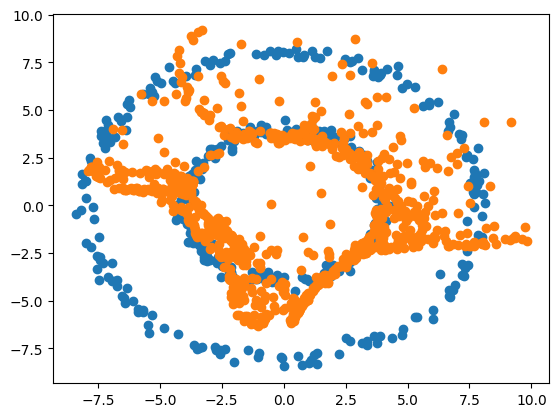

iter=2500 | lossv=-0.15302474796772003 | lossT=0.2084510624408722
iter=3000 | lossv=-0.19007688760757446 | lossT=0.2594602704048157
iter=3500 | lossv=-0.17167454957962036 | lossT=0.2650090456008911
iter=4000 | lossv=-0.1348917931318283 | lossT=0.2564654052257538


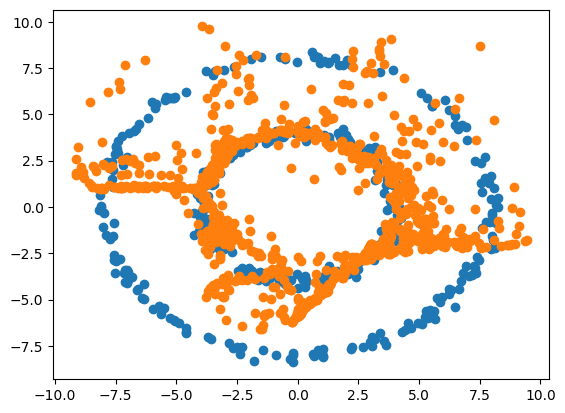

iter=4500 | lossv=-0.17013835906982422 | lossT=0.27735617756843567
iter=5000 | lossv=-0.20825564861297607 | lossT=0.3044195771217346
iter=5500 | lossv=-0.12273580580949783 | lossT=0.31804266571998596
iter=6000 | lossv=-0.11858990043401718 | lossT=0.28272902965545654


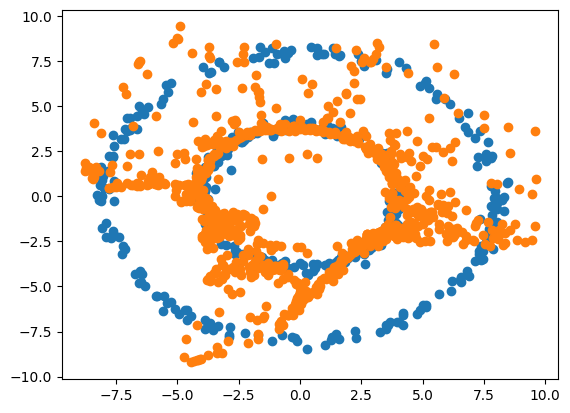

iter=6500 | lossv=-0.16396071016788483 | lossT=0.23603466153144836
iter=7000 | lossv=-0.1262824684381485 | lossT=0.30250227451324463
iter=7500 | lossv=-0.18631210923194885 | lossT=0.33807051181793213
Step k=3:
iter=0 | lossv=-0.1893068104982376 | lossT=0.18080805242061615


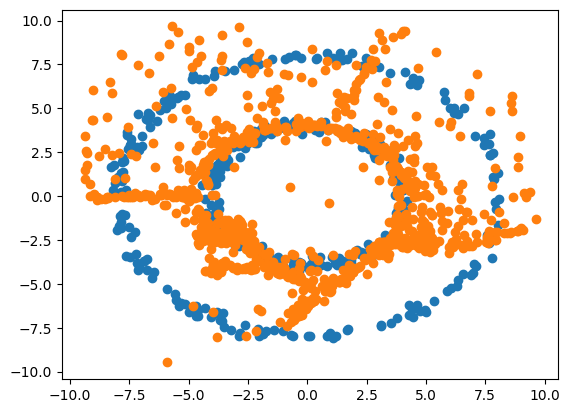

iter=500 | lossv=-0.0812251940369606 | lossT=0.08732154965400696
iter=1000 | lossv=-0.06792120635509491 | lossT=0.11188921332359314
iter=1500 | lossv=-0.08367103338241577 | lossT=0.15115387737751007
iter=2000 | lossv=-0.06593460589647293 | lossT=0.12546302378177643


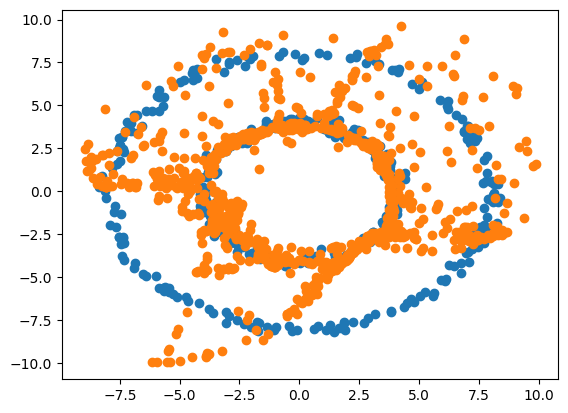

iter=2500 | lossv=-0.07794254273176193 | lossT=0.07666098326444626
iter=3000 | lossv=-0.060555461794137955 | lossT=0.12983746826648712
iter=3500 | lossv=-0.09094885736703873 | lossT=0.1527736335992813
iter=4000 | lossv=-0.09790773689746857 | lossT=0.1807139366865158


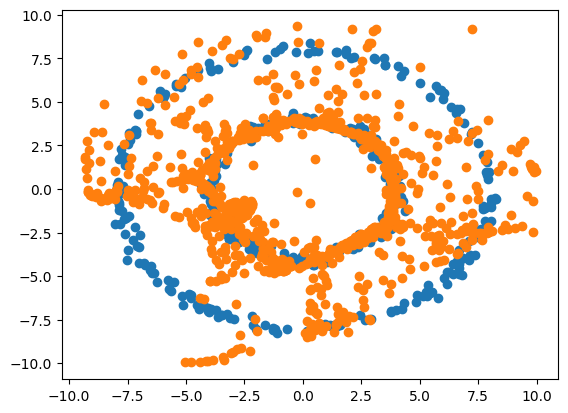

iter=4500 | lossv=-0.0927899181842804 | lossT=0.20144599676132202
iter=5000 | lossv=-0.11496853828430176 | lossT=0.21725860238075256
iter=5500 | lossv=-0.09364274889230728 | lossT=0.25165608525276184
iter=6000 | lossv=-0.11201823502779007 | lossT=0.19211046397686005


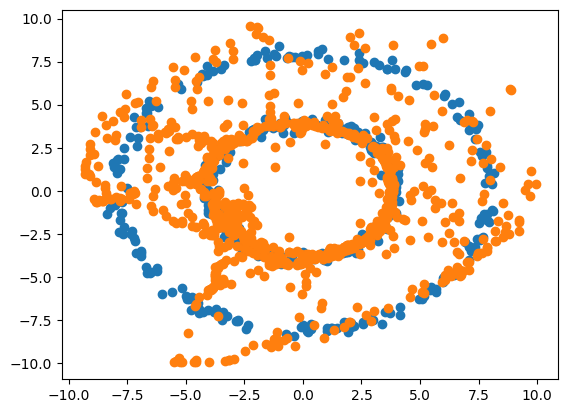

iter=6500 | lossv=-0.13741186261177063 | lossT=0.22373057901859283
iter=7000 | lossv=-0.13171352446079254 | lossT=0.1807336062192917
iter=7500 | lossv=-0.1413731724023819 | lossT=0.19222237169742584
Step k=4:
iter=0 | lossv=-0.11924132704734802 | lossT=0.14583808183670044


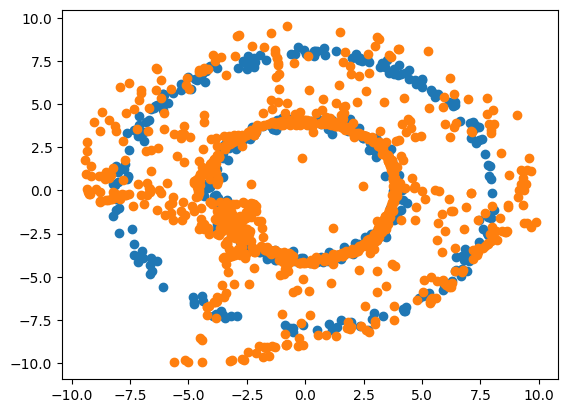

iter=500 | lossv=-0.08548656105995178 | lossT=0.0874539166688919
iter=1000 | lossv=-0.04404785484075546 | lossT=0.07529497891664505
iter=1500 | lossv=-0.08588667213916779 | lossT=0.0018906224286183715
iter=2000 | lossv=-0.09394726157188416 | lossT=0.09329359978437424


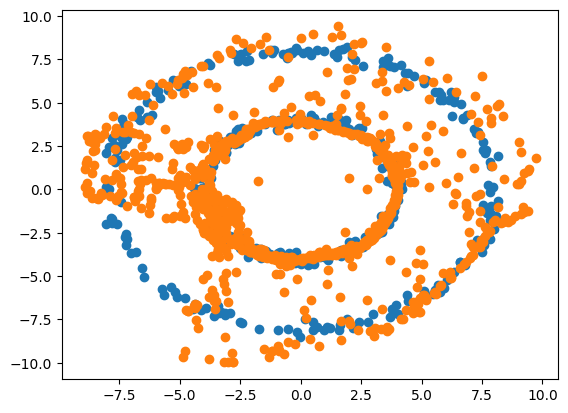

iter=2500 | lossv=-0.045968197286129 | lossT=0.15338391065597534
iter=3000 | lossv=-0.06134028732776642 | lossT=0.07424463331699371
iter=3500 | lossv=-0.07347951829433441 | lossT=0.09779765456914902
iter=4000 | lossv=-0.07712194323539734 | lossT=0.10934820771217346


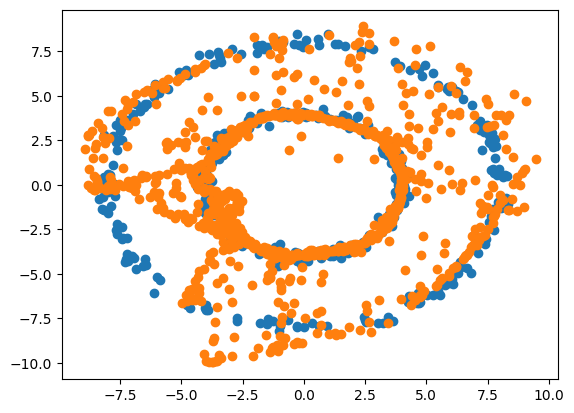

iter=4500 | lossv=-0.08710803836584091 | lossT=0.10203061252832413
iter=5000 | lossv=-0.05499075725674629 | lossT=0.07404597103595734
iter=5500 | lossv=-0.10085615515708923 | lossT=0.12046057730913162
iter=6000 | lossv=-0.0929376631975174 | lossT=0.1659919023513794


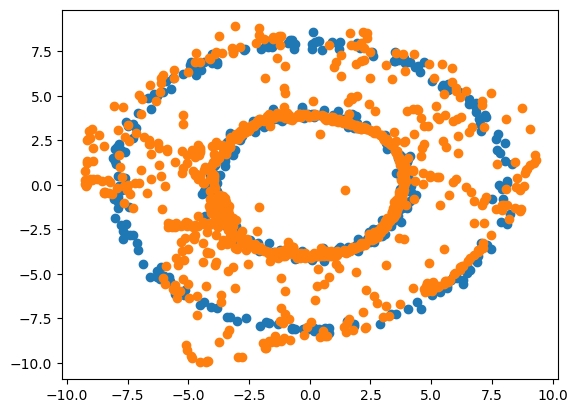

iter=6500 | lossv=-0.11842124909162521 | lossT=0.11661215126514435
iter=7000 | lossv=-0.10445224493741989 | lossT=0.21963125467300415
iter=7500 | lossv=-0.13699696958065033 | lossT=0.15598541498184204
Step k=5:
iter=0 | lossv=-0.1534937024116516 | lossT=0.20481717586517334


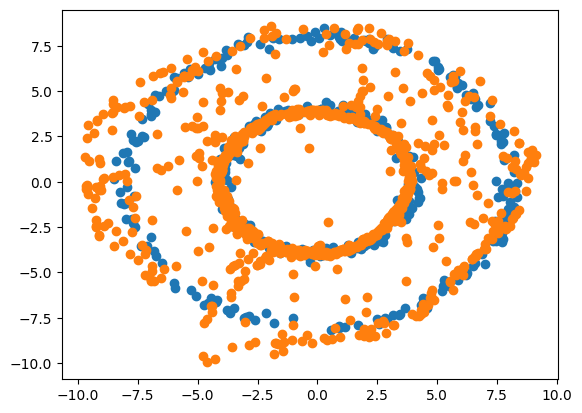

iter=500 | lossv=-0.09414999186992645 | lossT=0.1376962512731552
iter=1000 | lossv=-0.09726183116436005 | lossT=0.11673392355442047
iter=1500 | lossv=-0.09972953796386719 | lossT=0.17346647381782532
iter=2000 | lossv=-0.11617908626794815 | lossT=0.1493518203496933


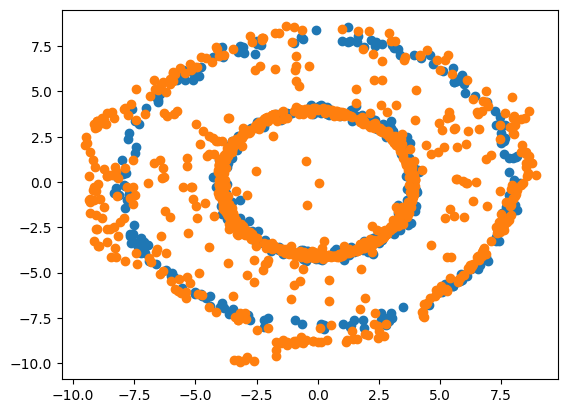

iter=2500 | lossv=-0.12373804301023483 | lossT=0.1683451533317566
iter=3000 | lossv=-0.12161768227815628 | lossT=0.1707151085138321
iter=3500 | lossv=-0.11967850476503372 | lossT=0.19311298429965973
iter=4000 | lossv=-0.14203095436096191 | lossT=0.14879103004932404


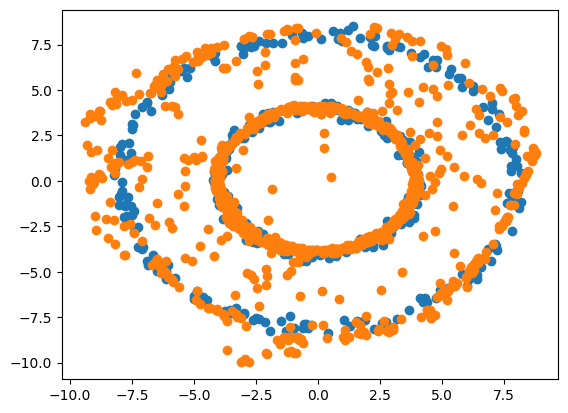

iter=4500 | lossv=-0.11078584939241409 | lossT=0.18313181400299072
iter=5000 | lossv=-0.14583343267440796 | lossT=0.25108468532562256
iter=5500 | lossv=-0.1622258424758911 | lossT=0.17522704601287842
iter=6000 | lossv=-0.16369691491127014 | lossT=0.219514861702919


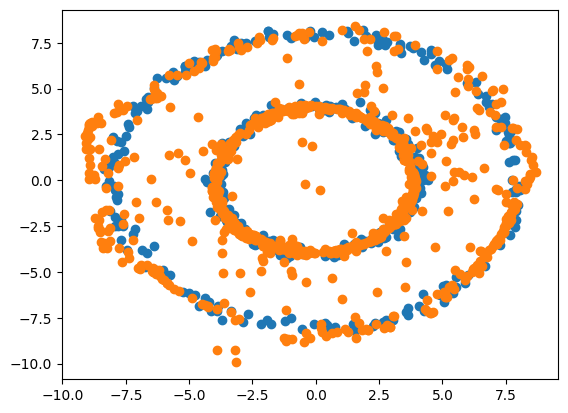

iter=6500 | lossv=-0.1810225248336792 | lossT=0.21963179111480713
iter=7000 | lossv=-0.1528971940279007 | lossT=0.17858465015888214
iter=7500 | lossv=-0.1793001890182495 | lossT=0.14032241702079773
Step k=6:
iter=0 | lossv=-0.1422746330499649 | lossT=0.16661201417446136


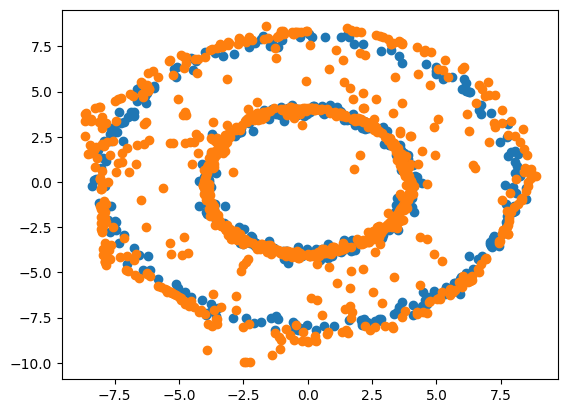

iter=500 | lossv=-0.1815601885318756 | lossT=0.09905001521110535
iter=1000 | lossv=-0.1162562146782875 | lossT=0.10171321779489517
iter=1500 | lossv=-0.09457070380449295 | lossT=0.09629273414611816
iter=2000 | lossv=-0.08381547778844833 | lossT=0.1156931221485138


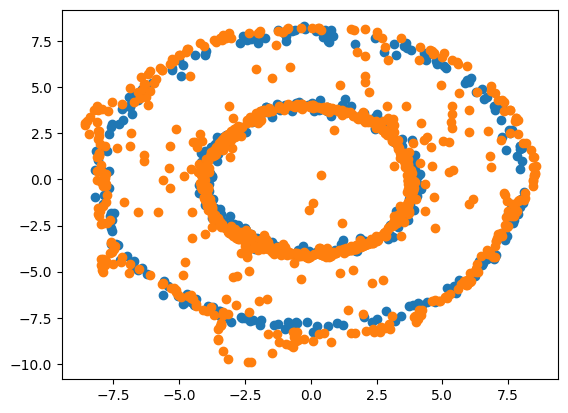

iter=2500 | lossv=-0.10700609534978867 | lossT=0.09259700030088425
iter=3000 | lossv=-0.12936455011367798 | lossT=0.2020036280155182
iter=3500 | lossv=-0.10832203179597855 | lossT=0.1334000825881958
iter=4000 | lossv=-0.17615070939064026 | lossT=0.13141821324825287


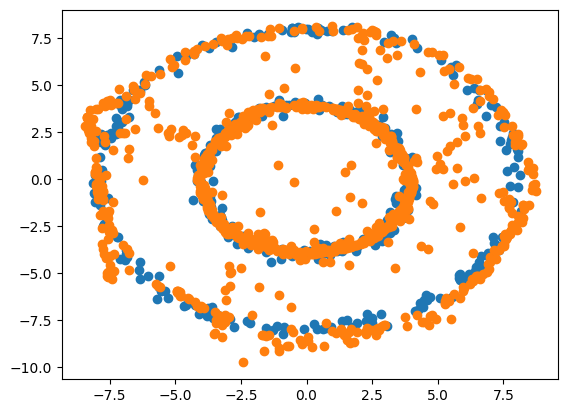

iter=4500 | lossv=-0.09176377952098846 | lossT=0.14844214916229248
iter=5000 | lossv=-0.1277945637702942 | lossT=0.04812021553516388
iter=5500 | lossv=-0.11407917737960815 | lossT=0.1922478824853897
iter=6000 | lossv=-0.15477995574474335 | lossT=0.25996634364128113


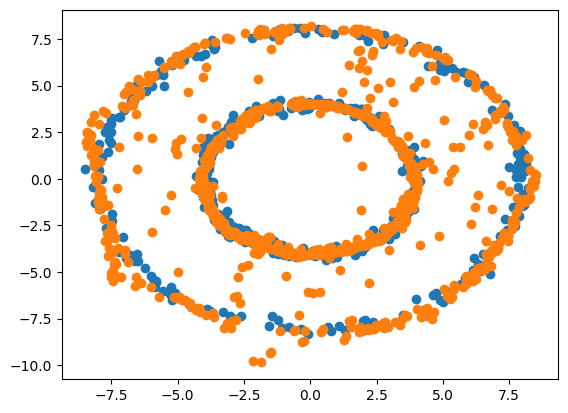

iter=6500 | lossv=-0.13323615491390228 | lossT=0.074898861348629
iter=7000 | lossv=-0.15380007028579712 | lossT=0.11631236970424652
iter=7500 | lossv=-0.13985797762870789 | lossT=0.11244377493858337
Step k=7:
iter=0 | lossv=-0.14325961470603943 | lossT=0.17445224523544312


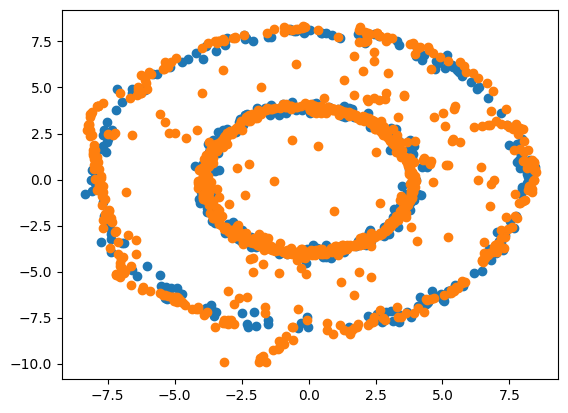

iter=500 | lossv=-0.07419013977050781 | lossT=0.12002470344305038
iter=1000 | lossv=-0.13559968769550323 | lossT=0.18734003603458405
iter=1500 | lossv=-0.1205894872546196 | lossT=0.0842861756682396
iter=2000 | lossv=-0.12480746954679489 | lossT=0.1564868688583374


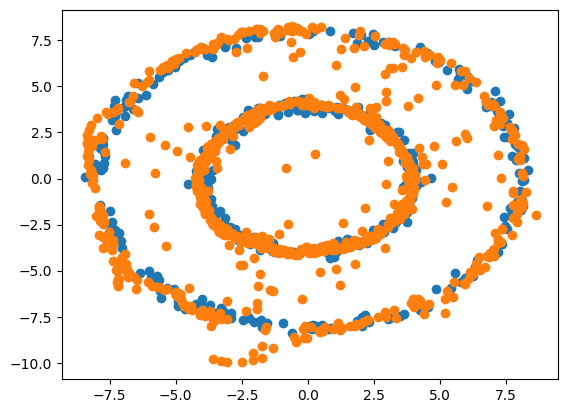

iter=2500 | lossv=-0.08266562223434448 | lossT=0.15161165595054626
iter=3000 | lossv=-0.13484421372413635 | lossT=0.05647577345371246
iter=3500 | lossv=-0.16251689195632935 | lossT=0.1445481926202774
iter=4000 | lossv=-0.10501184314489365 | lossT=0.05502099171280861


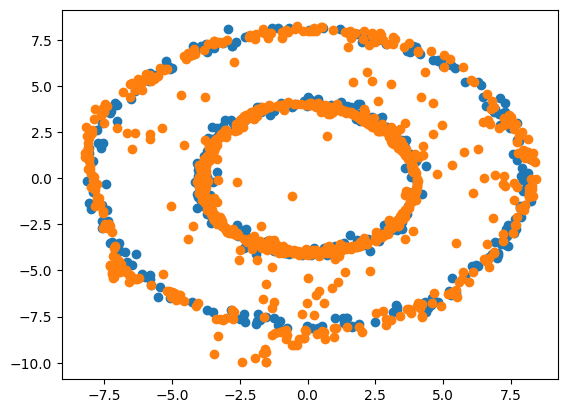

iter=4500 | lossv=-0.14067718386650085 | lossT=0.12898249924182892
iter=5000 | lossv=-0.08453703671693802 | lossT=0.18589584529399872
iter=5500 | lossv=-0.09929157048463821 | lossT=0.10495186597108841
iter=6000 | lossv=-0.13237722218036652 | lossT=0.1889656037092209


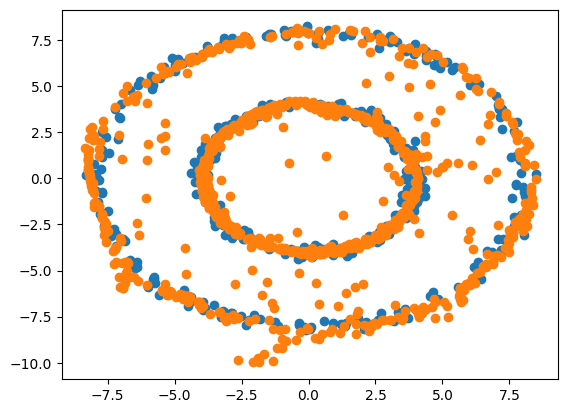

iter=6500 | lossv=-0.08301511406898499 | lossT=0.17524978518486023
iter=7000 | lossv=-0.14183083176612854 | lossT=0.11768873035907745
iter=7500 | lossv=-0.16514922678470612 | lossT=0.0698859691619873
Step k=8:
iter=0 | lossv=-0.1480400413274765 | lossT=0.13395313918590546


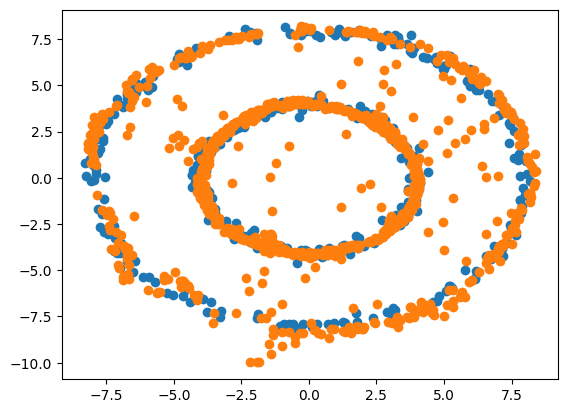

iter=500 | lossv=-0.12719345092773438 | lossT=0.10691948980093002
iter=1000 | lossv=-0.10556942224502563 | lossT=0.22375404834747314
iter=1500 | lossv=-0.1527995467185974 | lossT=0.08986742049455643
iter=2000 | lossv=-0.17760616540908813 | lossT=0.2436782270669937


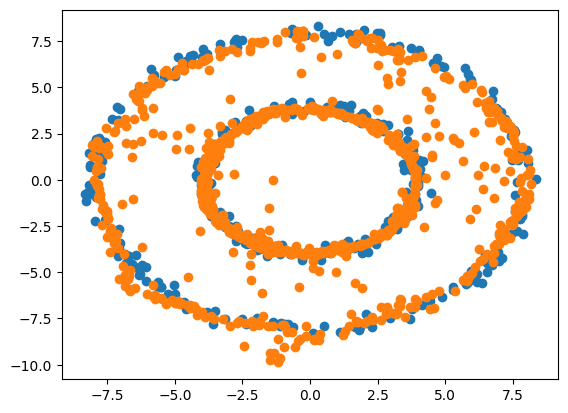

iter=2500 | lossv=-0.1231192946434021 | lossT=0.2077532559633255
iter=3000 | lossv=-0.1315791755914688 | lossT=0.17070716619491577
iter=3500 | lossv=-0.1711026430130005 | lossT=0.11582013964653015
iter=4000 | lossv=-0.08775146305561066 | lossT=0.06347595900297165


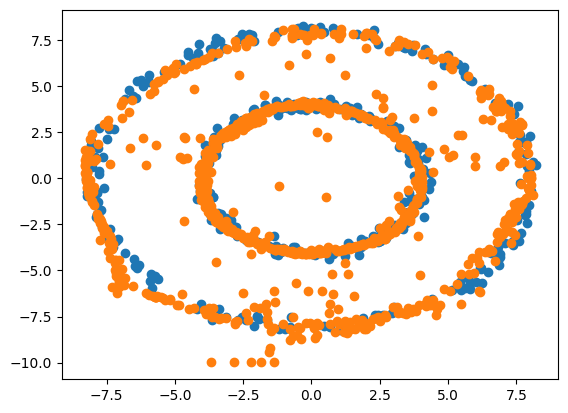

iter=4500 | lossv=-0.17137493193149567 | lossT=0.270501047372818
iter=5000 | lossv=-0.10089212656021118 | lossT=0.09803451597690582
iter=5500 | lossv=-0.14494939148426056 | lossT=0.1481267511844635
iter=6000 | lossv=-0.16997617483139038 | lossT=0.061439529061317444


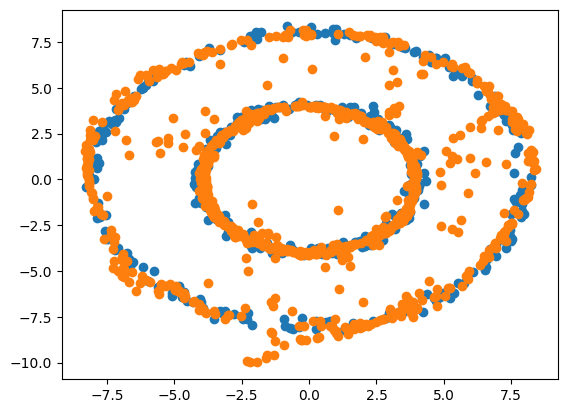

iter=6500 | lossv=-0.20885281264781952 | lossT=0.22439466416835785
iter=7000 | lossv=-0.16292592883110046 | lossT=0.2297578752040863
iter=7500 | lossv=-0.13974568247795105 | lossT=0.1700456589460373
Step k=9:
iter=0 | lossv=-0.10962209105491638 | lossT=0.1263497769832611


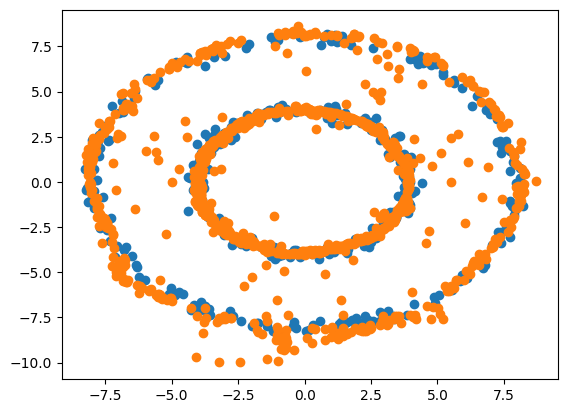

iter=500 | lossv=-0.12361383438110352 | lossT=0.3317827880382538


KeyboardInterrupt: 

In [39]:
batch_size = 400
circle = Circles(batch_size,centers=[[0,0], [0,0]], radius=[4,8], sigmas=[0.2, 0.2])
dim_noise = 2
K = 20
N = 8000
sampler= circle
lr_v=1e-4
lr_T= 1e-3
h = 2
div_name = "KL"

training_sJKO_simple2d(dim_noise,K,N,sampler,batch_size,lr_v,lr_T,h,div_name)